# Analysis of Random Forest Models

**Important 🚨:** If only the demo data for the most common nine species is used, the results produced for all 52 species will naturally be different from the display items in the publication.


## Setup and Functions


In [2]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

import matplotlib
from matplotlib import cm, ticker
from curlyBrace import curlyBrace

In [3]:
pd.set_option("display.max_columns", 50)
# To avoid these copy warnings
pd.options.mode.copy_on_write = True
# Set global font family to Helvetica
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.rcParams["font.family"] = "Arial"

In [4]:
# Make dfs for single responses
def summarize_runs_1pattern(df_responses, spei_or_temp, all_or_top9):

    if all_or_top9 == "top9":
        top9 = [
            "Fagus sylvatica",
            "Quercus robur",
            "Quercus petraea",
            "Carpinus betulus",
            "Castanea sativa",
            "Quercus pubescens",
            "Pinus sylvestris",
            "Abies alba",
            "Picea abies",
        ]
        df_responses = df_responses.query("species in @top9")

    sry = (
        df_responses.copy()
        .groupby([f"response_{spei_or_temp}"])
        .agg(group_size=("group_size", "sum"), n_groups=("species", "count"))
        .sort_values("group_size", ascending=False)
        .reset_index()
    )

    # Attach relative group size
    sry["group_size_rel"] = (
        (sry["group_size"] / sry["group_size"].sum() * 100).round().astype(int)
    )

    # Attach percentages
    sry[f"response_{spei_or_temp}"] = (
        sry[f"response_{spei_or_temp}"]
        + " ("
        + sry["group_size_rel"].astype(str)
        + "%)"
    )

    return sry

In [5]:
def plot_bars_dataset_pattern(
    patterns_merged,
    all_dfs,
    all_or_top9="all",
    color_temp="#77422C",
    color_spei="#D1A289",
    color_rest="lightgrey",
    color_wd="#B2182B",  # Original: "#B2182B"
    color_ww="#2166AC",  # Original: "#2166AC"
    color_other="lightgrey",
    color_cd="lightgrey",  # Original: "#EF8A62",
    color_cw="lightgrey",  # Original: "#67A9CF",
    base_fontsize=12,
    filepath=None,
    ytick_labels=[
        "Warmer".title(),
        "Cooler".title(),
        "Other".title(),
        "Drier".title(),
        "Wetter".title(),
        "Other".title(),
        "Warmer + Drier".title(),
        "Warmer + Wetter".title(),
        "Other".title(),
        "Cooler + Drier".title(),
        "Cooler + Wetter".title(),
    ],
):
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    axs = axs.flatten()

    # Barplot for importance
    ax_dataset_boxplot(
        axs[0],
        all_dfs,
        imps,
        base_fontsize,
        color_spei=color_spei,
        color_temp=color_temp,
        color_rest=color_rest,
        all_or_top9=all_or_top9,
    )

    # Barplot for patterns
    sns.barplot(
        data=patterns_merged,
        x="group_size_rel",
        y="change_simple",
        hue="change_simple",
        palette=[
            color_temp,
            color_temp,
            color_temp,
            color_spei,
            color_spei,
            color_spei,
            color_wd,
            color_ww,
            color_other,
            color_cd,
            color_cw,
        ],
        orient="h",
        height=0.5,
        dodge=False,
        edgecolor="black",
        # hue="response_spei",
        # palette=[
        #     "#B2182B",
        #     "#2166AC",
        #     "grey",
        # ],
        ax=axs[1],
    )

    # Add values to end of bars
    for i in range(len(patterns_merged)):
        axs[1].text(
            patterns_merged.loc[i, "group_size_rel"] + 1,
            i + -0.1,
            f"{patterns_merged.loc[i, 'group_size_rel']}%",
            va="center",
            fontsize=base_fontsize * 0.9,
        )

    # Add horizontal lines
    axs[1].axhline(2.35, color="black", linewidth=1)
    axs[1].axhline(5.35, color="black", linewidth=1)

    # Add text
    axs[1].text(
        95,
        2,
        "Temperature\nanomaly",
        ha="right",
        fontweight="bold",
        fontsize=base_fontsize * 1,
    )
    axs[1].text(
        95,
        5,
        "Climatic water\nbalance anomaly",
        ha="right",
        fontweight="bold",
        fontsize=base_fontsize * 1,
    )
    axs[1].text(
        95,
        10,
        "Combined",
        ha="right",
        fontweight="bold",
        fontsize=base_fontsize * 1,
    )

    # Add labels
    axs[1].set_xlabel(
        "Model frequency (%)",
        fontweight="bold",
        labelpad=10,
        fontsize=base_fontsize * 1.2,
    )
    axs[1].set_ylabel(
        # "Climatic conditions before 2$^{\\text{nd}}$ visit",
        "Short-term climatic condition\npromoting mortality",
        labelpad=10,
        fontweight="bold",
        fontsize=base_fontsize * 1.2,
    )

    # Fix y-ticks
    axs[1].set_yticks(range(len(patterns_merged["change_simple"])))
    axs[1].set_yticklabels(
        patterns_merged["change_simple"], va="bottom", fontsize=base_fontsize * 1
    )
    axs[1].tick_params(axis="y", which="both", left=False)

    # Rename y-ticks
    axs[1].set_yticklabels(ytick_labels)

    # Fix axis limits
    axs[1].set_xlim(0, 100)
    axs[1].set_ylim(10.4, -0.4)

    # Remove top and right axis
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)

    # Add letters
    letters = ["A", "B"]
    for i, ax in enumerate(axs):
        ax.text(
            -0.5,
            0.99,
            letters[i],
            transform=ax.transAxes,
            fontsize=base_fontsize * 1.3,
            fontweight="bold",
        )

    # Fix layout
    # Fix x-tick size
    axs[0].tick_params(axis="x", which="both", labelsize=base_fontsize * 0.8)
    axs[1].tick_params(axis="x", which="both", labelsize=base_fontsize * 0.8)
    plt.tight_layout(w_pad=2, h_pad=1)

    if filepath is not None:
        plt.savefig(filepath, dpi=600, bbox_inches="tight")
    plt.show()
    plt.close()

## Settings


In [6]:
# Settings
impurity_or_permutation = "impurity"
sort_runs_by = "roc"  # roc, tss, specificity
roc_threshold = 0.6

# Extract performance and plot per species and run
force_aggregating_runs = True
do_tss_calculation = False
do_plot_feature_importance = False
do_plot_model_performances = False

# Group run by features
scale_response = True
scale_shap = True
make_plot = False

do_plot_interactions = False
sort_plots_by = "run"  # performance - run
single_response = True
interaction_1d = False
interaction_2d = False

# Directories
dir_runs = "./model_runs/all_runs"
dir_save = f"./model_analysis/{datetime.datetime.now().strftime('%Y-%m-%d')}/"

if scale_response and scale_shap:
    dir_save += "scale_response_and_shape/"
elif scale_response:
    dir_save += "scale_response/"
elif scale_shap:
    dir_save += "scaled_SHAP/"
else:
    dir_save += "nothing_scaled/"

dir_save = dir_save + f"/per_species/roc_{roc_threshold}/"
dir_save

'./model_analysis/2025-02-28/scale_response_and_shape//per_species/roc_0.6/'

### Get species data


In [7]:
# Get df for top_species
nfi_raw = get_final_nfi_data_for_analysis(verbose=False).query(
    "tree_state_change in ['alive_alive', 'alive_dead']"
)
# Get normalized and non normalized counts of trees per species
df_top_species = nfi_raw.copy()
df_top_species["species"] = df_top_species["species_lat2"]
tmp_abs = df_top_species["species"].value_counts()
tmp_norm = df_top_species["species"].value_counts(normalize=True)
top_species_all = pd.concat(
    [tmp_abs, tmp_norm], axis=1, keys=["count", "percent"]
).reset_index()
top9 = top_species_all.head(9).species.tolist()
print(f"Top 9 species: {top9}")

# Get species-family dictionary
species_family = (
    nfi_raw[["species_lat2", "family_lat"]].drop_duplicates().reset_index(drop=True)
)

# Get number of trees per species
df_ntrees = (
    df_top_species.query("tree_state_change in ['alive_alive', 'alive_dead']")
    .groupby(["species", "tree_state_change"], observed=False)
    .agg(n_trees=("tree_id", "count"))
    .reset_index()
    .query("n_trees > 0")
    .pivot(index="species", columns="tree_state_change", values="n_trees")
    .replace(np.nan, 0)
    .assign(n_trees_total=lambda x: x["alive_alive"] + x["alive_dead"])
    .astype(int)
    .reset_index()
    .rename_axis(None, axis=1)
)
df_ntrees.head(2)

Top 9 species: ['Fagus sylvatica', 'Quercus robur', 'Quercus petraea', 'Carpinus betulus', 'Castanea sativa', 'Quercus pubescens', 'Pinus sylvestris', 'Abies alba', 'Picea abies']


,species,alive_alive,alive_dead,n_trees_total
0,Abies alba,28235,780,29015
1,Abies cephalonica,6,0,6


In [8]:
df_species_genus = (
    nfi_raw[["species_lat2", "genus_lat"]].drop_duplicates().reset_index(drop=True)
)
df_species_genus.head(2)

,species_lat2,genus_lat
0,Quercus petraea,Quercus
1,Fagus sylvatica,Fagus


## Aggregate runs


### Get all runs per species


In [9]:
# Get all runs
all_runs = os.listdir(dir_runs)
# Remove some folders
all_runs = [run for run in all_runs if not run.startswith(".")]
all_runs = [run for run in all_runs if not run.endswith(".txt")]
all_runs = [run for run in all_runs if run != "_archive"]
all_runs = sorted(all_runs)
# all_runs

# Get all species
all_species = nfi_raw["species_lat2"].unique().tolist()
all_species = sorted(all_species)
all_species

['Abies alba',
 'Abies cephalonica',
 'Abies concolor',
 'Abies grandis',
 'Abies nordmanniana',
 'Abies pinsapo',
 'Acer campestre',
 'Acer monspessulanum',
 'Acer negundo',
 'Acer opalus',
 'Acer platanoides',
 'Acer pseudoplatanus',
 'Aesculus hippocastanum',
 'Ailanthus altissima',
 'Alnus alnobetula',
 'Alnus cordata',
 'Alnus glutinosa',
 'Alnus incana',
 'Arbutus unedo',
 'Betula pendula',
 'Betula pubescens',
 'Buxus sempervirens',
 'Carpinus betulus',
 'Castanea sativa',
 'Casuarina equisetifolia',
 'Cedrus atlantica',
 'Cedrus brevifolia',
 'Cedrus libani',
 'Celtis australis',
 'Cercis siliquastrum',
 'Chamaecyparis lawsoniana',
 'Conifer',
 'Cornus mas',
 'Corylus avellana',
 'Crataegus azarolus',
 'Crataegus laevigata',
 'Crataegus monogyna',
 'Cryptomeria japonica',
 'Cupressus arizonica',
 'Cupressus macrocarpa',
 'Cupressus sempervirens',
 'Cydonia oblonga',
 'Erica arborea',
 'Eucalyptus',
 'Euonymus europaeus',
 'Fagus sylvatica',
 'Ficus carica',
 'Frangula alnus',
 

### Extract performance and plot per single run


In [10]:
#
# ! This cell aggregates all runs for each species and plots all runs into a single figure

df_all = []
counter = 0

for i_species in all_species:

    # Progress
    counter += 1
    print(f"{counter}/{len(all_species)}\t{i_species}")

    # ! Aggregate all runs -----------------------------------------------------
    metric_names = [
        "test_boot_mean",
        "test_boot_sd",
        "train_boot_mean",
        "train_boot_sd",
    ]

    # Check if all_runs.csv already exists
    i_file = f"{dir_save}/{i_species}/all_runs.csv"
    if not os.path.exists(i_file) or force_aggregating_runs:
        # if True:
        runs_subset = []
        # Loop through all runs to get all runs according to the user input
        for i_run in all_runs:
            # Get directory
            i_dir = os.path.join(dir_runs, i_run, i_species)

            # Check if user input file exists
            txt_ui = f"{i_dir}/__user_input.txt"
            first_file = glob.glob(txt_ui)

            # If no user input file, then skip
            if len(first_file) == 0:
                # raise Exception(f"❌ No user input file in {i_dir}")
                continue

            # Check if run was impurity or permutation
            first_file = first_file[0]
            with open(first_file, "r") as f:
                lines = f.readlines()
                for line in lines:
                    if " - impurity" in line:
                        model_run = "impurity"
                    elif " - permutation" in line:
                        model_run = "permutation"

            # Skip if not the same as user input
            if model_run != impurity_or_permutation:
                continue

            # Check if final model performance exists
            txt_ui = f"{i_dir}/final_model_performance.csv"
            first_file = glob.glob(txt_ui)
            # If no user input file, then skip
            if len(first_file) == 0:
                # print(f"❌ No final model performance for {i_dir}")
                continue

            # Load final model performance
            final_model = pd.read_csv(f"{i_dir}/final_model_performance.csv")
            final_model = final_model.drop(columns=metric_names)

            new_scores = pd.read_csv(f"{i_dir}/rf_performance/roc_auc.csv")
            new_scores.columns = metric_names

            f_pred_prob = f"{i_dir}/final_model/y_test_proba.csv"
            f_true = f"{i_dir}/final_model/y_test.csv"

            df_pred_prob = pd.read_csv(f_pred_prob).iloc[:, 2].reset_index(drop=True)
            df_true = pd.read_csv(f_true).iloc[:, 1].reset_index(drop=True)

            # Check if both have the same length
            if df_pred_prob.shape[0] != df_true.shape[0]:
                raise ValueError("🟥 Length of df_pred_prob and df_true do not match")
                chime.error()

            # > Run TSS
            if do_tss_calculation:
                print(" | Running TSS...")
                tss_mean, tss_std, rest = bootstrap_optimal_tss(
                    df_true,
                    df_pred_prob,
                    n_bootstraps=100,
                    random_state=42,
                    thresholds=np.linspace(0.0, 1.0, num=101),
                    show=False,
                )

                # Overwrite with TSS scores
                new_scores["tss_mean"] = tss_mean
                new_scores["tss_std"] = tss_std

                new_scores["specificity_mean"] = rest["optimal_specificity_mean"]
                new_scores["specificity_std"] = rest["optimal_specificity_std"]

            final_model = pd.concat([final_model, new_scores], axis=1)
            final_model["species"] = i_species
            runs_subset.append(final_model)

        # Skip if no runs
        if len(runs_subset) == 0:
            print(f"\t❌ No runs for {i_species}")
            continue

        # Get save directory
        dir_analysis = f"{dir_save}/{i_species}"
        os.makedirs(dir_analysis, exist_ok=True)

        # Concatenate all runs
        runs_subset = pd.concat(runs_subset)

        # Overwrite subset_group variable
        runs_subset["subset_group"] = (
            runs_subset["dir"].str.split("all_runs/").str[-1].str.split("/").str[0]
        )

        df_filtered = runs_subset.copy()
        df_filtered.to_csv(f"{dir_analysis}/all_runs.csv", index=False)
    else:
        dir_analysis = f"{dir_save}/{i_species}"
        df_filtered = pd.read_csv(i_file)

    # Update save dir based on grouping
    dir_analysis = f"{dir_analysis}/by_{sort_runs_by}"
    os.makedirs(dir_analysis, exist_ok=True)

    # Overwrite metric variable to match remainder of the code
    if sort_runs_by == "tss":
        df_filtered["test_boot_mean"] = df_filtered["tss_mean"]
        df_filtered["test_boot_sd"] = df_filtered["tss_std"]
    elif sort_runs_by == "specificity":
        df_filtered["test_boot_mean"] = df_filtered["specificity_mean"]
        df_filtered["test_boot_sd"] = df_filtered["specificity_std"]

    # Add metric to group variable
    df_filtered["run"] = df_filtered["subset_group"].str.replace("run_", "")
    df_filtered["subset_group"] = (
        df_filtered["subset_group"]
        + " ("
        + df_filtered["test_boot_mean"].round(3).astype(str)
        + ")"
    )

    # Adjust sorting
    if sort_plots_by == "performance":
        df_filtered = df_filtered.sort_values(
            "test_boot_mean", ascending=False
        ).reset_index(drop=True)
    elif sort_plots_by == "run":
        df_filtered = df_filtered.sort_values(
            "subset_group", ascending=True
        ).reset_index(drop=True)
    else:
        chime.error()
        raise ValueError("🟥 sort_plots_by not recognized")

    # Add df to all
    df_all.append(df_filtered)

    # ! Performance per run -----------------------------------------------------
    if do_plot_model_performances:
        # Mean and std of final model
        mean_perf = df_filtered["test_boot_mean"].mean()
        std_perf = df_filtered["test_boot_mean"].std()
        txt = f"Mean performance on test set: {round(mean_perf, 3)} +/- {round(std_perf, 3)}"
        with open(f"{dir_analysis}/mean_roc_auc_{round(mean_perf, 3)}.txt", "w") as f:
            f.write(txt)

        # Make plots
        def plot_fct(df, order, ascending, show=False):
            plt.figure(figsize=(8, 8))
            sc = plt.scatter(
                data=df.sort_values(order, ascending=ascending),
                y="subset_group",
                x="test_boot_mean",
                edgecolors="black",
                s=60,
                zorder=10,
            )
            plt.errorbar(
                data=df.sort_values(order, ascending=ascending),
                y="subset_group",
                x="test_boot_mean",
                xerr="test_boot_sd",
                color="black",
                fmt="none",
                zorder=2,
            )

            plt.grid(axis="y", zorder=3)
            plt.xlabel("Bootstrapped ROC-AUC on Test Set", fontsize=14)
            plt.xlim(0, 1)
            plt.tight_layout()
            plt.savefig(f"{dir_analysis}/model_performance_sorted_by_{order}.png")
            plt.show() if show else plt.close()

        plot_fct(df_filtered, "subset_group", False)
        plot_fct(df_filtered, "test_boot_mean", True)

    # ! Feature importance by dataset -----------------------------------------------------
    if do_plot_feature_importance:
        # Select all dataset importances
        df_datasets = df_filtered.set_index("subset_group").filter(
            regex="Importance", axis=1
        )

        # Clean variable names
        df_datasets.columns = df_datasets.columns.str.replace(" - Importance", "")
        # Replace NA with 0
        df_datasets = df_datasets.replace(np.nan, 0)

        # Scale all to 0-1
        # df_datasets = df_datasets / df_datasets.max().max() * 100
        # Order by median
        order = df_datasets.median().sort_values(ascending=False).index
        df_datasets = df_datasets[order]

        fig, ax = plt.subplots(figsize=(10, 5))
        sns.boxplot(
            data=df_datasets,
            ax=ax,
            # order=df_datasets.mean().sort_values(ascending=False).index,
            # inner="point",
            orient="h",
            palette="Blues_r",
        )
        # Add jittered points
        # sns.swarmplot(data=df_datasets, orient="h", color="black", alpha=0.25)

        ax.set_title(
            f"Relative Importance of Dataset across all Runs (N = {df_filtered.subset_group.nunique()})",
            weight="bold",
        )
        ax.set_xlabel("Relative importance of dataset within a species model (%)")
        # plt.xticks(rotation=45)
        plt.xlim(-0.5, 35)
        plt.tight_layout()
        plt.savefig(f"{dir_analysis}/feature_importance-shap-by_dataset.png")
        plt.close()

        # ! Feature importance by feature -----------------------------------------------------
        # Get all datasets
        all_datasets = (
            df_filtered.set_index("subset_group")
            .filter(regex="Importance", axis=1)
            .columns.str.replace(" - Importance", "")
            .values.tolist()
        )

        # Initiate lists
        dic_values = {}
        dic_counts = {}
        dic_preds = {}

        # Loop through all datasets
        for d in all_datasets:
            # Get dataset subset and remove NA values
            df_i = (
                df_filtered.set_index("subset_group").filter(regex=d, axis=1).dropna()
            )
            dataset_features = []

            # Loop over all species
            for i, species in enumerate(df_i.index):

                # Set species
                df_i["Species"] = species

                # Get metrics and values of dataset
                imetrics = df_i.loc[species][f"{d} - Metrics"]
                ivalues = df_i.loc[species][f"{d} - Values"]

                # Turn string into literal
                imetrics = ast.literal_eval(imetrics)
                ivalues = ast.literal_eval(ivalues)

                # Loop over spei metrics
                for j, jmetric in enumerate(imetrics):
                    # Check if metric is already in dictionary
                    if jmetric not in dic_values:
                        dic_values[jmetric] = []
                        dic_counts[jmetric] = 0

                    # Attach value to dictionary
                    dic_values[jmetric].append(ivalues[j])
                    # Add count to dictionary
                    dic_counts[jmetric] += 1
                    # Attach metric to dictionary
                    dataset_features.append(jmetric)

            # Remove metric duplicates
            dataset_features = list(set(dataset_features))
            # Attach to dictionary
            dic_preds[d] = dataset_features

        # Get df
        df_values = turn_dictionary_into_df(dic_values)
        df_counts = df_values.count()
        max_value = df_values.max().max()

        # Scale df
        # df_values = df_values / df_values.max().max() * 100

        # Replace NA with 0
        df_values = df_values.replace(np.nan, 0)

        # Sort keys by dataset order
        dic_preds = {key: dic_preds[key] for key in order if key in dic_preds}

        # Create a 2x6 grid of subplots
        fig, axs = plt.subplots(
            3,
            4,
            figsize=(22, 10),
            # sharex=True,
            # sharey=True,
        )

        # Flatten the axs array
        axs = axs.flatten()

        # Combine all columns for color scaling
        max_val = df_values.notna().sum().max()
        cmap = sns.color_palette("Blues", as_cmap=True)

        # Loop over each axis
        for i, ax in enumerate(axs):
            # Check if i is smaller than the number of datasets
            if i < len(dic_preds.keys()):
                # Get variables of that dataset
                df_i = df_values[dic_preds[list(dic_preds.keys())[i]]]

                # Order by median
                iorder = df_i.median().sort_values(ascending=False).index
                df_i = df_i[iorder]

                # Get counts and normalize for color scaling
                max_val = df_i.notna().sum().max()
                norm_counts = df_i.notna().sum() / max_val
                cmap = sns.color_palette("Blues", as_cmap=True)
                colors = norm_counts

                # Create violin plot
                # sns.violinplot(
                sns.boxplot(
                    data=df_i,
                    ax=ax,
                    orient="h",
                    palette=sns.color_palette("Blues", as_cmap=True)(colors).tolist(),
                    linecolor="black",
                )

                # Set title
                ax.set_title(list(dic_preds.keys())[i], weight="bold")

                # Set x-axis range
                # ax.set_xlim(0, 100)
                ax.set_xlim(-1, max_value * 1.05)

                if i > 6:
                    # Set x-axis label
                    ax.set_xlabel("Relative Feature Importance")
            else:
                # Remove axis
                ax.remove()

        # Add colorbar in the bottom right corner
        cbar_ax = fig.add_axes(
            [0.875, 0.05, 0.05, 0.25]
        )  # [left, bottom, width, height]
        cbar = plt.colorbar(
            plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1)),
            cax=cbar_ax,
            orientation="vertical",
        )
        cbar.set_label(
            f"Share of occurrences across\nall models (100% = {df_filtered.shape[0]} models)",
            fontsize=12,
        )
        # Set the ticks of the colorbar to represent percentages from 0 to 100
        cbar.set_ticks(np.linspace(0, 1, 11))  # Set 11 ticks from 0 to 1
        cbar.set_ticklabels(
            [f"{int(tick*100)}%" for tick in np.linspace(0, 1, 11)]
        )  # Convert ticks to percentages

        # Make sure the subplots are tight
        # plt.tight_layout()
        plt.savefig(
            f"{dir_analysis}/feature_importance-shap-by_feature-colored_relative_occurences.png"
        )
        plt.close()

    # ! Interaction plots -----------------------------------------------------
    if do_plot_interactions:
        datasets = [
            "SPEI",
            "Temperature",
            # "Tree Size",
            # "Light Competition",
            # "Species Competition",
            # "Topography",
            # "NDVI",
            # "Stand Structure",
            # "Soil Fertility",
            # "Management",
            # "Soil Water Conditions",
        ]

        for ds1 in datasets:
            if single_response:
                plot_shap_response(
                    df_filtered,
                    ds1,
                    scale_shap=scale_shap,
                    scale_response=scale_response,
                    remove_labels=False,
                    show=False,
                    dir_analysis=dir_analysis,
                    filesuffix=f"-sorted_by_{sort_plots_by}",
                )

            for ds2 in datasets:
                if ds1 == ds2:
                    continue

                if interaction_1d:
                    plot_shap_response_interaction(
                        df_filtered,
                        ds1,
                        ds2,
                        remove_labels=False,
                        show=False,
                        dir_analysis=dir_analysis,
                        filesuffix=f"-sorted_by_{sort_plots_by}",
                    )
                if interaction_2d:
                    plot_shap_interaction2(
                        df_filtered,
                        ds1,
                        ds2,
                        remove_labels=False,
                        show=False,
                        dir_analysis=dir_analysis,
                        filesuffix=f"-sorted_by_{sort_plots_by}",
                    )

df_all_concat = pd.concat(df_all).reset_index(drop=False)
df_all_concat

1/155	Abies alba
2/155	Abies cephalonica
	❌ No runs for Abies cephalonica
3/155	Abies concolor
	❌ No runs for Abies concolor
4/155	Abies grandis
5/155	Abies nordmanniana
	❌ No runs for Abies nordmanniana
6/155	Abies pinsapo
	❌ No runs for Abies pinsapo
7/155	Acer campestre
8/155	Acer monspessulanum
	❌ No runs for Acer monspessulanum
9/155	Acer negundo
	❌ No runs for Acer negundo
10/155	Acer opalus
	❌ No runs for Acer opalus
11/155	Acer platanoides
	❌ No runs for Acer platanoides
12/155	Acer pseudoplatanus
13/155	Aesculus hippocastanum
	❌ No runs for Aesculus hippocastanum
14/155	Ailanthus altissima
	❌ No runs for Ailanthus altissima
15/155	Alnus alnobetula
	❌ No runs for Alnus alnobetula
16/155	Alnus cordata
	❌ No runs for Alnus cordata
17/155	Alnus glutinosa
18/155	Alnus incana
19/155	Arbutus unedo
20/155	Betula pendula
21/155	Betula pubescens
22/155	Buxus sempervirens
23/155	Carpinus betulus
24/155	Castanea sativa
25/155	Casuarina equisetifolia
	❌ No runs for Casuarina equisetifolia


,index,subset,subset_group,created,best_model_decision,N_died,N_surv,dir,oversampled_cv,oversampled_test,metric,Light Competition - Importance,Light Competition - Metrics,Light Competition - Values,Species Competition - Importance,Species Competition - Metrics,Species Competition - Values,Tree Size - Importance,Tree Size - Metrics,Tree Size - Values,Topography - Importance,Topography - Metrics,Topography - Values,SPEI - Importance,SPEI - Metrics,SPEI - Values,Temperature - Importance,Temperature - Metrics,Temperature - Values,Soil Fertility - Importance,Soil Fertility - Metrics,Soil Fertility - Values,Stand Structure - Importance,Stand Structure - Metrics,Stand Structure - Values,NDVI - Importance,NDVI - Metrics,NDVI - Values,Soil Water Conditions - Importance,Soil Water Conditions - Metrics,Soil Water Conditions - Values,Management - Importance,Management - Metrics,Management - Values,test_boot_mean,test_boot_sd,train_boot_mean,train_boot_sd,species,run
0,0,species_lat2,run_1220 (0.724),2025-02-24 19:20:06,best_per_category,780,28235,model_runs/all_runs/run_1220/Abies alba/,False,False,roc_auc,19.648595,['social_status'],[19.64859473],12.430517,['competition_same_species_rel'],[12.43051664],9.482267,['htot_final'],[9.48226654],9.257887,['altitude'],[9.25788723],8.874210,['spei3-may_min'],[8.87421049],8.739359,['tmoy_win_mean_anomaly'],[8.73935858],7.216549,['pH'],[7.21654869],6.709180,['carrying_capacity'],[6.70918031],6.284373,['ndvi_min_anomaly'],[6.28437322],6.053155,['waterlogging_temp'],[6.05315464],5.303909,['mgmt_intensity'],[5.30390893],0.724298,0.022748,0.996466,0.000152,Abies alba,1220
1,1,species_lat2,run_1221 (0.764),2025-02-24 19:40:35,best_per_category,780,28235,model_runs/all_runs/run_1221/Abies alba/,False,False,roc_auc,21.719767,['social_status'],[21.71976707],10.555606,['competition_same_species_rel'],[10.55560606],9.300270,['c13_1'],[9.30027004],6.975168,['altitude'],[6.97516839],12.827171,['spei1-may_min'],[12.82717086],6.005815,['tmoy_win_mean_anomaly'],[6.0058152],7.245565,['pH'],[7.24556524],6.267618,['carrying_capacity'],[6.2676178],2.964984,['ndvi_trend'],[2.96498446],6.193484,['waterlogging_temp'],[6.19348392],9.944551,['dist_road'],[9.94455097],0.764277,0.019306,0.995986,0.000168,Abies alba,1221
2,2,species_lat2,run_1222 (0.734),2025-02-24 18:24:04,best_per_category,780,28235,model_runs/all_runs/run_1222/Abies alba/,False,False,roc_auc,20.230940,['social_status'],[20.23093953],8.335261,['competition_other_species_rel'],[8.33526088],10.268131,['c13_1'],[10.26813069],6.760695,['altitude'],[6.76069502],12.882548,['spei1-may_min'],[12.8825475],9.026763,['tmax_win_mean_anomaly'],[9.02676332],6.674458,['pH'],[6.67445763],3.657429,['competition_total'],[3.65742903],3.645002,['ndvi_min_anomaly'],[3.64500213],7.397048,['waterlogging_temp'],[7.39704757],11.121727,['dist_road'],[11.1217267],0.733579,0.022842,0.995544,0.000177,Abies alba,1222
3,3,species_lat2,run_1223 (0.738),2025-02-24 18:45:06,best_per_category,780,28235,model_runs/all_runs/run_1223/Abies alba/,False,False,roc_auc,20.663228,['social_status'],[20.66322811],9.063487,['competition_same_species_rel'],[9.06348692],12.819949,['c13_1'],[12.81994892],5.320354,['altitude'],[5.32035419],11.704329,['spei1-may_min'],[11.70432915],11.654067,['tmax_win_mean_anomaly'],[11.65406717],5.660854,['pH'],[5.66085411],4.804334,['competition_total'],[4.80433439],5.346268,['ndvi_mean'],[5.34626848],4.715943,['waterlogging_temp'],[4.71594303],8.247186,['mgmt_intensity'],[8.24718552],0.738410,0.022489,0.995555,0.000169,Abies alba,1223
4,4,species_lat2,run_1224 (0.755),2025-02-24 19:03:20,best_per_category,780,28235,model_runs/all_runs/run_1224/Abies alba/,False,False,roc_auc,19.679261,['social_status'],[19.6792615],8.840081,['competition_other_species_rel'],[8.84008068],11.048782,['c13_1'],[11.04878224],8.754079,['altitude'],[8.75407874],11.930366,['spei3-may_min'],[11.93036576],6.706586,['tmax_sum_mean_anomaly'],[6.70658552],7.153894,['pH'],[7.15389376],4.058808,['com

### Assess runs with same predictors


In [11]:
# Shortcut to avoid plotting
make_plot = False

print(
    f"""
    Chosen settings for response classification
     - Scale SHAP: {scale_shap}
     - Scale Response: {scale_response}
     - ROC Threshold: {roc_threshold}
     - Make Plots: {make_plot}
     - Directory: {dir_save}

    Notes:
     - Parallel processing takes about 5 minutes without plotting and 10 minutes with plotting.
     - Since running parallel, the df_patterns must be created afterwards by merging the results.
    """
)

# Turn df into list
tmp_list = split_df_into_list_of_group_or_ns(df_all_concat, "species")

from random_forest_utils import response_classification

run_mp(
    response_classification,
    tmp_list,
    progress_bar=True,
    num_cores=9,
    scale_shap=scale_shap,
    scale_response=scale_response,
    roc_threshold=roc_threshold,
    dir_save=dir_save,
    make_plots=make_plot,
    verbose=False,
)
chime.success()

# Code for a single run:
# response_classification(
#     tmp_list[0],
#     scale_shap=scale_shap,
#     scale_response=scale_response,
#     roc_threshold=roc_threshold,
#     dir_save=dir_save,
#     make_plots=True,
#     verbose=False,
# )


    Chosen settings for response classification
     - Scale SHAP: True
     - Scale Response: True
     - ROC Threshold: 0.6
     - Make Plots: False
     - Directory: ./model_analysis/2025-02-28/scale_response_and_shape//per_species/roc_0.6/

    Notes:
     - Parallel processing takes about 5 minutes without plotting and 10 minutes with plotting.
     - Since running parallel, the df_patterns must be created afterwards by merging the results.
    


 81%|████████  | 42/52 [04:24<00:36,  3.61s/it]/Users/pascal/my_work/projects active/ifn_analysis/.venv/lib/python3.11/site-packages/pymer4/utils.py:397: RuntimeWarning: invalid value encountered in divide
  t = b / se
/Users/pascal/my_work/projects active/ifn_analysis/.venv/lib/python3.11/site-packages/pymer4/stats.py:657: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (rss / tss)
/Users/pascal/my_work/projects active/ifn_analysis/.venv/lib/python3.11/site-packages/pymer4/models/Lm.py:539: RuntimeWarning: divide by zero encountered in log
  self.logLike = (-np.log(ssr) * half_obs) - (
 83%|████████▎ | 43/52 [04:26<00:26,  2.91s/it]/Users/pascal/my_work/projects active/ifn_analysis/.venv/lib/python3.11/site-packages/pymer4/utils.py:397: RuntimeWarning: invalid value encountered in divide
  t = b / se
/Users/pascal/my_work/projects active/ifn_analysis/.venv/lib/python3.11/site-packages/pymer4/stats.py:657: RuntimeWarning: invalid value encountered in scalar divi

# Analyse Responses


## Settings


In [12]:
# Settings
# ! Classification data
use_class_data = "mk"
# | mk - lm
threshold_metric = "pvalue"
# | Metric to use for response classification: pvalue - r2
threshold_value = 0.01
# | Value to use for response classification
min_group_share = 0.6
# | Groups with no pattern share above this will be classified as unclear

# ! Aggregation settings
method_scaling_importance = "scaled_valid"
# | sum: counts the number of times a feature is selected, the more valid runs for a species, the higher the count
# | scaled_all: percentage of occurences of feature in all runs for a species (including invalid runs)
# | scaled_valid: percentage of occurences of feature in valid runs for a species (excluding invalid runs)

# ! Chart settings
normalized_change_chart = False  # Normalize change-chart?
normalized_import_chart = False  # Normalize importance-chart?
bars_in_double_chart = "ntrees"  # ntrees or nruns
ntrees_log = False  # Log scale for ntrees

# Display order
sort_by = "species"  # change - species - runs - performance - importance - ntrees

# Change order
change_dict = {
    "warmer_drier": "#B2182B",
    "cooler_drier": "#EF8A62",
    "other": "lightgrey",
    "cooler_wetter": "#67A9CF",
    "warmer_wetter": "#2166AC",
}
change_order = [k for k in change_dict.keys()]
change_colors = [i for i in change_dict.values()]

# For temperature boxplots
one_point_per_pattern = True

# ! Subsetting
top_only = False
top_n = 20

# ! Other
n_all_runs = 50

In [13]:
dir_root = dir_save.split("/")[:4]
dir_root = "/".join(dir_root)
dir_root

dir_patterns = f"{dir_root}/pattern_analysis/by_{use_class_data}/roc_{roc_threshold}/"

if use_class_data == "lm":
    dir_patterns = f"{dir_patterns}/{threshold_metric}_{threshold_value}-min_group_share_{min_group_share}/"

os.makedirs(dir_patterns, exist_ok=True)
dir_patterns

'./model_analysis/2025-02-28/scale_response_and_shape/pattern_analysis/by_mk/roc_0.6/'

### Classification of each run


In [14]:
# Get df_patterns from classifications done above
files = glob.glob(
    f"{dir_save}/*/runs_aggregated_by_spei_temp_pairs-filtered_by_roc-grouped.csv"
)

df_patterns = pd.concat([pd.read_csv(f) for f in files]).reset_index(drop=True)
df_patterns.group_size.sum()
df_patterns.shape

(1299, 22)

In [15]:
print(
    "Note that aggregation to combined temperature-spei response causes some species to not have 50 runs because correlation-removal sometimes resulted in picking temp OR spei feature."
)
df_patterns.groupby("species").group_size.sum().sort_index().head(20)

Note that aggregation to combined temperature-spei response causes some species to not have 50 runs because correlation-removal sometimes resulted in picking temp OR spei feature.


species
Abies alba              50
Abies grandis           44
Acer campestre          47
Acer pseudoplatanus     49
Alnus glutinosa         50
Alnus incana            42
Arbutus unedo           49
Betula pendula          47
Betula pubescens        44
Buxus sempervirens      50
Carpinus betulus        47
Castanea sativa         50
Corylus avellana        50
Crataegus monogyna      50
Fagus sylvatica         50
Frangula alnus          30
Fraxinus excelsior      49
Ilex aquifolium         10
Juniperus communis      18
Laburnum anagyroides    42
Name: group_size, dtype: int64

In [16]:
# Initiate
df_fin = []
if threshold_metric == "pvalue":
    imetric = "pval_1"
elif threshold_metric == "r2":
    imetric = "r2"

# Loop over all species
list_responses_spei = []
list_responses_temp = []
for ispecies in df_patterns.species.unique():

    # ispecies = "Fagus sylvatica"  # ! DEBUG!

    # print(f" - {ispecies}")

    # Get species directory
    idir = f"{dir_save}/{ispecies}/single_response_classification/all_runs/"

    # Get empty list for groups
    df_spec = []

    for ifeature in ["SPEI", "Temperature"]:

        if ifeature == "SPEI":
            dataset = "spei"
        else:
            dataset = "temp"

        idfs = glob.glob(f"{idir}/{ifeature}*group*.csv")
        # print(f"  - {ifeature} ({len(idfs)} files)")
        if len(idfs) == 0:
            chime.error()
            raise ValueError(
                "🟥 No files found. Did you create the response figures and csvs for today?"
            )
        # Load all files
        idfs = [pd.read_csv(i) for i in idfs]
        idfs = pd.concat(idfs).reset_index(drop=True)

        for g in sorted(idfs.run.unique()):
            # Get group
            gdf = idfs.query("run == @g")

            # Start new df
            new_df = pd.DataFrame(
                {
                    "species": ispecies,
                    "group": gdf.group.iloc[0],
                    f"run": gdf.run.iloc[0].split(" (")[0],
                    f"feature_{dataset}": gdf.feature.iloc[0],
                },
                index=[0],
            )

            # Classify response depending on input
            if threshold_metric != "pvalue":
                chime.error()
                raise ValueError("🟥 Only pvalue is implemented")

            # Get metric and slope
            if use_class_data == "lm":
                gmetric = gdf.query("method == 'linear'")["coef1_pval"].iloc[0]
                gslope = gdf.query("method == 'linear'")["coef1"].iloc[0]
            elif use_class_data == "mk":
                gmetric = gdf.query("method == 'mk_raw'")["p"].iloc[0]
                gslope = gdf.query("method == 'mk_raw'")["tau"].iloc[0]
            else:
                chime.error()
                raise ValueError("🟥 use_class_data not recognized")

            # Classify response
            if gmetric < threshold_value:
                gtrend = detect_trend(gslope)
            else:
                gtrend = "other"

            # Attach to new df
            new_df[f"response_{dataset}"] = gtrend
            if dataset == "spei":
                list_responses_spei.append(new_df)
            elif dataset == "temp":
                list_responses_temp.append(new_df)

# Clean df
df_responses_spei = pd.concat(list_responses_spei).reset_index(drop=True)
df_responses_temp = pd.concat(list_responses_temp).reset_index(drop=True)

# Clean wording of increasing/decreasing
df_responses_spei = df_responses_spei.replace(
    {
        "response_spei": {
            "increasing": "drier",
            "decreasing": "wetter",
            "unclear": "other",
        },
    }
)
df_responses_temp = df_responses_temp.replace(
    {
        "response_temp": {
            "increasing": "warmer",
            "decreasing": "cooler",
            "unclear": "other",
        },
    }
)

In [17]:
# Merge response dfs
df_responses = pd.merge(
    df_responses_spei, df_responses_temp, on=["species", "group", "run"]
).sort_values(["species", "group", "run"])

# Add change
df_responses["change"] = (
    df_responses["response_temp"] + "_" + df_responses["response_spei"]
)
# Clean wording of increasing/decreasing
# Clean unclear merges
df_responses["change"] = df_responses["change"].replace(
    {
        # SPEI_Temp
        "drier_other": "other",
        "wetter_other": "other",
        "other_warmer": "other",
        "other_cooler": "other",
        "other_other": "other",
        # Temp_SPEI
        "other_drier": "other",
        "other_wetter": "other",
        "warmer_other": "other",
        "cooler_other": "other",
        # Other
        "unclear": "other",
    }
)

display(df_responses)
print(f"Variations of change: {df_responses.change.unique().tolist()}")

,species,group,run,feature_spei,response_spei,feature_temp,response_temp,change
2038,Abies alba,1,run_1225,spei3-may_min,wetter,tmax_win_mean_anomaly,warmer,warmer_wetter
2040,Abies alba,1,run_1227,spei3-may_min,wetter,tmax_win_mean_anomaly,warmer,warmer_wetter
2044,Abies alba,1,run_19992,spei3-may_min,wetter,tmax_win_mean_anomaly,warmer,warmer_wetter
2045,Abies alba,1,run_19993,spei3-may_min,wetter,tmax_win_mean_anomaly,warmer,warmer_wetter
2047,Abies alba,1,run_51,spei3-may_min,wetter,tmax_win_mean_anomaly,warmer,warmer_wetter
...,...,...,...,...,...,...,...,...
705,Ulmus minor,22,run_63,spei6-may_min,wetter,tmoy_aut_max_anomaly,warmer,warmer_wetter
724,Ulmus minor,23,run_9996,spei18-may_max,drier,tmin_sum_min_anomaly,warmer,warmer_drier
723,Ulmus minor,24,run_9995,spei6-may_min,wetter,tmin_sum_min_anomaly,warmer,warmer_wetter
701,Ulmus minor,25,run_612,spei15-nov_max,other,tmoy_aut_max_anomaly,warmer,other


Variations of change: ['warmer_wetter', 'warmer_drier', 'other', 'cooler_drier', 'cooler_wetter']


In [18]:
# For every species, attach how many runs there are
df_nRunsSpecies = df_responses.groupby("species").run.nunique().reset_index()
df_nRunsSpecies = df_nRunsSpecies.rename(columns={"run": "n_runs"})
df_nRunsSpecies["n_runs_rel"] = (
    (df_nRunsSpecies["n_runs"] / 50 * 100).round().astype(int)
)

df_nRunsSpecies.head(10)

,species,n_runs,n_runs_rel
0,Abies alba,50,100
1,Abies grandis,44,88
2,Acer campestre,47,94
3,Acer pseudoplatanus,49,98
4,Alnus glutinosa,50,100
5,Alnus incana,42,84
6,Arbutus unedo,49,98
7,Betula pendula,47,94
8,Betula pubescens,44,88
9,Buxus sempervirens,50,100


### Single Pattern Assessment


In [19]:
list_spei_patterns = []

# Loop over all species
all_species = df_responses_spei.species.unique().tolist()
all_species = sorted(all_species)

for ispecies in all_species:

    # Get df
    idf = df_responses_spei.query("species == @ispecies")

    # Loop over all features of that species
    group_count = 0
    all_features = idf.feature_spei.unique()

    # Loop over all features
    for ifeature in all_features:

        # Get group count
        group_count += 1

        # Get df
        idf = df_responses_spei.query(
            "species == @ispecies and feature_spei == @ifeature"
        )

        # Get group size
        group_size = idf.shape[0]

        # Get share of each response
        idf = (
            idf.groupby("response_spei")
            .agg(group_size=("response_spei", "count"))
            .reset_index()
        )
        idf["share"] = (idf["group_size"] / idf["group_size"].sum() * 100).round(1)
        idf = idf.sort_values("share", ascending=False)
        idf = idf.reset_index(drop=True)

        # Check if one group has above share threshold
        if idf.iloc[0].share < min_group_share * 100:
            idf["response_spei"] = "other"
            idf["share"] = np.nan
            pass

        # Keep only top 1
        idf = idf.head(1)

        # Add information
        idf["species"] = ispecies
        idf["feature_spei"] = ifeature
        idf["group_spei"] = f"{group_count}"

        list_spei_patterns.append(idf)

# Concatenate
df_spei_patterns = pd.concat(list_spei_patterns).reset_index(drop=True)

# Attach number of runs per species
df_spei_patterns = pd.merge(
    df_spei_patterns, df_nRunsSpecies, on="species", how="left"
).rename(columns={"run": "n_runs"})

# Calculate relative group sizes
df_spei_patterns["group_size_rel_valruns"] = (
    (df_spei_patterns["group_size"] / df_spei_patterns["n_runs"] * 100)
    .round()
    .astype(int)
)

df_spei_patterns["group_size_rel_50runs"] = (
    (df_spei_patterns["group_size"] / 50 * 100).round().astype(int)
)

df_spei_patterns = (
    move_vars_to_front(df_spei_patterns, ["species", "group_spei"])
    .sort_values(["species", "group_spei", "share"], ascending=[True, True, False])
    .reset_index(drop=True)
)

df_spei_patterns.head(10)

,species,group_spei,response_spei,group_size,share,feature_spei,n_runs,n_runs_rel,group_size_rel_valruns,group_size_rel_50runs
0,Abies alba,1,wetter,27,100.0,spei3-may_min,50,100,54,54
1,Abies alba,2,wetter,22,100.0,spei1-may_min,50,100,44,44
2,Abies alba,3,drier,1,100.0,spei3-aug_mean,50,100,2,2
3,Abies grandis,1,wetter,2,100.0,spei12-aug_min,44,88,5,4
4,Abies grandis,10,drier,2,100.0,spei6-may_mean,44,88,5,4
5,Abies grandis,11,wetter,1,100.0,spei3-nov_max,44,88,2,2
6,Abies grandis,12,drier,1,100.0,spei1-aug_max,44,88,2,2
7,Abies grandis,13,drier,1,100.0,spei18-may_min,44,88,2,2
8,Abies grandis,14,other,1,100.0,spei6-may_min,44,88,2,2
9,Abies grandis,2,other,8,NaN,spei15-feb_min,44,88,18,16


In [20]:
list_temp_patterns = []

# Loop over all species
all_species = df_responses_temp.species.unique().tolist()
all_species = sorted(all_species)

for ispecies in all_species:

    # Get df
    idf = df_responses_temp.query("species == @ispecies")

    # Loop over all features of that species
    group_count = 0
    all_features = idf.feature_temp.unique()

    # Loop over all features
    for ifeature in all_features:

        # Get group count
        group_count += 1

        # Get df
        idf = df_responses_temp.query(
            "species == @ispecies and feature_temp == @ifeature"
        )

        # Get group size
        group_size = idf.shape[0]

        # Get share of each response
        idf = (
            idf.groupby("response_temp")
            .agg(group_size=("response_temp", "count"))
            .reset_index()
        )
        idf["share"] = (idf["group_size"] / idf["group_size"].sum() * 100).round(1)
        idf = idf.sort_values("share", ascending=False)
        idf = idf.reset_index(drop=True)

        # Check if one group has above share threshold
        if idf.iloc[0].share < min_group_share * 100:
            idf["response_temp"] = "other"
            idf["share"] = np.nan
            pass

        # Keep only top 1
        idf = idf.head(1)

        # Add information
        idf["species"] = ispecies
        idf["feature_temp"] = ifeature
        idf["group_temp"] = f"{group_count}"

        list_temp_patterns.append(idf)

# Concatenate
df_temp_patterns = pd.concat(list_temp_patterns).reset_index(drop=True)

# Attach number of runs per species
df_temp_patterns = pd.merge(
    df_temp_patterns, df_nRunsSpecies, on="species", how="left"
).rename(columns={"run": "n_runs"})

# Calculate relative group sizes
df_temp_patterns["group_size_rel_valruns"] = (
    (df_temp_patterns["group_size"] / df_temp_patterns["n_runs"] * 100)
    .round()
    .astype(int)
)

df_temp_patterns["group_size_rel_50runs"] = (
    (df_temp_patterns["group_size"] / 50 * 100).round().astype(int)
)

df_temp_patterns = (
    move_vars_to_front(df_temp_patterns, ["species", "group_temp"])
    .sort_values(["species", "group_temp", "share"], ascending=[True, True, False])
    .reset_index(drop=True)
)

df_temp_patterns.head(10)

,species,group_temp,response_temp,group_size,share,feature_temp,n_runs,n_runs_rel,group_size_rel_valruns,group_size_rel_50runs
0,Abies alba,1,warmer,13,100.0,tmoy_win_mean_anomaly,50,100,26,26
1,Abies alba,2,warmer,34,100.0,tmax_win_mean_anomaly,50,100,68,68
2,Abies alba,3,warmer,2,100.0,tmax_sum_mean_anomaly,50,100,4,4
3,Abies alba,4,other,1,100.0,tmoy_spr_min_anomaly,50,100,2,2
4,Abies grandis,1,warmer,1,100.0,tmoy_sum_min_anomaly,44,88,2,2
5,Abies grandis,10,warmer,1,100.0,tmoy_aut_min_anomaly,44,88,2,2
6,Abies grandis,2,warmer,11,100.0,tmin_sum_min_anomaly,44,88,25,22
7,Abies grandis,3,warmer,9,81.8,tmoy_win_min_anomaly,44,88,20,18
8,Abies grandis,4,warmer,9,100.0,tmax_sum_min_anomaly,44,88,20,18
9,Abies grandis,5,cooler,5,100.0,tmoy_spr_max_anomaly,44,88,11,10


### Spei-Temp Pair Assessment


In [21]:
# Go through all species and groups
list_both_patterns = []

# For all species
all_species = df_responses.species.unique()
all_species = sorted(all_species.tolist())
for ispecies in all_species:

    # For all groups per species
    all_groups = df_responses.query("species == @ispecies").group.unique()
    all_groups = sorted(all_groups.tolist())

    for igroup in all_groups:

        # Get df
        idf = df_responses.query("species == @ispecies & group == @igroup")

        # Verbose
        # print(f"{ispecies} - {igroup}")
        # display(idf)

        # Get group size
        group_size = idf.shape[0]

        # Get temp_spei pairs
        idf["change"] = idf["response_temp"] + "_" + idf["response_spei"]

        # Get share of each change pair
        idf = idf.groupby("change").agg(group_size=("change", "count")).reset_index()
        idf["share"] = (idf["group_size"] / idf["group_size"].sum() * 100).round(1)
        idf = idf.sort_values("share", ascending=False)
        idf = idf.reset_index(drop=True)

        # Check if one group has above share threshold
        if idf.iloc[0].share < min_group_share * 100:
            idf["change"] = "other"
            idf["share"] = np.nan
            pass

        # Keep only top 1
        idf = idf.head(1)

        # Add information
        idf["species"] = ispecies
        idf["group"] = igroup

        list_both_patterns.append(idf)

# Concatenate
df_both_patterns = pd.concat(list_both_patterns).reset_index(drop=True)

# Attach number of runs per species
df_both_patterns = pd.merge(
    df_both_patterns, df_nRunsSpecies, on="species", how="left"
).rename(columns={"run": "n_runs"})

# Calculate relative group sizes
df_both_patterns["group_size_rel_valruns"] = (
    (df_both_patterns["group_size"] / df_both_patterns["n_runs"] * 100)
    .round()
    .astype(int)
)

df_both_patterns["group_size_rel_50runs"] = (
    (df_both_patterns["group_size"] / 50 * 100).round().astype(int)
)

df_both_patterns = (
    move_vars_to_front(df_both_patterns, ["species", "group"])
    .sort_values(["species", "group", "share"], ascending=[True, True, False])
    .reset_index(drop=True)
)

# Attach information on feature
df_both_patterns = pd.merge(
    df_both_patterns,
    df_responses[
        [
            "species",
            "group",
            "feature_temp",
            "feature_spei",
            # "response_spei",
            # "response_temp",
        ]
    ].drop_duplicates(),
    on=["species", "group"],
    how="left",
)

df_both_patterns.sort_values("n_runs", ascending=False)

,species,group,change,group_size,share,n_runs,n_runs_rel,group_size_rel_valruns,group_size_rel_50runs,feature_temp,feature_spei
0,Abies alba,1,warmer_wetter,19,100.0,50,100,38,38,tmax_win_mean_anomaly,spei3-may_min
762,Populus tremula,8,warmer_wetter,2,100.0,50,100,4,4,tmoy_win_mean_anomaly,spei3-may_min
732,Populus,29,warmer_drier,1,100.0,50,100,2,2,tmax_spr_min_anomaly,spei1-aug_min
733,Populus,30,warmer_drier,1,100.0,50,100,2,2,tmin_spr_min_anomaly,spei9-feb_max
755,Populus tremula,1,warmer_wetter,11,100.0,50,100,22,22,tmax_win_mean_anomaly,spei3-may_min
...,...,...,...,...,...,...,...,...,...,...,...
417,Ilex aquifolium,6,cooler_drier,1,100.0,10,20,10,2,tmin_win_mean_anomaly,spei1-may_mean
416,Ilex aquifolium,5,cooler_drier,1,100.0,10,20,10,2,tmin_aut_mean_anomaly,spei3-may_min
415,Ilex aquifolium,4,cooler_drier,1,100.0,10,20,10,2,tmin_aut_mean_anomaly,spei1-nov_max
414,Ilex aquifolium,3,cooler_wetter,1,100.0,10,20,10,2,tmax_sum_min_anomaly,spei6-may_min


### Counts per change


In [22]:
# Get single change shares per species
# ! Temperature
tmp_list = []
for ispecies in df_responses.species.unique():
    idf = df_responses.query("species == @ispecies")
    idf["group_size"] = 1  # TODO: Ugly debug hack
    idf = idf.groupby("response_temp").agg(group_size=("group_size", "sum"))
    df_pivot = (
        idf.pivot_table(
            index=lambda _: ispecies,
            columns="response_temp",
            values="group_size",
            aggfunc="first",
        )
        .fillna(0)
        .rename_axis(None, axis=1)
        .reset_index()
        .rename(columns={"response_temp": "species", "other": "temp_unclear"})
    )

    tmp_list.append(df_pivot)

species_change_temp = pd.concat(tmp_list).reset_index(drop=True).fillna(0)
species_change_temp["sum_changes_temp"] = species_change_temp[
    ["warmer", "cooler", "temp_unclear"]
].sum(axis=1)

# ! Spei
tmp_list = []
for ispecies in df_spei_patterns.species.unique():
    idf = df_responses.query("species == @ispecies")
    idf["group_size"] = 1
    idf = idf.groupby("response_spei").agg(group_size=("group_size", "sum"))
    df_pivot = (
        idf.pivot_table(
            index=lambda _: ispecies,
            columns="response_spei",
            values="group_size",
            aggfunc="first",
        )
        .fillna(0)
        .rename_axis(None, axis=1)
        .reset_index()
        .rename(columns={"response_spei": "species", "other": "spei_unclear"})
    )

    tmp_list.append(df_pivot)


species_change_spei = pd.concat(tmp_list).reset_index(drop=True).fillna(0)
species_change_spei["sum_changes_spei"] = species_change_spei[
    ["drier", "wetter", "spei_unclear"]
].sum(axis=1)

# ! Merge
species_change_single = pd.merge(
    species_change_temp, species_change_spei, on="species", how="outer"
).fillna(0)

# Set index to species to make it easier to sum
species_change_single = species_change_single.set_index("species")

# Take rowwise sum
species_change_single["sum_changes"] = species_change_single.sum(axis=1) / 2
# Rearrange
species_change_single = species_change_single[
    [
        "warmer",
        "cooler",
        "drier",
        "wetter",
        "temp_unclear",
        "spei_unclear",
        "sum_changes",
    ]
]

species_change_single.head(3)

# Both
tmp_list = []
for ispecies in df_spei_patterns.species.unique():
    idf = df_responses.query("species == @ispecies")
    idf["group_size"] = 1  # TODO: Ugly debug hack
    idf = idf.groupby("change").agg(group_size=("group_size", "sum"))
    df_pivot = (
        idf.pivot_table(
            index=lambda _: ispecies,
            columns="change",
            values="group_size",
            aggfunc="first",
        )
        .fillna(0)
        .rename_axis(None, axis=1)
        .reset_index()
        .rename(columns={"change": "species", "other": "other"})
    )

    tmp_list.append(df_pivot)


species_change_both = pd.concat(tmp_list).reset_index(drop=True).fillna(0)

# Set index to species to make it easier to sum
species_change_both = species_change_both.set_index("species")
# Take rowwise sum
species_change_both["sum_changes"] = species_change_both.sum(axis=1)
species_change_both = species_change_both[
    [
        "warmer_drier",
        "warmer_wetter",
        "other",
        "cooler_drier",
        "cooler_wetter",
        "sum_changes",
    ]
]


species_change = species_change_both.copy()  # just to match the old code

# ! Display
display("Temperature", species_change_temp.head(3))
display("SPEI", species_change_spei.head(3))
display("Merged", species_change_both.head(3))

'Temperature'

,species,temp_unclear,warmer,cooler,sum_changes_temp
0,Abies alba,1.0,49.0,0.0,50.0
1,Abies grandis,2.0,35.0,7.0,44.0
2,Acer campestre,0.0,0.0,47.0,47.0


'SPEI'

,species,drier,wetter,spei_unclear,sum_changes_spei
0,Abies alba,1,49.0,0.0,50.0
1,Abies grandis,24,9.0,11.0,44.0
2,Acer campestre,21,14.0,12.0,47.0


'Merged'

,warmer_drier,warmer_wetter,other,cooler_drier,cooler_wetter,sum_changes
species,,,,,,
Abies alba,1.0,48.0,1.0,0.0,0.0,50.0
Abies grandis,17.0,8.0,13.0,5.0,1.0,44.0
Acer campestre,0.0,0.0,12.0,21.0,14.0,47.0


### Check pattern distributions


In [23]:
def plot_pattern_dist(df_in, var_in, dir_patterns, do_return=False, do_plot=False):
    # Make check what variables are needed
    if var_in == "change":
        var_in = "change"
    elif var_in == "response_spei":
        var_in = "response_spei"
    elif var_in == "response_temp":
        var_in = "response_temp"
    else:
        chime.error()
        raise ValueError("🟥 var_in not recognized")

    # Sum up runs per group
    df_in = df_in.groupby(var_in).agg(value=("group_size", "sum")).reset_index()
    # Take percentage and turn into int
    df_in["value"] = df_in["value"] / df_in["value"].sum() * 100
    # Round to int
    for i in range(df_in.shape[0]):

        # Get value
        x = df_in.loc[i, "value"].copy()
        # Get second position
        x2 = int(str(x).split(".")[1][0])
        if x2 >= 5:
            x = int(x) + 1
        else:
            x = int(x)
        # Set value
        df_in.loc[i, "value"] = x

    df_in["value"] = df_in["value"].astype(int)

    # Safety check
    if df_in.value.sum() != 100:
        # display(df_in)
        print(
            f"🟥 Values do not sum up to 100% but to {df_in.value.sum()} because of rounding! Adjusting difference."
        )
        # Get difference between sum and 100
        diff = 100 - df_in.value.sum()

        # Check if difference is too large
        if np.abs(diff) > 2:
            chime.error()
            raise ValueError(f"🟥 Difference is too large: {diff}")
        else:
            # Adjust largest group by difference (impact of adjusting by +- 1% is marginal)
            # Get index of largest group
            idx = df_in.value.idxmax()
            old_value = df_in.loc[idx, "value"]
            new_value = old_value + diff
            # Adjust value
            print(f"🟢 Adjusting {old_value} by {diff} to {new_value}.")
            df_in.loc[idx, "value"] = new_value
        # Safety check
        if df_in.value.sum() != 100:
            chime.error()
            display(df_in)
            print(
                f"🟥 Values STILL do not sum up to 100% but to {df_in.value.sum()} because of rounding!"
            )
            raise

    # Sort by percentage
    df_in = df_in.sort_values("value", ascending=True)
    # Add percentage to label
    df_in[var_in] = df_in[var_in] + " (" + df_in["value"].astype(str) + "%)"
    # Plot it
    df_in.plot(kind="barh", x=var_in, y="value", color="grey", legend=False)
    plt.xlabel("Share of all runs (%)")
    plt.ylabel("")
    plt.tight_layout()
    # plt.savefig(f"{dir_patterns}/change_counts_before_merging_unclear_{var_in}.png")
    if do_plot:
        plt.show()

    plt.close()
    df_in = df_in.sort_values("value", ascending=False)
    if do_return:
        return df_in
    display(df_in)

In [24]:
# Plot distribution of patterns before merging
plot_pattern_dist(df_both_patterns, "change", dir_patterns)
plot_pattern_dist(df_spei_patterns, "response_spei", dir_patterns)
plot_pattern_dist(df_temp_patterns, "response_temp", dir_patterns)

🟥 Values do not sum up to 100% but to 98 because of rounding! Adjusting difference.
🟢 Adjusting 51 by 2 to 53.


,change,value
7,warmer_drier (53%),53
9,warmer_wetter (22%),22
0,cooler_drier (8%),8
2,cooler_wetter (7%),7
3,other (3%),3
4,other_drier (3%),3
8,warmer_other (2%),2
1,cooler_other (1%),1
6,other_wetter (1%),1
5,other_other (0%),0


🟥 Values do not sum up to 100% but to 101 because of rounding! Adjusting difference.
🟢 Adjusting 64 by -1 to 63.


,response_spei,value
0,drier (63%),63
2,wetter (31%),31
1,other (6%),6


,response_temp,value
2,warmer (76%),76
0,cooler (18%),18
1,other (6%),6


### Statistics per species


In [25]:
# Get runs per species and group
df_runs_per_species = []

for ispecies in df_responses.species.unique():
    for igroup in df_responses.query("species == @ispecies").group.unique():
        idf = df_responses.query("species == @ispecies & group == @igroup")
        new_df = pd.DataFrame(
            {
                "species": ispecies,
                "group": igroup,
                "n_runs": idf.run.nunique(),
                "runs": [idf.run.unique().tolist()],
            },
            index=[0],
        )
        # idf = idf.groupby("species").agg(n_runs=("run", "nunique")).reset_index()
        df_runs_per_species.append(new_df)

df_runs_per_species = pd.concat(df_runs_per_species).reset_index(drop=True)
display(df_runs_per_species.head(5))


# Get runs per species
df_runs_per_species_and_group = []

for ispecies in df_responses.species.unique():
    idf = df_responses.query("species == @ispecies")
    new_df = pd.DataFrame(
        {
            "species": ispecies,
            "n_runs": idf.run.nunique(),
            "runs": [idf.run.unique().tolist()],
            "n_groups": idf.group.nunique(),
            "groups": [idf.group.unique().tolist()],
        },
        index=[0],
    )
    # idf = idf.groupby("species").agg(n_runs=("run", "nunique")).reset_index()
    df_runs_per_species_and_group.append(new_df)

df_runs_per_species_and_group = pd.concat(df_runs_per_species_and_group).reset_index(
    drop=True
)
df_runs_per_species_and_group.head(5)

,species,group,n_runs,runs
0,Abies alba,1,19,"[run_1225, run_1227, run_19992, run_19993, run..."
1,Abies alba,2,14,"[run_1222, run_1223, run_1226, run_1229, run_1..."
2,Abies alba,3,7,"[run_1221, run_569, run_61996, run_642, run_66..."
3,Abies alba,4,6,"[run_1220, run_52, run_61, run_92024, run_9992..."
4,Abies alba,5,2,"[run_1224, run_1228]"


,species,n_runs,runs,n_groups,groups
0,Abies alba,50,"[run_1225, run_1227, run_19992, run_19993, run...",7,"[1, 2, 3, 4, 5, 6, 7]"
1,Abies grandis,44,"[run_1222, run_52, run_63, run_9995, run_9996,...",32,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,Acer campestre,47,"[run_1221, run_52024, run_64048, run_642, run_...",26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,Acer pseudoplatanus,49,"[run_1224, run_1225, run_1229, run_53, run_912...",24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,Alnus glutinosa,50,"[run_1221, run_1224, run_1225, run_512, run_54...",23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [26]:
# Add model runs
df_tmp1 = df_all_concat.copy()
df_tmp1["merge_var"] = df_tmp1["subset_group"].str.split(r" \(").str[0]
df_tmp1["merge_var"] = df_tmp1["species"] + " - " + df_tmp1["merge_var"]

df_tmp2 = df_responses.copy()
df_tmp2["merge_var"] = df_tmp2["species"] + " - " + df_tmp2["run"]

df_filtered_raw = df_tmp2[["merge_var", "group"]].merge(
    df_tmp1, on="merge_var", how="left"
)
df_patterns_red = df_filtered_raw.drop(columns=["merge_var"])

# Loop over species and change and get model performance per run
tmp_list = []
for ispecies in df_patterns_red.species.unique():
    # Get idf
    idf = df_patterns_red.query("species == @ispecies")
    idf_runs = df_runs_per_species_and_group.query("species == @ispecies")
    # Safety check, not more than 50 runs
    if idf.shape[0] > 50:
        raise ValueError("🟥 More than 50 runs found")
    # Get roc values
    roc_vals = idf["test_boot_mean"].values
    spei_vals = idf["SPEI - Importance"].values
    temp_vals = idf["Temperature - Importance"].values
    # Make new df
    new_df = pd.DataFrame(
        {
            "species": ispecies,
            "n_runs": idf_runs["n_runs"].sum(),
            "runs": [idf_runs["runs"].values[0]],
            "mean_roc": roc_vals.mean(),
            "std_roc": roc_vals.std(),
            "mean_spei": spei_vals.mean(),
            "std_spei": spei_vals.std(),
            "mean_temp": temp_vals.mean(),
            "std_temp": temp_vals.std(),
        },
        index=[0],
    )
    # Append
    tmp_list.append(new_df)

# Concat
df_patterns_red = pd.concat(tmp_list)
# Add total importance for scaling
df_patterns_red["spei+temp"] = (
    df_patterns_red["mean_spei"] + df_patterns_red["mean_temp"]
)

# Sort as in the species_change (needs to be inverted)
species_order = species_change.index

# Sort by species_order
df_patterns_red = (
    df_patterns_red.set_index("species").reindex(species_order).reset_index()
)

df_patterns_red.head(5)

,species,n_runs,runs,mean_roc,std_roc,mean_spei,std_spei,mean_temp,std_temp,spei+temp
0,Abies alba,50,"[run_1225, run_1227, run_19992, run_19993, run...",0.729882,0.019565,10.881112,1.504454,9.556667,1.854631,20.437779
1,Abies grandis,44,"[run_1222, run_52, run_63, run_9995, run_9996,...",0.750093,0.068279,11.798073,4.444276,11.534992,3.782224,23.333065
2,Acer campestre,47,"[run_1221, run_52024, run_64048, run_642, run_...",0.674435,0.039705,7.807124,1.848832,10.640216,2.299967,18.447340
3,Acer pseudoplatanus,49,"[run_1224, run_1225, run_1229, run_53, run_912...",0.729820,0.040303,11.395189,1.705082,11.927845,2.174751,23.323033
4,Alnus glutinosa,50,"[run_1221, run_1224, run_1225, run_512, run_54...",0.720572,0.024700,9.185425,1.820992,10.969141,2.291224,20.154566


In [27]:
roc_mean = df_patterns_red["mean_roc"].mean().round(2)
roc_std = df_patterns_red["mean_roc"].std().round(2)
rocstd_mean = df_patterns_red["std_roc"].mean().round(2)
rocstd_std = df_patterns_red["std_roc"].std().round(2)

print(f"ROC mean: {roc_mean} ± {roc_std}")
print(f"ROC std mean: {rocstd_mean} ± {rocstd_std}")

ROC mean: 0.73 ± 0.05
ROC std mean: 0.04 ± 0.02


### Climate pattern per species and group


In [28]:
# Clean unclear merges
df_both_patterns["change"] = df_both_patterns["change"].replace(
    {
        # SPEI_Temp
        "drier_other": "other",
        "wetter_other": "other",
        "other_warmer": "other",
        "other_cooler": "other",
        "other_other": "other",
        # Temp_SPEI
        "other_drier": "other",
        "other_wetter": "other",
        "warmer_other": "other",
        "cooler_other": "other",
        # Other
        "unclear": "other",
    }
)

# Dissect feature names
# Both patterns
df_both_patterns["spei_duration"] = (
    df_both_patterns["feature_spei"]
    .str.split("-")
    .str[0]
    .str.replace("spei", "")
    .astype(int)
)
df_both_patterns["spei_season"] = (
    df_both_patterns["feature_spei"].str.split("-").str[1].str.split("_").str[0]
)
df_both_patterns["spei_anom"] = df_both_patterns["feature_spei"].str.split("_").str[-1]

df_both_patterns["temp_season"] = df_both_patterns["feature_temp"].str.split("_").str[1]
df_both_patterns["temp_metric"] = df_both_patterns["feature_temp"].str.split("_").str[0]
df_both_patterns["temp_anom"] = df_both_patterns["feature_temp"].str.split("_").str[2]

# SPEI only
df_spei_patterns["spei_duration"] = (
    df_spei_patterns["feature_spei"]
    .str.split("-")
    .str[0]
    .str.replace("spei", "")
    .astype(int)
)
df_spei_patterns["spei_season"] = (
    df_spei_patterns["feature_spei"].str.split("-").str[1].str.split("_").str[0]
)
df_spei_patterns["spei_anom"] = df_spei_patterns["feature_spei"].str.split("_").str[-1]

# Temperature only
df_temp_patterns["temp_season"] = df_temp_patterns["feature_temp"].str.split("_").str[1]
df_temp_patterns["temp_metric"] = df_temp_patterns["feature_temp"].str.split("_").str[0]
df_temp_patterns["temp_anom"] = df_temp_patterns["feature_temp"].str.split("_").str[2]

# Show
display(df_both_patterns.head(5))
display(df_spei_patterns.head(5))
display(df_temp_patterns.head(5))

,species,group,change,group_size,share,n_runs,n_runs_rel,group_size_rel_valruns,group_size_rel_50runs,feature_temp,feature_spei,spei_duration,spei_season,spei_anom,temp_season,temp_metric,temp_anom
0,Abies alba,1,warmer_wetter,19,100.0,50,100,38,38,tmax_win_mean_anomaly,spei3-may_min,3,may,min,win,tmax,mean
1,Abies alba,2,warmer_wetter,14,100.0,50,100,28,28,tmax_win_mean_anomaly,spei1-may_min,1,may,min,win,tmax,mean
2,Abies alba,3,warmer_wetter,7,100.0,50,100,14,14,tmoy_win_mean_anomaly,spei1-may_min,1,may,min,win,tmoy,mean
3,Abies alba,4,warmer_wetter,6,100.0,50,100,12,12,tmoy_win_mean_anomaly,spei3-may_min,3,may,min,win,tmoy,mean
4,Abies alba,5,warmer_wetter,2,100.0,50,100,4,4,tmax_sum_mean_anomaly,spei3-may_min,3,may,min,sum,tmax,mean


,species,group_spei,response_spei,group_size,share,feature_spei,n_runs,n_runs_rel,group_size_rel_valruns,group_size_rel_50runs,spei_duration,spei_season,spei_anom
0,Abies alba,1,wetter,27,100.0,spei3-may_min,50,100,54,54,3,may,min
1,Abies alba,2,wetter,22,100.0,spei1-may_min,50,100,44,44,1,may,min
2,Abies alba,3,drier,1,100.0,spei3-aug_mean,50,100,2,2,3,aug,mean
3,Abies grandis,1,wetter,2,100.0,spei12-aug_min,44,88,5,4,12,aug,min
4,Abies grandis,10,drier,2,100.0,spei6-may_mean,44,88,5,4,6,may,mean


,species,group_temp,response_temp,group_size,share,feature_temp,n_runs,n_runs_rel,group_size_rel_valruns,group_size_rel_50runs,temp_season,temp_metric,temp_anom
0,Abies alba,1,warmer,13,100.0,tmoy_win_mean_anomaly,50,100,26,26,win,tmoy,mean
1,Abies alba,2,warmer,34,100.0,tmax_win_mean_anomaly,50,100,68,68,win,tmax,mean
2,Abies alba,3,warmer,2,100.0,tmax_sum_mean_anomaly,50,100,4,4,sum,tmax,mean
3,Abies alba,4,other,1,100.0,tmoy_spr_min_anomaly,50,100,2,2,spr,tmoy,min
4,Abies grandis,1,warmer,1,100.0,tmoy_sum_min_anomaly,44,88,2,2,sum,tmoy,min


In [29]:
#
# ! DF FOR TABLES AND MATRICES
# Settings
turn_months_into_seasons = True

# ! Processing spei-temp pairs ------------------------------------------------
# Create simplified SPEI variable
df_both_patterns["spei_simple"] = (
    df_both_patterns["spei_season"]
    + "-"
    + df_both_patterns["spei_duration"].astype(str)
)

df_both_patterns["spei_simpler"] = df_both_patterns["spei_simple"].replace(
    {
        "-1$": "-short",
        "-3$": "-short",
        "-6$": "-medium",
        "-9$": "-medium",
        "-12$": "-medium",
        "-15$": "-long",
        "-18$": "-long",
        "-21$": "-long",
        "-24$": "-long",
    },
    regex=True,
)

df_both_patterns["spei_duration_simple"] = df_both_patterns["spei_duration"].replace(
    {
        1: "short",
        3: "short",
        6: "medium",
        9: "medium",
        12: "medium",
        15: "long",
        18: "long",
        21: "long",
        24: "long",
    },
    regex=True,
)

df = df_both_patterns.sort_values(
    [
        "species",
        "change",
        "spei_simple",
        "temp_season",
    ]
).copy()

# Turn months into seasons
if turn_months_into_seasons:
    df = df.replace(
        {
            "may": "spr",
            "feb": "win",
            "aug": "sum",
            "nov": "aut",
        },
        regex=True,
    )

# Clean temperature variables
df = df.replace(
    {
        "tmin": "min",
        "tmoy": "mean",
        "tmax": "max",
    },
    regex=True,
)

# Attach group sizes
tmp = (
    df.groupby("species")
    .agg({"group_size": "sum"})
    .reset_index()
    .rename({"group_size": "group_size_tot"}, axis=1)
)
df = df.merge(tmp, on="species", how="left")
df["group_size_rel_all"] = df["group_size"] / n_all_runs * 100
df["group_size_rel_val"] = df["group_size"] / df["group_size_tot"] * 100

# ! Aggregation ------------------------------------------------
# Get number of changes per species
df_nchanges_per_species_2patterns = (
    df.groupby("species").agg(n_changes=("change", f_nuniques)).reset_index()
)

# Extract variables and % of total runs
df_list = []

# Loop over all species
for ispecies in df.species.unique():

    # ispecies = "Fagus sylvatica"  # ! DEBUG

    # Filter for species
    idf = df.query("species == @ispecies")

    # display(idf)

    # Loop over all change patterns
    for ichange in change_order:
        df_out = pd.DataFrame({"species": ispecies, "change": ichange}, index=[0])

        # Loop over all features
        for ifeature in [
            "spei_simple",
            "spei_simpler",
            "temp_season",
            "feature_spei",
            "feature_temp",
            "spei_season",
            "spei_duration",
            "spei_duration_simple",
            "spei_anom",
            "temp_anom",
            "temp_metric",
        ]:

            # Filter for change
            iidf = idf.query("change == @ichange")

            # display(ichange, iidf)

            # Count runs per feature
            iidf_agg = (
                iidf.groupby([ifeature])
                .agg(proportion=("group_size", "sum"))
                .reset_index()
                .sort_values("proportion", ascending=False)
                .reset_index(drop=True)
            )
            # Turn into percentages
            # Either pick sum of all valid runs or n_all_runs
            iidf_agg["proportion"] = (
                (iidf_agg["proportion"] / iidf_agg["proportion"].sum() * 100)
                # (iidf_agg["proportion"] / n_all_runs * 100)
                .round(0).astype(int)
            )

            # display(iidf_agg)

            # Add top 1 feature
            # if iidf_agg.shape[0] == 0:
            #     df_out[f"best_{ifeature}"] = "NA"
            # else:
            #     df_out[f"best_{ifeature}"] = iidf_agg.loc[0, ifeature]

            # Loop over each group and create string
            istring = ""
            for i in range(iidf_agg.shape[0]):
                if i == 0:
                    istring = f"{iidf_agg.loc[i, ifeature]} ({iidf_agg.loc[i, 'proportion']}%)"

                else:
                    istring = (
                        istring
                        + ", "
                        + f"{iidf_agg.loc[i, ifeature]} ({iidf_agg.loc[i, 'proportion']}%)"
                    )

                df_out[ifeature] = istring
                df_out[f"best_{ifeature}"] = iidf_agg.loc[0, ifeature]

                # print(istring)
                # display(i, "iidf_agg", iidf_agg)
                # display(df_out)
                # raise

            # Count features per change
            df_out[f"n_features_{ifeature}"] = iidf_agg.shape[0]
            # Append df
            df_list.append(df_out)

        # if ispecies == "Acer campestre":
        # display(pd.concat(df_list, axis=0))
        # raise

# Concatenate
df_tmp = pd.concat(df_list, axis=0).drop_duplicates().reset_index(drop=True).dropna()

# Add total number of runs
tmp = species_change.drop("sum_changes", axis=1).reset_index()
tmp = pd.melt(
    tmp,
    id_vars=["species"],
    value_vars=tmp.columns,
    var_name="change",
    value_name="nruns",
)
df_tmp = df_tmp.merge(tmp, on=["species", "change"], how="left")

# Add percentage of runs relative to all runs (including invalid)
df_tmp["nruns_rel"] = df_tmp["nruns"] / n_all_runs * 100
df_tmp["nruns_rel"] = df_tmp["nruns_rel"].round(0).astype(int)

# Add percentage of runs relative to valid runs only
df_valid_runs = (
    df_tmp.groupby("species")
    .agg({"nruns": "sum"})
    .rename(columns={"nruns": "nruns_val"})
    .reset_index()
)
df_tmp = df_tmp.merge(df_valid_runs, on="species")
df_tmp["nruns_val_rel"] = df_tmp["nruns"] / df_tmp["nruns_val"] * 100
df_tmp["nruns_val_rel"] = df_tmp["nruns_val_rel"].round(0).astype(int)
df_tmp["nruns_val"] = df_tmp["nruns_val"].round(0).astype(int)

# Add genus and family
tmp = (
    df_top_species[["species", "genus_lat", "family_lat"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_tmp = df_tmp.merge(tmp, on="species", how="left")

# Add ntrees
df_tmp = df_tmp.merge(df_ntrees[["species", "n_trees_total"]], on="species", how="left")

# Rearrange cols
df_tmp = move_vars_to_front(
    df_tmp,
    [
        "family_lat",
        "genus_lat",
        "species",
        "change",
        "nruns",
        "nruns_rel",
        "best_spei_simple",
        "best_spei_simpler",
        "best_temp_season",
        "spei_simple",
        "spei_simpler",
        "temp_season",
    ],
)

# Attach n_changes
df_tmp = df_tmp.merge(df_nchanges_per_species_2patterns, on="species", how="left")

# Overwrite best features to add percentages
df_tmp["best_spei_simple"] = df_tmp["spei_simple"].str.split(",").str[0].str.strip()
df_tmp["best_spei_simpler"] = df_tmp["spei_simpler"].str.split(",").str[0].str.strip()
df_tmp["best_temp_season"] = df_tmp["temp_season"].str.split(",").str[0].str.strip()

# Add change percentage variable
df_tmp["change_perc"] = df_tmp["change"] + " (" + df_tmp["nruns_rel"].astype(str) + "%)"

# Encode change
df_tmp["change"] = (
    df_tmp["change"].astype("category").cat.set_categories(change_order, ordered=True)
)

# Rearrange cols
df_occ = (
    move_vars_to_front(
        df_tmp,
        [
            "species",
            "family_lat",
            "genus_lat",
            "change_perc",
            "best_spei_simple",
            "best_spei_simpler",
            "best_temp_season",
            "n_changes",
            "n_trees_total",
        ],
    )
    .sort_values(["n_trees_total", "change"], ascending=[False, True])
    .reset_index(drop=True)
)

In [30]:
#
# ! Processing spei only ------------------------------------------------
# Create simplified SPEI variable
df_spei_patterns["spei_simple"] = (
    df_spei_patterns["spei_season"]
    + "-"
    + df_spei_patterns["spei_duration"].astype(str)
)

df_spei_patterns["spei_simpler"] = df_spei_patterns["spei_simple"].replace(
    {
        "-1$": "-short",
        "-3$": "-short",
        "-6$": "-medium",
        "-9$": "-medium",
        "-12$": "-medium",
        "-15$": "-long",
        "-18$": "-long",
        "-21$": "-long",
        "-24$": "-long",
    },
    regex=True,
)

df_spei_patterns["spei_duration_simple"] = df_spei_patterns["spei_duration"].replace(
    {
        1: "short",
        3: "short",
        6: "medium",
        9: "medium",
        12: "medium",
        15: "long",
        18: "long",
        21: "long",
        24: "long",
    },
    regex=True,
)

df_spei_patterns_red = df_spei_patterns.sort_values(
    [
        "species",
        "response_spei",
        "spei_simple",
    ]
).copy()

# Turn months into seasons
if turn_months_into_seasons:
    df_spei_patterns_red = df_spei_patterns_red.replace(
        {
            "may": "spr",
            "feb": "win",
            "aug": "sum",
            "nov": "aut",
        },
        regex=True,
    )

# Attach group sizes
tmp = (
    df_spei_patterns_red.groupby("species")
    .agg({"group_size": "sum"})
    .reset_index()
    .rename({"group_size": "group_size_tot"}, axis=1)
)
df_spei_patterns_red = df_spei_patterns_red.merge(tmp, on="species", how="left")
df_spei_patterns_red["group_size_rel_all"] = (
    df_spei_patterns_red["group_size"] / n_all_runs * 100
)
df_spei_patterns_red["group_size_rel_val"] = (
    df_spei_patterns_red["group_size"] / df_spei_patterns_red["group_size_tot"] * 100
)

# ! Aggregation ------------------------------------------------
# Get number of changes per species
df_nchanges_per_species_2patterns = (
    df_spei_patterns_red.groupby("species")
    .agg(n_changes=("response_spei", f_nuniques))
    .reset_index()
)

# Extract variables and % of total runs
df_list = []

# Loop over all species
for ispecies in df.species.unique():

    # ispecies = "Fagus sylvatica"  # ! DEBUG

    # Filter for species
    idf = df_spei_patterns_red.query("species == @ispecies")

    # display(idf)

    # Loop over all change patterns
    for ichange in df_spei_patterns_red.response_spei.unique():
        df_out = pd.DataFrame(
            {"species": ispecies, "response_spei": ichange}, index=[0]
        )

        # Loop over all features
        for ifeature in [
            "spei_simple",
            "spei_simpler",
            "feature_spei",
            "spei_season",
            "spei_duration",
            "spei_duration_simple",
            "spei_anom",
        ]:

            # Filter for change
            iidf = idf.query("response_spei == @ichange")

            # display(ichange, iidf)

            # Count runs per feature
            iidf_agg = (
                iidf.groupby([ifeature])
                .agg(proportion=("group_size", "sum"))
                .reset_index()
                .sort_values("proportion", ascending=False)
                .reset_index(drop=True)
            )
            # Turn into percentages
            # Either pick sum of all valid runs or n_all_runs
            iidf_agg["proportion"] = (
                (iidf_agg["proportion"] / iidf_agg["proportion"].sum() * 100)
                # (iidf_agg["proportion"] / n_all_runs * 100)
                .round(0).astype(int)
            )

            # display(iidf_agg)

            # Add top 1 feature
            # if iidf_agg.shape[0] == 0:
            #     df_out[f"best_{ifeature}"] = "NA"
            # else:
            #     df_out[f"best_{ifeature}"] = iidf_agg.loc[0, ifeature]

            # Loop over each group and create string
            istring = ""
            for i in range(iidf_agg.shape[0]):
                if i == 0:
                    istring = f"{iidf_agg.loc[i, ifeature]} ({iidf_agg.loc[i, 'proportion']}%)"

                else:
                    istring = (
                        istring
                        + ", "
                        + f"{iidf_agg.loc[i, ifeature]} ({iidf_agg.loc[i, 'proportion']}%)"
                    )

                df_out[ifeature] = istring
                df_out[f"best_{ifeature}"] = iidf_agg.loc[0, ifeature]

                # print(istring)
                # display(i, "iidf_agg", iidf_agg)
                # display(df_out)
                # raise

            # Count features per change
            df_out[f"n_features_{ifeature}"] = iidf_agg.shape[0]
            # Append df
            df_list.append(df_out)

        # if ispecies == "Acer campestre":
        # display(pd.concat(df_list, axis=0))
        # raise

# Concatenate
df_tmp = pd.concat(df_list, axis=0).drop_duplicates().reset_index(drop=True).dropna()

# Add total number of runs
tmp = (
    species_change_spei.rename(
        {"spei_unclear": "other", "sum_changes_spei": "sum_changes"}, axis=1
    )
    .drop("sum_changes", axis=1)
    .reset_index(drop=True)
)
tmp = pd.melt(
    tmp,
    id_vars=["species"],
    value_vars=tmp.columns,
    var_name="response_spei",
    value_name="nruns",
)
df_tmp = df_tmp.merge(tmp, on=["species", "response_spei"], how="left")

# Add percentage of runs relative to all runs (including invalid)
df_tmp["nruns_rel"] = df_tmp["nruns"] / n_all_runs * 100
df_tmp["nruns_rel"] = df_tmp["nruns_rel"].round(0).astype(int)

# Add percentage of runs relative to valid runs only
df_valid_runs = (
    df_tmp.groupby("species")
    .agg({"nruns": "sum"})
    .rename(columns={"nruns": "nruns_val"})
    .reset_index()
)
df_tmp = df_tmp.merge(df_valid_runs, on="species")
df_tmp["nruns_val_rel"] = df_tmp["nruns"] / df_tmp["nruns_val"] * 100
df_tmp["nruns_val_rel"] = df_tmp["nruns_val_rel"].round(0).astype(int)
df_tmp["nruns_val"] = df_tmp["nruns_val"].round(0).astype(int)

# Add genus and family
tmp = (
    df_top_species[["species", "genus_lat", "family_lat"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_tmp = df_tmp.merge(tmp, on="species", how="left")

# Add ntrees
df_tmp = df_tmp.merge(df_ntrees[["species", "n_trees_total"]], on="species", how="left")

# Rearrange cols
df_tmp = move_vars_to_front(
    df_tmp,
    [
        "family_lat",
        "genus_lat",
        "species",
        "response_spei",
        "nruns",
        "nruns_rel",
        "best_spei_simple",
        "best_spei_simpler",
        "spei_simple",
        "spei_simpler",
    ],
)

# Attach n_changes
df_tmp = df_tmp.merge(df_nchanges_per_species_2patterns, on="species", how="left")

# Overwrite best features to add percentages
df_tmp["best_spei_simple"] = df_tmp["spei_simple"].str.split(",").str[0].str.strip()
df_tmp["best_spei_simpler"] = df_tmp["spei_simpler"].str.split(",").str[0].str.strip()

# Add change percentage variable
df_tmp["change_perc"] = (
    df_tmp["response_spei"] + " (" + df_tmp["nruns_rel"].astype(str) + "%)"
)

# Encode change
df_tmp["response_spei"] = (
    df_tmp["response_spei"]
    .astype("category")
    .cat.set_categories(change_order, ordered=True)
)

# Rearrange cols
df_occ_spei = (
    move_vars_to_front(
        df_tmp,
        [
            "species",
            "family_lat",
            "genus_lat",
            "change_perc",
            "best_spei_simple",
            "best_spei_simpler",
            "n_changes",
            "n_trees_total",
        ],
    )
    .sort_values(["n_trees_total", "response_spei"], ascending=[False, True])
    .reset_index(drop=True)
)

In [31]:
#
# ! Processing temp only ------------------------------------------------
df_temp_patterns_red = df_temp_patterns.sort_values(
    [
        "species",
        "response_temp",
        "temp_season",
    ]
).copy()

# Turn months into seasons
if turn_months_into_seasons:
    df_temp_patterns_red = df_temp_patterns_red.replace(
        {
            "may": "spr",
            "feb": "win",
            "aug": "sum",
            "nov": "aut",
        },
        regex=True,
    )

# Clean temperature variables
df_temp_patterns_red = df_temp_patterns_red.replace(
    {
        "tmin": "min",
        "tmoy": "mean",
        "tmax": "max",
    },
    regex=True,
)

# Attach group sizes
tmp = (
    df_temp_patterns_red.groupby("species")
    .agg({"group_size": "sum"})
    .reset_index()
    .rename({"group_size": "group_size_tot"}, axis=1)
)
df_temp_patterns_red = df_temp_patterns_red.merge(tmp, on="species", how="left")
df_temp_patterns_red["group_size_rel_all"] = (
    df_temp_patterns_red["group_size"] / n_all_runs * 100
)
df_temp_patterns_red["group_size_rel_val"] = (
    df_temp_patterns_red["group_size"] / df_temp_patterns_red["group_size_tot"] * 100
)

# ! Aggregation ------------------------------------------------
# Get number of changes per species
df_nchanges_per_species_2patterns = (
    df_temp_patterns_red.groupby("species")
    .agg(n_changes=("response_temp", f_nuniques))
    .reset_index()
)

# Extract variables and % of total runs
df_list = []

# Loop over all species
for ispecies in df.species.unique():

    # ispecies = "Fagus sylvatica"  # ! DEBUG

    # Filter for species
    idf = df_temp_patterns_red.query("species == @ispecies")

    # display(idf)

    # Loop over all change patterns
    for ichange in df_temp_patterns_red["response_temp"].unique():
        df_out = pd.DataFrame(
            {"species": ispecies, "response_temp": ichange}, index=[0]
        )

        # Loop over all features
        for ifeature in [
            "temp_season",
            "temp_metric",
            "temp_anom",
            "feature_temp",
        ]:

            # Filter for change
            iidf = idf.query("response_temp == @ichange")

            # display(ichange, iidf)

            # Count runs per feature
            iidf_agg = (
                iidf.groupby([ifeature])
                .agg(proportion=("group_size", "sum"))
                .reset_index()
                .sort_values("proportion", ascending=False)
                .reset_index(drop=True)
            )
            # Turn into percentages
            # Either pick sum of all valid runs or n_all_runs
            iidf_agg["proportion"] = (
                (iidf_agg["proportion"] / iidf_agg["proportion"].sum() * 100)
                # (iidf_agg["proportion"] / n_all_runs * 100)
                .round(0).astype(int)
            )

            # display(iidf_agg)

            # Add top 1 feature
            # if iidf_agg.shape[0] == 0:
            #     df_out[f"best_{ifeature}"] = "NA"
            # else:
            #     df_out[f"best_{ifeature}"] = iidf_agg.loc[0, ifeature]

            # Loop over each group and create string
            istring = ""
            for i in range(iidf_agg.shape[0]):
                if i == 0:
                    istring = f"{iidf_agg.loc[i, ifeature]} ({iidf_agg.loc[i, 'proportion']}%)"

                else:
                    istring = (
                        istring
                        + ", "
                        + f"{iidf_agg.loc[i, ifeature]} ({iidf_agg.loc[i, 'proportion']}%)"
                    )

                df_out[ifeature] = istring
                df_out[f"best_{ifeature}"] = iidf_agg.loc[0, ifeature]

                # print(istring)
                # display(i, "iidf_agg", iidf_agg)
                # display(df_out)
                # raise

            # Count features per change
            df_out[f"n_features_{ifeature}"] = iidf_agg.shape[0]
            # Append df
            df_list.append(df_out)

        # if ispecies == "Acer campestre":
        # display(pd.concat(df_list, axis=0))
        # raise

# Concatenate
df_tmp = pd.concat(df_list, axis=0).drop_duplicates().reset_index(drop=True).dropna()

# Add total number of runs
tmp = (
    species_change_temp.rename(
        {"temp_unclear": "other", "sum_changes_temp": "sum_changes"}, axis=1
    )
    .drop("sum_changes", axis=1)
    .reset_index(drop=True)
)
tmp = pd.melt(
    tmp,
    id_vars=["species"],
    value_vars=tmp.columns,
    var_name="response_temp",
    value_name="nruns",
)
df_tmp = df_tmp.merge(tmp, on=["species", "response_temp"], how="left")

# Add percentage of runs relative to all runs (including invalid)
df_tmp["nruns_rel"] = df_tmp["nruns"] / n_all_runs * 100
df_tmp["nruns_rel"] = df_tmp["nruns_rel"].round(0).astype(int)

# Add percentage of runs relative to valid runs only
df_valid_runs = (
    df_tmp.groupby("species")
    .agg({"nruns": "sum"})
    .rename(columns={"nruns": "nruns_val"})
    .reset_index()
)
df_tmp = df_tmp.merge(df_valid_runs, on="species")
df_tmp["nruns_val_rel"] = df_tmp["nruns"] / df_tmp["nruns_val"] * 100
df_tmp["nruns_val_rel"] = df_tmp["nruns_val_rel"].round(0).astype(int)
df_tmp["nruns_val"] = df_tmp["nruns_val"].round(0).astype(int)

# Add genus and family
tmp = (
    df_top_species[["species", "genus_lat", "family_lat"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_tmp = df_tmp.merge(tmp, on="species", how="left")

# Add ntrees
df_tmp = df_tmp.merge(df_ntrees[["species", "n_trees_total"]], on="species", how="left")

# Rearrange cols
df_tmp = move_vars_to_front(
    df_tmp,
    [
        "family_lat",
        "genus_lat",
        "species",
        "response_temp",
        "nruns",
        "nruns_rel",
        "best_temp_season",
        "temp_season",
    ],
)

# Attach n_changes
df_tmp = df_tmp.merge(df_nchanges_per_species_2patterns, on="species", how="left")

# Overwrite best features to add percentages
df_tmp["best_temp_season"] = df_tmp["temp_season"].str.split(",").str[0].str.strip()

# Add change percentage variable
df_tmp["change_perc"] = (
    df_tmp["response_temp"] + " (" + df_tmp["nruns_rel"].astype(str) + "%)"
)

# Encode change
df_tmp["response_temp"] = (
    df_tmp["response_temp"]
    .astype("category")
    .cat.set_categories(change_order, ordered=True)
)

# Rearrange cols
df_occ_temp = (
    move_vars_to_front(
        df_tmp,
        [
            "species",
            "family_lat",
            "genus_lat",
            "change_perc",
            "best_temp_season",
            "best_temp_anom",
            "n_changes",
            "n_trees_total",
        ],
    )
    .sort_values(["n_trees_total", "response_temp"], ascending=[False, True])
    .reset_index(drop=True)
)

In [32]:
# display(df_occ_temp.species.nunique())
# display(df_occ_spei.species.nunique())
# display(df_occ.species.nunique())

# display(df_occ_temp.head(3))
# display(df_occ_spei.head(3))
# display(df_occ.head(3))

### Plot-Specific DFs


In [33]:
df_for_pie_charts = df.copy()

In [34]:
# Merge dfs
df_plot = df_patterns_red.merge(species_change, on="species")

# Attach number of trees
df_plot = df_plot.merge(df_ntrees, on="species")

# Reduce to top 20 if needed
if top_only:
    df_plot = df_plot.query("species in @top9")

# Fix sorting
if sort_by == "change":  # change - species - runs - performance
    if normalized_change_chart:
        sort_list = change_order + ["species"]
        tf_list = ([True] * len(change_order)) + [False]
    else:
        sort_list = ["sum_changes"] + change_order + ["species"]
        tf_list = [True] + ([True] * len(change_order)) + [False]
        sort_list = change_order + ["species"]
        tf_list = ([True] * len(change_order)) + [False]

    df_plot = df_plot.sort_values(sort_list, ascending=tf_list)

elif sort_by == "species":
    df_plot = df_plot.sort_values(["species", "species"], ascending=[False, False])
elif sort_by == "nruns":
    df_plot = df_plot.sort_values(["sum_changes", "species"], ascending=[True, False])
elif sort_by == "performance":
    df_plot = df_plot.sort_values(["mean_roc", "species"], ascending=[True, False])
elif sort_by == "importance":
    df_plot = df_plot.sort_values(["spei+temp", "species"], ascending=[True, False])
elif sort_by == "ntrees":
    df_plot = df_plot.sort_values(["n_trees_total", "species"], ascending=[True, False])
else:
    chime.error()
    raise ValueError(f"🟥 sort_by not recognized: {sort_by}")

# Show
df_plot_from_mulitplot = (
    df_plot.copy().sort_values("n_trees_total", ascending=True).reset_index(drop=True)
)
df_plot_from_mulitplot.head(3)

,species,n_runs,runs,mean_roc,std_roc,mean_spei,std_spei,mean_temp,std_temp,spei+temp,warmer_drier,warmer_wetter,other,cooler_drier,cooler_wetter,sum_changes,alive_alive,alive_dead,n_trees_total
0,Frangula alnus,30,"[run_1229, run_610000, run_910000, run_19994, ...",0.687841,0.061484,17.053461,9.121420,13.741727,7.704637,30.795188,1.0,7.0,10.0,4.0,8.0,30.0,41,46,87
1,Prunus mahaleb,42,"[run_1226, run_51, run_91, run_91996, run_9995...",0.715734,0.067902,13.944912,3.737898,10.473955,3.644829,24.418867,0.0,0.0,7.0,1.0,34.0,42.0,203,35,238
2,Laburnum anagyroides,42,"[run_19993, run_51, run_9991, run_9995, run_51...",0.729506,0.065063,11.702556,4.230102,16.492421,5.938749,28.194977,12.0,12.0,13.0,2.0,3.0,42.0,167,80,247


In [35]:
# Get reduced version too
df_occ_red = df_occ.copy()

# Set order of change variable
df_occ_red["change"] = pd.Categorical(
    df_occ_red["change"],
    categories=[
        "warmer_drier",
        "warmer_wetter",
        "other",
        "cooler_wetter",
        "cooler_drier",
    ],
    ordered=True,
)

# Attach mean spei and temp
df_occ_red = df_occ_red.merge(
    df_plot[["species", "mean_spei", "mean_temp", "spei+temp"]],
    on="species",
    how="left",
)
df_occ_red["temp_spei_ratio"] = df_occ_red["mean_temp"] / df_occ_red["mean_spei"]

df_occ_red.head(5)

,species,family_lat,genus_lat,change_perc,best_spei_simple,best_spei_simpler,best_temp_season,n_changes,n_trees_total,change,nruns,nruns_rel,spei_simple,spei_simpler,temp_season,n_features_spei_simple,n_features_spei_simpler,n_features_temp_season,feature_spei,best_feature_spei,n_features_feature_spei,feature_temp,best_feature_temp,n_features_feature_temp,spei_season,best_spei_season,n_features_spei_season,spei_duration,best_spei_duration,n_features_spei_duration,spei_duration_simple,best_spei_duration_simple,n_features_spei_duration_simple,spei_anom,best_spei_anom,n_features_spei_anom,temp_anom,best_temp_anom,n_features_temp_anom,temp_metric,best_temp_metric,n_features_temp_metric,nruns_val,nruns_val_rel,mean_spei,mean_temp,spei+temp,temp_spei_ratio
0,Fagus sylvatica,Fagaceae,Fagus,warmer_drier (84%),sum-1 (26%),sum-short (50%),win (62%),2,52379,warmer_drier,42.0,84,"sum-1 (26%), sum-3 (24%), win-21 (17%), spr-1 ...","sum-short (50%), win-long (17%), spr-short (14...","win (62%), spr (38%)",8,6,2,"spei3-sum_max (24%), spei21-win_min (17%), spe...",spei3-sum_max,9,"max_win_mean_anomaly (55%), mean_spr_min_anoma...",max_win_mean_anomaly,6,"sum (55%), win (17%), aut (14%), spr (14%)",sum,4,"1 (40%), 3 (24%), 21 (17%), 9 (7%), 18 (7%), 1...",1.0,7,"short (64%), long (29%), medium (7%)",short,3,"max (57%), min (29%), mean (14%)",max,3,"mean (60%), min (40%)",mean,2,"max (60%), mean (21%), min (19%)",max,3,50,84,9.442165,10.585658,20.027822,1.121105
1,Fagus sylvatica,Fagaceae,Fagus,warmer_wetter (16%),spr-3 (88%),spr-short (100%),spr (62%),2,52379,warmer_wetter,8.0,16,"spr-3 (88%), spr-1 (12%)",spr-short (100%),"spr (62%), win (38%)",2,1,2,"spei3-spr_min (88%), spei1-spr_min (12%)",spei3-spr_min,2,"max_win_mean_anomaly (38%), min_spr_min_anomal...",max_win_mean_anomaly,3,spr (100%),spr,1,"3 (88%), 1 (12%)",3.0,2,short (100%),short,1,min (100%),min,1,"min (62%), mean (38%)",min,2,"max (38%), min (38%), mean (25%)",max,3,50,16,9.442165,10.585658,20.027822,1.121105
2,Quercus robur,Fagaceae,Quercus,warmer_drier (32%),sum-3 (44%),sum-short (50%),spr (75%),3,51299,warmer_drier,16.0,32,"sum-3 (44%), aut-12 (31%), aut-18 (6%), aut-3 ...","sum-short (50%), aut-medium (31%), aut-long (6...","spr (75%), win (25%)",6,5,2,"spei3-sum_mean (44%), spei12-aut_min (31%), sp...",spei3-sum_mean,6,"mean_spr_min_anomaly (56%), max_spr_min_anomal...",mean_spr_min_anomaly,6,"sum (50%), aut (44%), win (6%)",sum,3,"3 (50%), 12 (38%), 1 (6%), 18 (6%)",3.0,4,"short (56%), medium (38%), long (6%)",short,3,"mean (50%), min (38%), max (12%)",mean,3,"min (81%), mean (19%)",min,2,"mean (62%), max (31%), min (6%)",mean,3,50,32,7.168245,8.755047,15.923292,1.221365
3,Quercus robur,Fagaceae,Quercus,cooler_wetter (4%),spr-3 (100%),spr-short (100%),aut (100%),3,51299,cooler_wetter,2.0,4,spr-3 (100%),spr-short (100%),aut (100%),1,1,1,spei3-spr_min (100%),spei3-spr_min,1,min_aut_min_anomaly (100%),min_aut_min_anomaly,1,spr (100%),spr,1,3 (100%),3.0,1,short (100%),short,1,min (100%),min,1,min (100%),min,1,min (100%),min,1,50,4,7.168245,8.755047,15.923292,1.221365
4,Quercus robur,Fagaceae,Quercus,warmer_wetter (64%),spr-1 (72%),spr-short (100%),spr (78%),3,51299,warmer_wetter,32.0,64,"spr-1 (72%), spr-3 (28%)",spr-short (100%),"spr (78%), win (22%)",2,1,2,"spei1-spr_min (72%), spei3-spr_min (28%)",spei1-spr_min,2,"mean_spr_min_anomaly (53%), max_spr_min_anomal...",mean_spr_min_anomaly,5,spr (100%),spr,1,"1 (72%), 3 (28%)",1.0,2,short (100%),short,1,min (100%),min,1,"min (84%), mean (16%)",min,2,"mean (66%), max (31%), min (3%)",mean,3,50,64,7.168245,8.755047,15.923292,1.221365


# Species-Level Analysis


### Category Importance per Species


In [36]:
# Set tables directory
dir_tables = f"{dir_patterns}/tables"
os.makedirs(dir_tables, exist_ok=True)

,species,ROC-AUC,Tree Size,Light Competition,Stand Structure,Species Competition,Temperature,SPEI,Topography,Soil Water Conditions,Soil Fertility,Management,NDVI
0,Abies alba,0.73 +- 0.02,11.51 +- 1.63 (c13_1),19.91 +- 3.33 (social_status),5.35 +- 1.25 (carrying_capacity),9.57 +- 2.39 (competition_other_species_rel),9.56 +- 1.85 (tmax_win_mean_anomaly),10.88 +- 1.5 (spei3-may_min),8.0 +- 1.35 (altitude),6.28 +- 2.05 (waterlogging_temp),6.58 +- 1.24 (pH),7.63 +- 2.74 (dist_road),5.15 +- 1.53 (ndvi_trend)
1,Abies grandis,0.75 +- 0.07,14.29 +- 3.58 (c13_1),12.57 +- 4.07 (c13_rel),7.48 +- 2.6 (carrying_capacity),5.49 +- 2.74 (simpson_species),11.53 +- 3.78 (tmoy_win_min_anomaly),11.8 +- 4.44 (spei15-feb_min),10.17 +- 3.55 (aspect_cos),10.08 +- 3.05 (waterlogging_temp),5.02 +- 1.9 (pH),5.88 +- 2.72 (dist_road),5.82 +- 2.19 (ndvi_mean)
2,Acer campestre,0.67 +- 0.04,11.0 +- 2.38 (htot_final),14.66 +- 3.27 (social_status),11.03 +- 2.94 (carrying_capacity),8.82 +- 2.89 (competition_other_species),10.64 +- 2.3 (tmin_win_min_anomaly),7.81 +- 1.85 (spei9-feb_max),10.57 +- 2.29 (aspect_sin),6.33 +- 1.84 (waterlogging_perm),6.67 +- 1.8 (CN),8.3 +- 3.7 (mgmt_intensity),9.05 +- 1.98 (ndvi_min_anomaly)
3,Acer pseudoplatanus,0.73 +- 0.04,10.87 +- 2.24 (htot_final),14.13 +- 3.22 (social_status),9.65 +- 1.74 (gini_ba_1),5.31 +- 1.28 (competition_same_species),11.93 +- 2.17 (tmoy_win_mean_anomaly),11.4 +- 1.71 (spei6-may_min),7.32 +- 2.31 (altitude),8.08 +- 1.85 (swhc),7.32 +- 1.41 (CN),6.61 +- 2.42 (dist_road),7.49 +- 1.77 (ndvi_trend)
4,Alnus glutinosa,0.72 +- 0.02,12.56 +- 2.37 (htot_final),20.52 +- 3.34 (social_status),8.47 +- 1.73 (mean_dbh),8.29 +- 1.97 (competition_other_species),10.97 +- 2.29 (tmoy_spr_min_anomaly),9.19 +- 1.82 (spei18-aug_min),8.65 +- 2.08 (aspect_cos),5.07 +- 1.2 (waterlogging_temp),5.39 +- 1.53 (pH),4.23 +- 1.97 (dist_road),6.66 +- 1.33 (ndvi_trend)


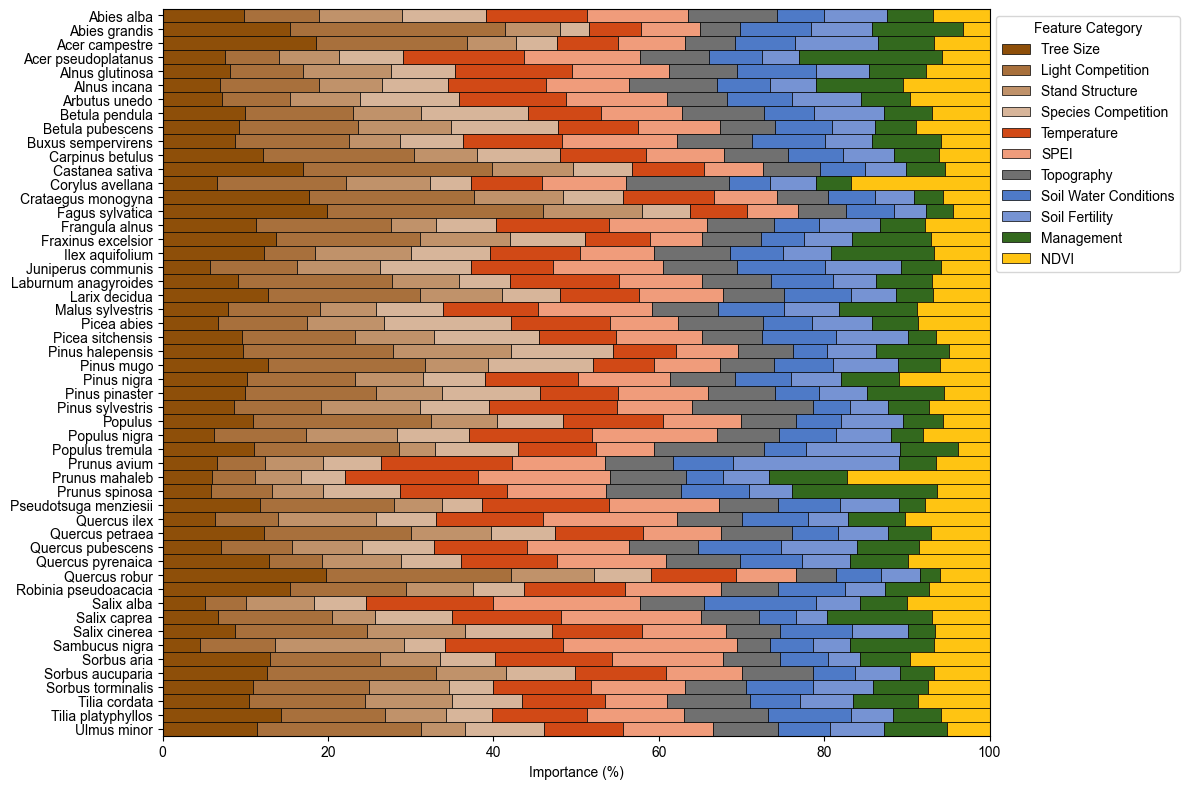

In [37]:
def get_importance_and_feat(df_in, category):

    feat = (
        idf[f"{category} - Metrics"].value_counts().index[0].split("'")[1].split("'")[0]
    )
    mean = idf[f"{category} - Importance"].dropna().values.mean().round(2)
    std = idf[f"{category} - Importance"].dropna().values.std().round(2)

    return feat, mean, std


# For supplementary table
tab_supp_features = df_filtered_raw.drop(columns=["merge_var"])

# Loop over species and change and get model performance per run
tmp_list = []
fig_list = []
for ispecies in tab_supp_features.species.unique():
    # Get idf
    idf = tab_supp_features.query("species == @ispecies")
    idf_runs = df_runs_per_species_and_group.query("species == @ispecies")
    # Safety check, not more than 50 runs
    if idf.shape[0] > 50:
        raise ValueError("🟥 More than 50 runs found")
    # Make new df
    mean_roc = idf["test_boot_mean"].values.mean().round(2)
    std_roc = idf["test_boot_mean"].values.std().round(2)
    new_df = pd.DataFrame(
        {
            "species": ispecies,
        },
        index=[0],
    )

    new_df_fig = new_df.copy()

    new_df["ROC-AUC"] = f"{mean_roc} +- {std_roc}"

    # Get mean feature importance and most common feature
    for cat in [
        "Tree Size",
        "Light Competition",
        "Stand Structure",
        "Species Competition",
        "Temperature",
        "SPEI",
        "Topography",
        "Soil Water Conditions",
        "Soil Fertility",
        "Management",
        "NDVI",
    ]:

        feat, mean, std = get_importance_and_feat(idf, cat)
        # new_df[f"{cat} METRIC"] = f"{mean} +- {std}"
        # new_df[f"{cat} FEATURE"] = f"{feat}"
        # new_df[f"{cat} FULL"] = f"{mean} +- {std} ({feat})"
        new_df[f"{cat}"] = f"{mean} +- {std} ({feat})"
        new_df_fig[f"{cat}"] = mean

    # Append
    tmp_list.append(new_df)
    fig_list.append(new_df_fig)

# Concat
tab_supp_features = pd.concat(tmp_list)
# Add total importance for scaling
# tab_supp_features["spei+temp"] = (
# tab_supp_features["mean_spei"] + tab_supp_features["mean_temp"]
# )

# Sort as in the species_change (needs to be inverted)
species_order = species_change.index

# Sort by species_order
tab_supp_features = (
    tab_supp_features.set_index("species").reindex(species_order).reset_index()
)

display(tab_supp_features.head(5))
# ! Save
tab_supp_features.to_csv(f"{dir_tables}/category_importance.csv", index=False)

# Make sure per species, the sum of all importances is 100, by scaling
df_for_import_fig = pd.concat(fig_list).set_index("species")
df_for_import_fig = df_for_import_fig.div(df_for_import_fig.sum(axis=1), axis=0) * 100
df_for_import_fig = df_for_import_fig.reset_index()
df = df_for_import_fig.copy()

species = df["species"][::-1]
categorys = df.columns[1:]  # Exclude 'species'
values = df[categorys].to_numpy()
colors_cat = {
    # Forest Dynamics
    "Tree Size": "#8e4f09",
    "Light Competition": "#a8703c",
    "Stand Structure": "#c0926a",
    "Species Competition": "#d7b59a",
    # Climate
    "Temperature": "#D14916",
    "SPEI": "#f09c7b",
    # Topography
    "Topography": "#707070",
    # Soil
    "Soil Water Conditions": "#4e7ac7",
    "Soil Fertility": "#7693d3",
    # Management
    "Management": "#33691e",
    # NDVI
    "NDVI": "#FFC412",
}


# Initialize figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define bottom for stacking
bottom = np.zeros(len(species))

# Loop through each categorys to stack the bars
for idx, category in enumerate(categorys):
    ax.barh(
        species,
        values[:, idx],
        label=category,
        left=bottom,
        color=colors_cat[category],
        edgecolor="black",
        linewidth=0.5,
        height=1,
    )
    bottom += values[:, idx]  # Update bottom for stacking

ax.legend(title="Feature Category", bbox_to_anchor=(1, 1), loc="upper left")
ax.set_ylim(-0.5, 51.45)
ax.set_xlim(0, 100)
ax.set_xlabel("Importance (%)")

plt.tight_layout()
plt.show()

In [38]:
# Summary of runs per change
# ! For all species
tmp_both = plot_pattern_dist(
    df_both_patterns, "change", dir_patterns, do_return=True
).rename(columns={"value": "group_size_rel_1"})
tmp_both["change_clean"] = tmp_both["change"].str.split(r" \(").str[0]
tmp_both["change_simple"] = tmp_both["change"].str.split(r" \(").str[0]


tmp_spei = plot_pattern_dist(
    df_spei_patterns,
    "response_spei",
    dir_patterns,
    do_return=True,
)
tmp_spei["change_simple"] = tmp_spei["response_spei"].str.split(r" \(").str[0]
tmp_spei = tmp_spei.replace("other", "other (spei)")

tmp_temp = plot_pattern_dist(
    df_temp_patterns,
    "response_temp",
    dir_patterns,
    do_return=True,
)
tmp_temp["change_simple"] = tmp_temp["response_temp"].str.split(r" \(").str[0]
tmp_temp = tmp_temp.replace("other", "other (temp)")

patterns_merged = (
    pd.concat([tmp_temp, tmp_spei, tmp_both], axis=0)
    .reset_index(drop=True)
    .rename(columns={"value": "group_size_rel"})
)

# Merge double columns for group size
patterns_merged["group_size_rel"] = (
    patterns_merged["group_size_rel"].fillna(0).astype(int)
)
patterns_merged["group_size_rel_1"] = (
    patterns_merged["group_size_rel_1"].fillna(0).astype(int)
)
patterns_merged["group_size_rel"] = (
    patterns_merged["group_size_rel"] + patterns_merged["group_size_rel_1"]
)

# Merge double columns for change description

patterns_merged = patterns_merged.drop(columns=["group_size_rel_1"])
display(patterns_merged)

# Summary of runs per change
# ! For top9 species
tmp_both = plot_pattern_dist(
    df_both_patterns.query("species in @top9"), "change", dir_patterns, do_return=True
).rename(columns={"value": "group_size_rel_1"})
tmp_both["change_clean"] = tmp_both["change"].str.split(r" \(").str[0]
tmp_both["change_simple"] = tmp_both["change"].str.split(r" \(").str[0]


tmp_spei = plot_pattern_dist(
    df_spei_patterns.query("species in @top9"),
    "response_spei",
    dir_patterns,
    do_return=True,
)
tmp_spei["change_simple"] = tmp_spei["response_spei"].str.split(r" \(").str[0]
tmp_spei = tmp_spei.replace("other", "other (spei)")

tmp_temp = plot_pattern_dist(
    df_temp_patterns.query("species in @top9"),
    "response_temp",
    dir_patterns,
    do_return=True,
)
tmp_temp["change_simple"] = tmp_temp["response_temp"].str.split(r" \(").str[0]
tmp_temp = tmp_temp.replace("other", "other (temp)")

patterns_merged_t9 = (
    pd.concat([tmp_temp, tmp_spei, tmp_both], axis=0)
    .reset_index(drop=True)
    .rename(columns={"value": "group_size_rel"})
)

# Check if all changes are present
for c in patterns_merged.change_simple.unique():
    if c not in patterns_merged_t9.change_simple.unique():
        print(f"{c} is missing, adding a row for it")
        if c == "other (temp)":
            new_row = pd.DataFrame(
                {
                    "group_size_rel": 0,
                    "change_simple": c,
                    "response_temp": "other (0%)",
                },
                index=[0],
            )

            # Insert row at third position
            patterns_merged_t9 = pd.concat(
                [patterns_merged_t9.iloc[:2], new_row, patterns_merged_t9.iloc[2:]]
            ).reset_index(drop=True)

        else:
            chime.error()
            raise ValueError(f"🟥 adding entry for '{c}' is not yet implemented!")

# Merge double columns for group size
patterns_merged_t9["group_size_rel"] = (
    patterns_merged_t9["group_size_rel"].fillna(0).astype(int)
)
patterns_merged_t9["group_size_rel_1"] = (
    patterns_merged_t9["group_size_rel_1"].fillna(0).astype(int)
)
patterns_merged_t9["group_size_rel"] = (
    patterns_merged_t9["group_size_rel"] + patterns_merged_t9["group_size_rel_1"]
)

# Merge double columns for change description
patterns_merged_t9 = patterns_merged_t9.drop(columns=["group_size_rel_1"])

patterns_merged_t9

🟥 Values do not sum up to 100% but to 101 because of rounding! Adjusting difference.
🟢 Adjusting 64 by -1 to 63.


,response_temp,group_size_rel,change_simple,response_spei,change,change_clean
0,warmer (76%),76,warmer,NaN,NaN,NaN
1,cooler (18%),18,cooler,NaN,NaN,NaN
2,other (6%),6,other (temp),NaN,NaN,NaN
3,NaN,63,drier,drier (63%),NaN,NaN
4,NaN,31,wetter,wetter (31%),NaN,NaN
5,NaN,6,other (spei),other (6%),NaN,NaN
6,NaN,51,warmer_drier,NaN,warmer_drier (51%),warmer_drier
7,NaN,22,warmer_wetter,NaN,warmer_wetter (22%),warmer_wetter
8,NaN,12,other,NaN,other (12%),other
9,NaN,8,cooler_drier,NaN,cooler_drier (8%),cooler_drier


🟥 Values do not sum up to 100% but to 99 because of rounding! Adjusting difference.
🟢 Adjusting 61 by 1 to 62.
🟥 Values do not sum up to 100% but to 101 because of rounding! Adjusting difference.
🟢 Adjusting 64 by -1 to 63.


,response_temp,group_size_rel,change_simple,response_spei,change,change_clean
0,warmer (93%),93,warmer,NaN,NaN,NaN
1,cooler (7%),7,cooler,NaN,NaN,NaN
2,other (0%),0,other (temp),NaN,NaN,NaN
3,NaN,63,drier,drier (63%),NaN,NaN
4,NaN,34,wetter,wetter (34%),NaN,NaN
5,NaN,3,other (spei),other (3%),NaN,NaN
6,NaN,62,warmer_drier,NaN,warmer_drier (62%),warmer_drier
7,NaN,31,warmer_wetter,NaN,warmer_wetter (31%),warmer_wetter
8,NaN,4,cooler_drier,NaN,cooler_drier (4%),cooler_drier
9,NaN,2,cooler_wetter,NaN,cooler_wetter (2%),cooler_wetter


In [39]:
# Get all model runs
all_dfs = df_all_concat.copy()

# Some checks
# print("Runs per model:")
# display(all_dfs["species"].sort_values().value_counts())
# display(all_dfs["subset_group"].sort_values().value_counts())

# Filter for roc_threshold
n_species = all_dfs["species"].nunique()
n_runs = 50

supposed_n_runs = n_species * n_runs
actual_n_runs = all_dfs.shape[0]
all_dfs = all_dfs.query("test_boot_mean >= @roc_threshold")
valid_n_runs = all_dfs.shape[0]

print(
    f"Total number of runs: {supposed_n_runs} = {n_species} species * {n_runs} runs per species"
)
print(f"Actual number of runs: {actual_n_runs}")
print(
    f"Number of valid runs: {valid_n_runs}, which is {valid_n_runs / supposed_n_runs * 100:.2f}% of total runs and {valid_n_runs / actual_n_runs * 100:.2f}% of actual runs"
)

# Turn character lists into literals
pd.set_option("future.no_silent_downcasting", True)
imps = [c for c in all_dfs.columns if "Importance" in c]
vals = [c for c in all_dfs.columns if "Values" in c]
metrics = [c for c in all_dfs.columns if "Metrics" in c]
for m in metrics:
    all_dfs[m] = all_dfs[m].replace({np.nan: "['NA']"})
    all_dfs[m] = all_dfs[m].apply(ast.literal_eval)
    all_dfs[m] = all_dfs[m].apply(lambda x: x[0])
    all_dfs[m] = all_dfs[m].replace({"NA": np.nan})

for i in imps:
    all_dfs[i] = all_dfs[i].astype(float)

for v in vals:
    all_dfs[v] = all_dfs[v].replace({np.nan: "['NA']"})
    all_dfs[v] = all_dfs[v].apply(ast.literal_eval)
    all_dfs[v] = all_dfs[v].apply(lambda x: x[0])
    all_dfs[v] = all_dfs[v].replace({"NA": np.nan})
    all_dfs[v] = all_dfs[v].astype(float)

display(all_dfs.head(3))

# Calculate weights of species
df_w = (
    all_dfs.groupby("species")
    .agg(
        n_runs=("subset_group", "nunique"),
        n_runs_rel=("subset_group", lambda x: x.nunique() / n_runs * 100),
    )
    .reset_index()
)
display(df_w.head(3))

Total number of runs: 2600 = 52 species * 50 runs per species
Actual number of runs: 2600
Number of valid runs: 2368, which is 91.08% of total runs and 91.08% of actual runs


,index,subset,subset_group,created,best_model_decision,N_died,N_surv,dir,oversampled_cv,oversampled_test,metric,Light Competition - Importance,Light Competition - Metrics,Light Competition - Values,Species Competition - Importance,Species Competition - Metrics,Species Competition - Values,Tree Size - Importance,Tree Size - Metrics,Tree Size - Values,Topography - Importance,Topography - Metrics,Topography - Values,SPEI - Importance,SPEI - Metrics,SPEI - Values,Temperature - Importance,Temperature - Metrics,Temperature - Values,Soil Fertility - Importance,Soil Fertility - Metrics,Soil Fertility - Values,Stand Structure - Importance,Stand Structure - Metrics,Stand Structure - Values,NDVI - Importance,NDVI - Metrics,NDVI - Values,Soil Water Conditions - Importance,Soil Water Conditions - Metrics,Soil Water Conditions - Values,Management - Importance,Management - Metrics,Management - Values,test_boot_mean,test_boot_sd,train_boot_mean,train_boot_sd,species,run
0,0,species_lat2,run_1220 (0.724),2025-02-24 19:20:06,best_per_category,780,28235,model_runs/all_runs/run_1220/Abies alba/,False,False,roc_auc,19.648595,social_status,19.648595,12.430517,competition_same_species_rel,12.430517,9.482267,htot_final,9.482267,9.257887,altitude,9.257887,8.874210,spei3-may_min,8.874210,8.739359,tmoy_win_mean_anomaly,8.739359,7.216549,pH,7.216549,6.709180,carrying_capacity,6.709180,6.284373,ndvi_min_anomaly,6.284373,6.053155,waterlogging_temp,6.053155,5.303909,mgmt_intensity,5.303909,0.724298,0.022748,0.996466,0.000152,Abies alba,1220
1,1,species_lat2,run_1221 (0.764),2025-02-24 19:40:35,best_per_category,780,28235,model_runs/all_runs/run_1221/Abies alba/,False,False,roc_auc,21.719767,social_status,21.719767,10.555606,competition_same_species_rel,10.555606,9.300270,c13_1,9.300270,6.975168,altitude,6.975168,12.827171,spei1-may_min,12.827171,6.005815,tmoy_win_mean_anomaly,6.005815,7.245565,pH,7.245565,6.267618,carrying_capacity,6.267618,2.964984,ndvi_trend,2.964984,6.193484,waterlogging_temp,6.193484,9.944551,dist_road,9.944551,0.764277,0.019306,0.995986,0.000168,Abies alba,1221
2,2,species_lat2,run_1222 (0.734),2025-02-24 18:24:04,best_per_category,780,28235,model_runs/all_runs/run_1222/Abies alba/,False,False,roc_auc,20.230940,social_status,20.230940,8.335261,competition_other_species_rel,8.335261,10.268131,c13_1,10.268131,6.760695,altitude,6.760695,12.882548,spei1-may_min,12.882547,9.026763,tmax_win_mean_anomaly,9.026763,6.674458,pH,6.674458,3.657429,competition_total,3.657429,3.645002,ndvi_min_anomaly,3.645002,7.397048,waterlogging_temp,7.397048,11.121727,dist_road,11.121727,0.733579,0.022842,0.995544,0.000177,Abies alba,1222


,species,n_runs,n_runs_rel
0,Abies alba,50,100.0
1,Abies grandis,44,88.0
2,Acer campestre,47,94.0


🚨 if the coloring is incorrect, adjust by hand in function 'ax_dataset_boxplot()' 


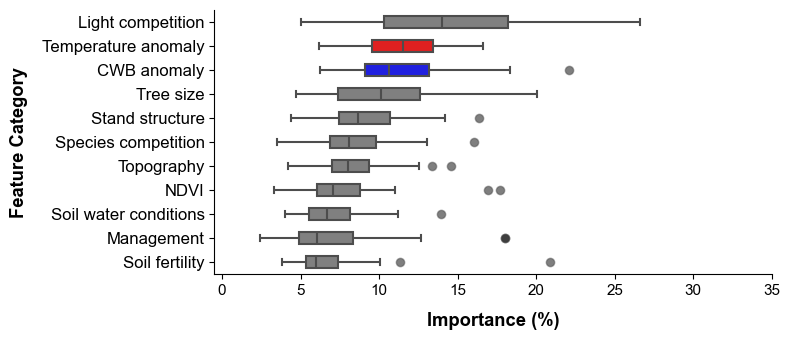

🚨 if the coloring is incorrect, adjust by hand in function 'ax_dataset_boxplot()' 


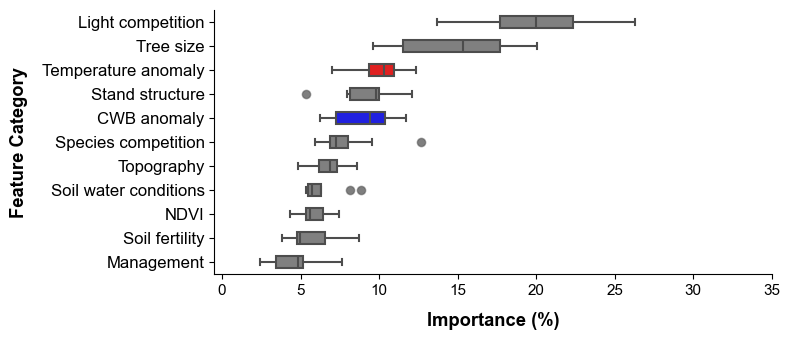

In [40]:
ax_dataset_boxplot(None, all_dfs, imps, base_fontsize=11)
ax_dataset_boxplot(None, all_dfs, imps, base_fontsize=11, all_or_top9="top9")

### Fig 2: Importance + Climate Influence


In [41]:
def analyse_importance_df(all_or_top9):

    # Get importance df
    ximp = ax_dataset_boxplot(
        None,
        all_dfs,
        imps,
        base_fontsize=11,
        all_or_top9=all_or_top9,
        return_dfimp=True,
    ).mean()

    # Get different aggregates
    imp_stand = (
        ximp["Light Competition"]
        + ximp["Species Competition"]
        + ximp["Stand Structure"]
        + ximp["Tree Size"]
    ).round(0)

    imp_climate = (ximp["Temperature"] + ximp["SPEI"]).round(2)

    imp_soil = (ximp["Soil Fertility"] + ximp["Soil Water Conditions"]).round(0)

    print(f" --- {all_or_top9} ---")
    display(ximp.round(2))
    print(f"Sum of Stand-describing variables: {imp_stand}")
    print(f"Sum of Climate-describing variables: {imp_climate}")
    print(f"Sum of Soil-describing variables: {imp_soil} \n\n ")

🚨 The order of labels may be wrong and needs to be adjusted by hand! Compare to displayed df!
 --- all ---


Light Competition        14.25
Temperature              11.59
SPEI                     11.22
Tree Size                10.61
Stand Structure           9.00
Species Competition       8.49
Topography                8.27
NDVI                      7.60
Soil Water Conditions     7.02
Management                6.98
Soil Fertility            6.66
dtype: float64

Sum of Stand-describing variables: 42.0
Sum of Climate-describing variables: 22.82
Sum of Soil-describing variables: 14.0 

 


,response_temp,group_size_rel,change_simple,response_spei,change,change_clean
0,warmer (76%),76,warmer,NaN,NaN,NaN
1,cooler (18%),18,cooler,NaN,NaN,NaN
2,other (6%),6,other (temp),NaN,NaN,NaN
3,NaN,63,drier,drier (63%),NaN,NaN
4,NaN,31,wetter,wetter (31%),NaN,NaN
5,NaN,6,other (spei),other (6%),NaN,NaN
6,NaN,51,warmer_drier,NaN,warmer_drier (51%),warmer_drier
7,NaN,22,warmer_wetter,NaN,warmer_wetter (22%),warmer_wetter
8,NaN,12,other,NaN,other (12%),other
9,NaN,8,cooler_drier,NaN,cooler_drier (8%),cooler_drier


🚨 if the coloring is incorrect, adjust by hand in function 'ax_dataset_boxplot()' 


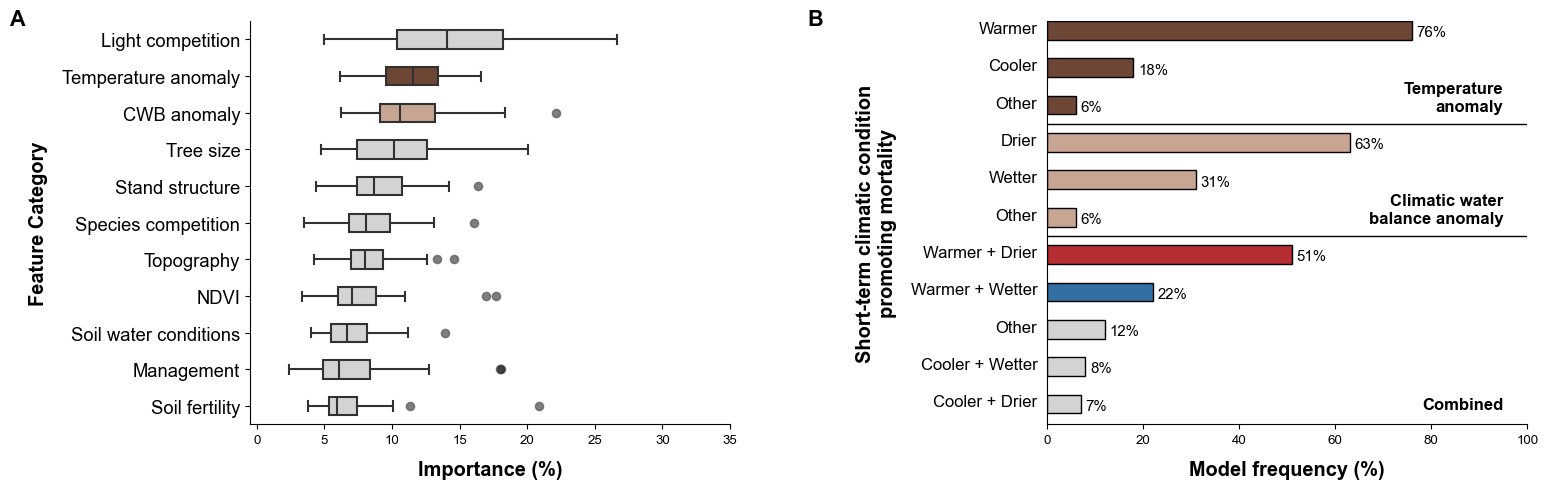

---------------------------------------------------------------------------------------------------------------------------------------
🚨 The order of labels may be wrong and needs to be adjusted by hand! Compare to displayed df!
 --- top9 ---


Light Competition        19.85
Tree Size                14.90
Temperature              10.11
Stand Structure           9.26
SPEI                      8.90
Species Competition       7.93
Topography                6.79
Soil Water Conditions     6.31
NDVI                      5.90
Soil Fertility            5.78
Management                4.49
dtype: float64

Sum of Stand-describing variables: 52.0
Sum of Climate-describing variables: 19.01
Sum of Soil-describing variables: 12.0 

 


,response_temp,group_size_rel,change_simple,response_spei,change,change_clean
0,warmer (93%),93,warmer,NaN,NaN,NaN
1,cooler (7%),7,cooler,NaN,NaN,NaN
2,other (0%),0,other (temp),NaN,NaN,NaN
3,NaN,63,drier,drier (63%),NaN,NaN
4,NaN,34,wetter,wetter (34%),NaN,NaN
5,NaN,3,other (spei),other (3%),NaN,NaN
6,NaN,62,warmer_drier,NaN,warmer_drier (62%),warmer_drier
7,NaN,31,warmer_wetter,NaN,warmer_wetter (31%),warmer_wetter
8,NaN,4,cooler_drier,NaN,cooler_drier (4%),cooler_drier
9,NaN,2,cooler_wetter,NaN,cooler_wetter (2%),cooler_wetter


🚨 if the coloring is incorrect, adjust by hand in function 'ax_dataset_boxplot()' 


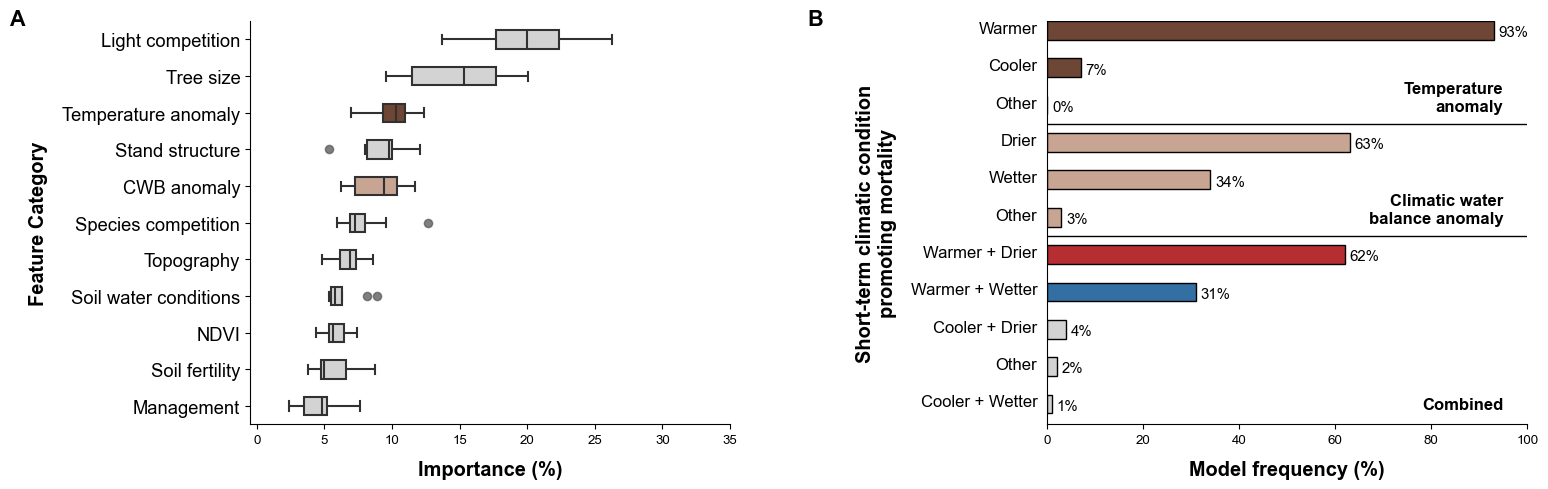

---------------------------------------------------------------------------------------------------------------------------------------


In [42]:
for all_or_top9 in ["all", "top9"]:

    filedir = f"{dir_patterns}/fig_dataset_pattern"
    os.makedirs(filedir, exist_ok=True)
    color_temp = "#77422C"
    color_spei = "#D1A289"
    color_rest = "lightgrey"
    color_wd = sns.color_palette("Reds", 3)[-1]
    color_ww = sns.color_palette("Blues", 3)[-1]
    color_other = "lightgrey"

    print(
        "🚨 The order of labels may be wrong and needs to be adjusted by hand! Compare to displayed df!"
    )

    if all_or_top9 == "all":
        tmp_in = patterns_merged.copy()
        ytick_labels = [
            "Warmer".title(),
            "Cooler".title(),
            "Other".title(),
            "Drier".title(),
            "Wetter".title(),
            "Other".title(),
            "Warmer + Drier".title(),
            "Warmer + Wetter".title(),
            "Other".title(),
            "Cooler + Wetter".title(),
            "Cooler + Drier".title(),
        ]
    else:
        tmp_in = patterns_merged_t9.copy()
        ytick_labels = [
            "Warmer".title(),
            "Cooler".title(),
            "Other".title(),
            "Drier".title(),
            "Wetter".title(),
            "Other".title(),
            "Warmer + Drier".title(),
            "Warmer + Wetter".title(),
            "Cooler + Drier".title(),
            "Other".title(),
            "Cooler + Wetter".title(),
        ]

    analyse_importance_df(all_or_top9)
    display(tmp_in)

    plot_bars_dataset_pattern(
        tmp_in,
        all_dfs,
        all_or_top9=all_or_top9,
        color_temp=color_temp,
        color_spei=color_spei,
        color_rest=color_rest,
        color_wd=color_wd,
        color_ww=color_ww,
        color_other=color_other,
        filepath=f"{filedir}/{all_or_top9}.png",
        # filepath=None,
        ytick_labels=ytick_labels,
    )
    print(
        f"---------------------------------------------------------------------------------------------------------------------------------------"
    )

### Multi Barplot


In [43]:
# Get change labels
# ! All
change_labels = []

for c in change_dict.keys():
    _perc = (
        patterns_merged.query("change_simple == @c").loc[:, "group_size_rel"].values[0]
    )
    change_labels.append(f'{c.replace("_", " + ")} ({_perc}%)')
display(change_labels)

# ! Top 9
change_labels_t9 = []
for c in change_dict.keys():
    _perc = (
        patterns_merged_t9.query("change_simple == @c")
        .loc[:, "group_size_rel"]
        .values[0]
    )
    change_labels_t9.append(f'{c.replace("_", " + ")} ({_perc}%)')
display(change_labels_t9)

['warmer + drier (51%)',
 'cooler + drier (8%)',
 'other (12%)',
 'cooler + wetter (7%)',
 'warmer + wetter (22%)']

['warmer + drier (62%)',
 'cooler + drier (4%)',
 'other (1%)',
 'cooler + wetter (2%)',
 'warmer + wetter (31%)']

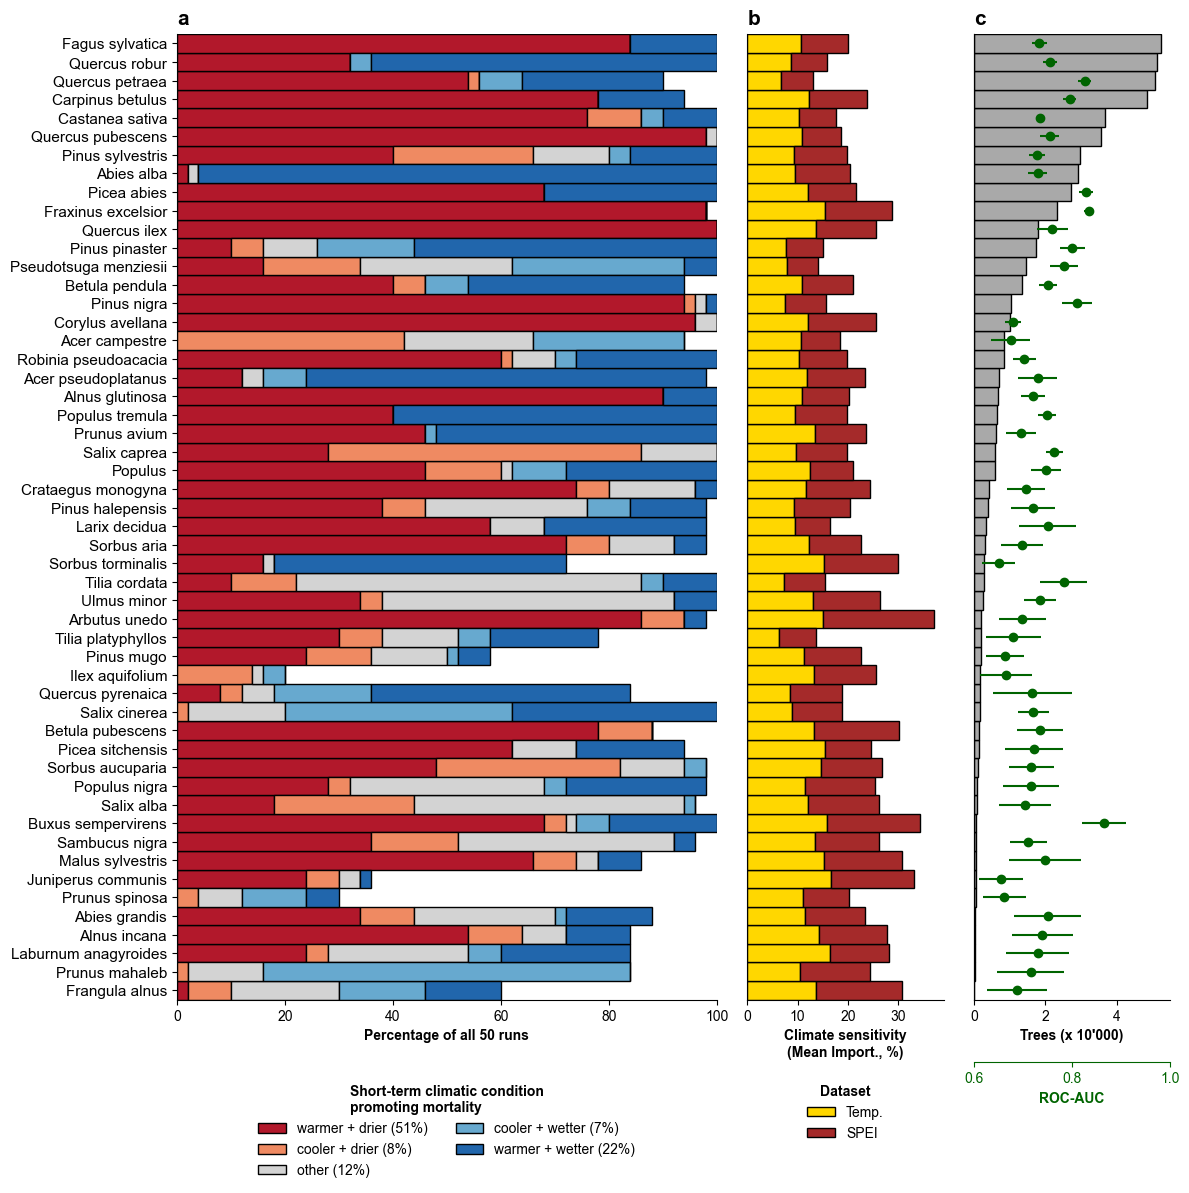

In [44]:
# Plotting
df_plot_tmp = df_plot_from_mulitplot.copy()

fig, (ax0, ax2, ax1) = plt.subplots(
    1, 3, figsize=(12, 12), gridspec_kw={"width_ratios": [2.75, 1, 1]}
)

# ! PLOT: Change bar chart
if not normalized_change_chart:
    for change in change_order:
        df_plot_tmp[change] = df_plot_tmp[change].copy() / n_all_runs * 100

species = df_plot_tmp.species
changes = change_order
values = 0
bottom = None
for change, color in zip(changes, change_colors):
    values = df_plot_tmp[change].copy()
    ax0.barh(
        species,
        values,
        left=bottom,
        label=change,
        color=color,
        height=1,
        edgecolor="black",
    )
    if bottom is None:
        bottom = values
    else:
        bottom += values

# Adding title and labels
if normalized_change_chart:
    xlab = "Percentage of valid runs (%)"
else:
    # xlab = f"Percentage of all {n_all_runs} runs (%)"
    xlab = f"Percentage of all {n_all_runs} runs"

ax0.set_xlabel(xlab, weight="bold")
ax0.set_ylabel("")
ax0.legend(
    labels=change_labels,
    bbox_to_anchor=(0.5, -0.075),
    loc="upper center",
    ncol=2,
    frameon=False,
).set_title(
    title="Short-term climatic condition\npromoting mortality", prop={"weight": "bold"}
)

# Adjust ticks size
ax0.tick_params(axis="y", which="major", labelsize=11)

# Add dotted line at 50
# ax0.axvline(x=50, color="lightgrey", linestyle="--", linewidth=0.75)

# ! PLOT: Valid runs and ROC-AUC
# Bar chart for n_runs
if bars_in_double_chart == "ntrees":
    if ntrees_log:
        xbars = np.log10(df_plot_tmp["n_trees_total"].copy())
        xlab = "$\it{N}$ Trees ($10^x$)"
    else:
        xbars = df_plot_tmp["n_trees_total"].copy() / 10000
        # xlab = "$\it{N}$ Trees (x 10'000)"
        xlab = "Trees (x 10'000)"
elif bars_in_double_chart == "nruns":
    xbars = df_plot_tmp["n_runs"].copy()
    xlab = "$\it{N}$ Runs"
else:
    chime.error()
    raise ValueError("🟥 bars_in_double_chart not recognized")

ax1.barh(
    df_plot_tmp["species"],
    xbars,
    color="darkgrey",
    edgecolor="black",
    height=1,
    # alpha=0.8,
)
ax1.set_xlabel(xlab, weight="bold")

# Point chart for mean_roc with error bars for std_roc
ax1_2 = ax1.twiny()
ax1_2.errorbar(
    df_plot_tmp["mean_roc"],
    df_plot_tmp["species"],
    xerr=df_plot_tmp["std_roc"],
    fmt="o",
    color="darkgreen",
    ecolor="darkgreen",
    capsize=0,
)

ax1_2.set_xlabel("ROC-AUC", color="darkgreen", weight="bold")
ax1_2.set_xlim(0.6, 1)
ax1_2.tick_params(axis="x", colors="darkgreen")

# Adjust the position of the secondary x-axis
ax1_2.spines["bottom"].set_position(("outward", 45))
ax1_2.xaxis.set_ticks_position("bottom")
ax1_2.xaxis.set_label_position("bottom")

# Set the ticks and labels for the secondary x-axis
ax1_2.set_xticks([0.6, 0.8, 1.0])
ax1_2.set_xticklabels([0.6, 0.8, 1.0])

# Color the second axis in darkgreen
ax1_2.spines["bottom"].set_color("darkgreen")
ax1_2.xaxis.label.set_color("darkgreen")
ax1_2.tick_params(axis="x", colors="darkgreen")

# Hide the original top spine
# ax1_2.spines["top"].set_visible(False)
# ax1.spines["top"].set_visible(False)

# Move y axis to the right
ax1.yaxis.tick_right()

# ! PLOT: Plotting the stacked bars
if normalized_import_chart:
    df_plot_tmp["mean_temp"] = df_plot_tmp["mean_temp"] / df_plot_tmp["spei+temp"] * 100
    df_plot_tmp["mean_spei"] = df_plot_tmp["mean_spei"] / df_plot_tmp["spei+temp"] * 100


ax2.barh(
    df_plot_tmp["species"],
    df_plot_tmp["mean_temp"],
    height=1,
    color="gold",
    edgecolor="black",
    label="Temp.",
)
ax2.barh(
    df_plot_tmp["species"],
    df_plot_tmp["mean_spei"],
    left=df_plot_tmp["mean_temp"],
    height=1,
    color="brown",
    edgecolor="black",
    label="SPEI",
)

# Adding labels, legend, and title
ax2.set_xlabel("Climate sensitivity\n(Mean Import., %)", weight="bold")
ax2.set_ylabel("")
# ax2.set_title("Mean SPEI and Mean Temperature by Species")
ax2.legend(
    # For having it to the right
    # bbox_to_anchor=(1, 1),
    # loc="best",
    # ncol=1,
    frameon=False,
    # For having it below:
    bbox_to_anchor=(0.5, -0.075),
    loc="upper center",
    # ncol=len(changes),
    ncol=1,
).set_title(title="Dataset", prop={"weight": "bold"})

# Put y axis on right
# ax2.yaxis.tick_right()
# Remove y axis
# ax2.set_ylabel()
ax2.yaxis.set_ticks([])
ax1_2.yaxis.set_ticks([])

# Remove all right and top spines
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1_2.spines["right"].set_visible(False)
ax1_2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Adjust y-limits to remove extra white space
ax0.set_ylim(-0.5, len(species) - 0.5)
ax1.set_ylim(-0.5, len(species) - 0.5)
ax2.set_ylim(-0.5, len(species) - 0.5)

# Add letters to subplots
ax0.text(0, 1.01, "a", transform=ax0.transAxes, size=15, weight="bold")
ax1.text(0, 1.01, "c", transform=ax1.transAxes, size=15, weight="bold")
ax2.text(0, 1.01, "b", transform=ax2.transAxes, size=15, weight="bold")

# Adjust layout and display
plt.tight_layout()
# plt.savefig(
#     f"{dir_patterns}/01-multi_bar_response_patterns-all_species-sort_by_{sort_by}.png"
# )
plt.show()

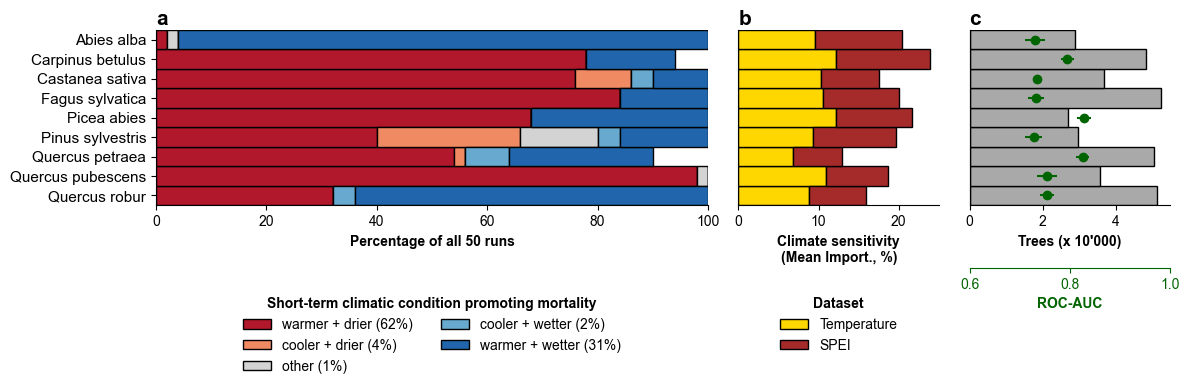

In [45]:
# Plotting
df_plot_tmp = df_plot.copy()
df_plot_tmp = df_plot_tmp.query("species in @top9").reset_index(drop=True).copy()

fig, (ax0, ax2, ax1) = plt.subplots(
    1, 3, figsize=(12, 5), gridspec_kw={"width_ratios": [2.75, 1, 1]}
)

# ! PLOT: Change bar chart
if not normalized_change_chart:
    for change in change_order:
        df_plot_tmp[change] = df_plot_tmp[change].copy() / n_all_runs * 100

species = df_plot_tmp.species
changes = change_order
values = 0
bottom = None
for change, color in zip(changes, change_colors):
    values = df_plot_tmp[change].copy()
    ax0.barh(
        species,
        values,
        left=bottom,
        label=change,
        color=color,
        height=1,
        edgecolor="black",
    )
    if bottom is None:
        bottom = values
    else:
        bottom += values

# Adding title and labels
if normalized_change_chart:
    xlab = "Percentage of valid runs (%)"
else:
    # xlab = f"Percentage of all {n_all_runs} runs (%)"
    xlab = f"Percentage of all {n_all_runs} runs"

ax0.set_xlabel(xlab, weight="bold")
ax0.set_ylabel("")
ax0.legend(
    labels=change_labels_t9,
    bbox_to_anchor=(0.5, -0.45),
    loc="upper center",
    ncol=2,
    frameon=False,
    # ).set_title(title="Condition Increasing Mortality", prop={"weight": "bold"})
).set_title(
    title="Short-term climatic condition promoting mortality", prop={"weight": "bold"}
)

# Adjust ticks size
ax0.tick_params(axis="y", which="major", labelsize=11)

# Add dotted line at 50
# ax0.axvline(x=50, color="lightgrey", linestyle="--", linewidth=0.75)

# ! PLOT: Valid runs and ROC-AUC
# Bar chart for n_runs
if bars_in_double_chart == "ntrees":
    if ntrees_log:
        xbars = np.log10(df_plot_tmp["n_trees_total"].copy())
        xlab = "$\it{N}$ Trees ($10^x$)"
    else:
        xbars = df_plot_tmp["n_trees_total"].copy() / 10000
        # xlab = "$\it{N}$ Trees (x 10'000)"
        xlab = "Trees (x 10'000)"
elif bars_in_double_chart == "nruns":
    xbars = df_plot_tmp["n_runs"].copy()
    xlab = "$\it{N}$ Runs"
else:
    chime.error()
    raise ValueError("🟥 bars_in_double_chart not recognized")

ax1.barh(
    df_plot_tmp["species"],
    xbars,
    color="darkgrey",
    edgecolor="black",
    height=1,
    # alpha=0.8,
)
ax1.set_xlabel(xlab, weight="bold")

# Point chart for mean_roc with error bars for std_roc
ax1_2 = ax1.twiny()
ax1_2.errorbar(
    df_plot_tmp["mean_roc"],
    df_plot_tmp["species"],
    xerr=df_plot_tmp["std_roc"],
    fmt="o",
    color="darkgreen",
    ecolor="darkgreen",
    capsize=0,
)

ax1_2.set_xlabel("ROC-AUC", color="darkgreen", weight="bold")
ax1_2.set_xlim(0.6, 1)
ax1_2.tick_params(axis="x", colors="darkgreen")

# Adjust the position of the secondary x-axis
ax1_2.spines["bottom"].set_position(("outward", 45))
ax1_2.xaxis.set_ticks_position("bottom")
ax1_2.xaxis.set_label_position("bottom")

# Set the ticks and labels for the secondary x-axis
ax1_2.set_xticks([0.6, 0.8, 1.0])
ax1_2.set_xticklabels([0.6, 0.8, 1.0])

# Color the second axis in darkgreen
ax1_2.spines["bottom"].set_color("darkgreen")
ax1_2.xaxis.label.set_color("darkgreen")
ax1_2.tick_params(axis="x", colors="darkgreen")

# Hide the original top spine
# ax1_2.spines["top"].set_visible(False)
# ax1.spines["top"].set_visible(False)

# Move y axis to the right
ax1.yaxis.tick_right()

# ! PLOT: Climate Sensitivity
if normalized_import_chart:
    df_plot_tmp["mean_temp"] = df_plot_tmp["mean_temp"] / df_plot_tmp["spei+temp"] * 100
    df_plot_tmp["mean_spei"] = df_plot_tmp["mean_spei"] / df_plot_tmp["spei+temp"] * 100


ax2.barh(
    df_plot_tmp["species"],
    df_plot_tmp["mean_temp"],
    height=1,
    color="gold",
    edgecolor="black",
    label="Temperature",
)
ax2.barh(
    df_plot_tmp["species"],
    df_plot_tmp["mean_spei"],
    left=df_plot_tmp["mean_temp"],
    height=1,
    color="brown",
    edgecolor="black",
    label="SPEI",
)

# Adding labels, legend, and title
ax2.set_xlabel("Climate sensitivity\n(Mean Import., %)", weight="bold")
ax2.set_ylabel("")
# ax2.set_title("Mean SPEI and Mean Temperature by Species")
ax2.legend(
    # For having it to the right
    # bbox_to_anchor=(1, 1),
    # loc="best",
    # ncol=1,
    frameon=False,
    # For having it below:
    bbox_to_anchor=(0.5, -0.45),
    loc="upper center",
    # ncol=len(changes),
    ncol=1,
).set_title(title="Dataset", prop={"weight": "bold"})

# Put y axis on right
# ax2.yaxis.tick_right()
# Remove y axis
# ax2.set_ylabel()
ax2.yaxis.set_ticks([])
ax1_2.yaxis.set_ticks([])

# Remove all right and top spines
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1_2.spines["right"].set_visible(False)
ax1_2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Adjust y-limits to remove extra white space
ax0.set_ylim(-0.5, len(species) - 0.5)
ax1.set_ylim(-0.5, len(species) - 0.5)
ax2.set_ylim(-0.5, len(species) - 0.5)

# Add letters to subplots
ax0.text(0, 1.03, "a", transform=ax0.transAxes, size=15, weight="bold")
ax1.text(0, 1.03, "c", transform=ax1.transAxes, size=15, weight="bold")
ax2.text(0, 1.03, "b", transform=ax2.transAxes, size=15, weight="bold")

# Adjust layout and display
plt.tight_layout()
# plt.savefig(
#     f"{dir_patterns}/01-multi_bar_response_patterns-top9_species-sort_by_{sort_by}.png"
# )
plt.show()

### Climate Feature per Species


In [46]:
# # ! Settings ------------------------------
pd.set_option("display.max_colwidth", 100000)

# tmp_specs = ["Quercus robur", "Quercus petraea", "Quercus ilex", "Quercus pubescens"]
# tmp_specs = ["Abies alba", "Picea abies", "Pinus sylvestris"]
# tmp_specs = top9
# tmp_specs = top9 + ["Quercus ilex"]
tmp_specs = all_species

# ! SPEI ------------------------------
df_tmp = df_occ_spei.query("species in @tmp_specs")[
    [
        "species",
        "change_perc",
        "spei_duration_simple",
        "spei_anom",
        "spei_season",
        # "best_spei_simpler",
        # "spei_simpler",
        # "best_feature_spei",
        "feature_spei",
    ]
]

# Get index for fuzzy matching change
df_tmp_drier = df_tmp.query(
    "change_perc.str.contains('drier', case=False)", engine="python"
)
df_tmp_wetter = df_tmp.query(
    "change_perc.str.contains('wetter', case=False)", engine="python"
)

df_tmp_other = df_tmp.query(
    "change_perc.str.contains('other', case=False)", engine="python"
)

df_tmp_all = pd.concat([df_tmp_drier, df_tmp_wetter, df_tmp_other], axis=0).reset_index(
    drop=True
)

# Save only if all species were selected
if tmp_specs == all_species:
    df_tmp_all.to_csv(f"{dir_tables}/spei_features_all_species.csv", index=False)

display(df_tmp_all)

# ! TEMP ------------------------------
df_tmp = df_occ_temp.query("species in @tmp_specs")[
    [
        "species",
        "change_perc",
        "temp_metric",
        "temp_anom",
        "temp_season",
        # "best_spei_simpler",
        # "spei_simpler",
        # "best_feature_spei",
        "feature_temp",
    ]
]

# Get index for fuzzy matching change
df_tmp_warmer = df_tmp.query(
    "species in @tmp_specs and change_perc.str.contains('warmer', case=False)",
    engine="python",
)
df_tmp_cooler = df_tmp.query(
    "species in @tmp_specs and change_perc.str.contains('cooler', case=False)",
    engine="python",
)

df_tmp_other = df_tmp.query(
    "species in @tmp_specs and change_perc.str.contains('other', case=False)",
    engine="python",
)

df_tmp_all = pd.concat(
    [df_tmp_warmer, df_tmp_cooler, df_tmp_other], axis=0
).reset_index(drop=True)

# Save only if all species were selected
if tmp_specs == all_species:
    df_tmp_all.to_csv(f"{dir_tables}/temp_features_all_species.csv", index=False)

df_tmp_all

,species,change_perc,spei_duration_simple,spei_anom,spei_season,feature_spei
0,Fagus sylvatica,drier (84%),"short (64%), long (29%), medium (7%)","max (57%), min (29%), mean (14%)","sum (55%), win (17%), aut (14%), spr (14%)","spei3-sum_max (24%), spei21-win_min (17%), spei1-spr_max (14%), spei1-sum_mean (14%), spei1-sum_max (12%), spei18-aut_min (7%), spei9-aut_max (7%), spei15-sum_min (2%), spei24-sum_min (2%)"
1,Quercus robur,drier (32%),"short (56%), medium (38%), long (6%)","mean (50%), min (38%), max (12%)","sum (50%), aut (44%), win (6%)","spei3-sum_mean (44%), spei12-aut_min (31%), spei1-sum_mean (6%), spei12-win_max (6%), spei18-aut_min (6%), spei3-aut_max (6%)"
2,Quercus petraea,drier (56%),"medium (50%), short (39%), long (11%)","min (54%), mean (32%), max (14%)","sum (43%), win (43%), aut (14%)","spei9-win_min (32%), spei1-sum_max (11%), spei1-sum_mean (11%), spei3-sum_mean (11%), spei18-sum_min (7%), spei3-win_min (7%), spei6-aut_mean (7%), spei18-aut_min (4%), spei6-aut_min (4%), spei6-sum_max (4%), spei9-win_mean (4%)"
3,Carpinus betulus,drier (78%),"short (62%), medium (28%), long (10%)","mean (79%), min (13%), max (8%)","sum (62%), aut (26%), win (13%)","spei1-sum_mean (41%), spei6-aut_mean (23%), spei3-sum_mean (13%), spei21-win_min (10%), spei1-sum_max (8%), spei6-aut_min (3%), spei9-win_mean (3%)"
4,Castanea sativa,drier (86%),"short (65%), medium (28%), long (7%)","mean (65%), min (21%), max (14%)","sum (65%), win (16%), spr (12%), aut (7%)","spei1-sum_mean (60%), spei9-win_min (14%), spei12-spr_max (12%), spei24-aut_min (7%), spei3-sum_mean (5%), spei9-win_max (2%)"
...,...,...,...,...,...,...
113,Abies grandis,other (22%),"long (89%), medium (11%)",min (100%),"win (89%), spr (11%)","spei15-win_min (89%), spei6-spr_min (11%)"
114,Alnus incana,other (8%),medium (100%),max (100%),spr (100%),spei6-spr_max (100%)
115,Laburnum anagyroides,other (16%),"medium (50%), long (25%), short (25%)","max (50%), mean (50%)","aut (50%), sum (25%), win (25%)","spei1-aut_max (25%), spei18-sum_max (25%), spei6-win_mean (25%), spei9-aut_mean (25%)"
116,Prunus mahaleb,other (4%),short (100%),mean (100%),spr (100%),spei1-spr_mean (100%)


,species,change_perc,temp_metric,temp_anom,temp_season,feature_temp
0,Fagus sylvatica,warmer (100%),"max (56%), mean (22%), min (22%)","mean (56%), min (44%)","win (58%), spr (42%)","max_win_mean_anomaly (52%), min_spr_min_anomaly (20%), mean_spr_min_anomaly (18%), max_spr_min_anomaly (4%), mean_win_mean_anomaly (4%), min_win_min_anomaly (2%)"
1,Quercus robur,warmer (96%),"mean (65%), max (31%), min (4%)","min (83%), mean (17%)","spr (77%), win (23%)","mean_spr_min_anomaly (54%), max_spr_min_anomaly (23%), mean_win_mean_anomaly (10%), max_win_min_anomaly (6%), min_win_mean_anomaly (4%), max_win_mean_anomaly (2%)"
2,Quercus petraea,warmer (80%),"mean (55%), max (40%), min (5%)",mean (100%),"sum (45%), win (45%), spr (10%)","max_sum_mean_anomaly (30%), mean_win_mean_anomaly (30%), mean_sum_mean_anomaly (15%), max_win_mean_anomaly (10%), mean_spr_mean_anomaly (10%), min_win_mean_anomaly (5%)"
3,Carpinus betulus,warmer (94%),"mean (43%), max (34%), min (23%)","min (57%), mean (43%)","spr (55%), win (36%), sum (9%)","mean_spr_min_anomaly (28%), max_win_mean_anomaly (26%), min_spr_min_anomaly (19%), mean_win_mean_anomaly (11%), max_spr_min_anomaly (6%), min_sum_min_anomaly (4%), max_sum_mean_anomaly (2%), mean_spr_mean_anomaly (2%), mean_sum_mean_anomaly (2%)"
4,Castanea sativa,warmer (86%),"min (60%), max (33%), mean (7%)",min (100%),spr (100%),"min_spr_min_anomaly (60%), max_spr_min_anomaly (33%), mean_spr_min_anomaly (7%)"
...,...,...,...,...,...,...
106,Juniperus communis,other (2%),max (100%),max (100%),sum (100%),max_sum_max_anomaly (100%)
107,Prunus spinosa,other (2%),min (100%),mean (100%),aut (100%),min_aut_mean_anomaly (100%)
108,Laburnum anagyroides,other (12%),max (100%),max (100%),win (100%),max_win_max_anomaly (100%)
109,Prunus mahaleb,other (10%),mean (100%),max (100%),win (100%),mean_win_max_anomaly (100%)


## Feature Occurrence


In [47]:
# Get all datasets
df_filtered = all_dfs.copy()

# Add run count
df_filtered = df_filtered.merge(df_w, on="species", how="left")

# Merge species and run into one variable
df_filtered["species"] = df_filtered["species"] + " - " + df_filtered["subset_group"]

all_datasets = [
    "Tree Size",
    "Light Competition",
    "Stand Structure",
    "Species Competition",
    "Temperature",
    "SPEI",
    "Topography",
    "Soil Water Conditions",
    "Soil Fertility",
    "Management",
    "NDVI",
]

# Remove SPEI and Temp because too many levels
all_datasets = [i for i in all_datasets if "SPEI" not in i and "Temperature" not in i]

# Set index
df_filtered = df_filtered.set_index("species")

# Get number of valid models
n_valid_models = df_filtered.shape[0]

# Initiate lists
dic_values = {}
dic_counts = {}
dic_preds = {}

# Loop through all datasets
for d in all_datasets:
    # Get dataset subset and remove NA values
    d_vars = df_filtered.filter(regex=d, axis=1).columns.tolist()
    df_i = df_filtered[d_vars + ["n_runs"]].dropna()

    # Initiate list
    dataset_features = []

    # Loop over all species
    for i, species in enumerate(df_i.index):

        # Set species
        df_i["Species"] = species

        # Get metrics and values of dataset
        imetrics = df_i.loc[species][f"{d} - Metrics"]
        ivalues = df_i.loc[species][f"{d} - Values"]

        imetrics = [imetrics]
        ivalues = [ivalues]

        # Get run count
        iruns = df_i.loc[species]["n_runs"]

        # Turn string into literal
        # imetrics = ast.literal_eval(imetrics)
        # ivalues = ast.literal_eval(ivalues)
        # Loop over spei metrics

        for j, jmetric in enumerate(imetrics):
            # Check if metric is already in dictionary
            if jmetric not in dic_values:
                dic_values[jmetric] = []
                dic_counts[jmetric] = 0

            # Attach value to dictionary
            dic_values[jmetric].append(ivalues[j])
            # Add count to dictionary
            # if method_scaling_importance == "sum":
            #     addit = 1
            # elif method_scaling_importance == "scaled_valid":
            #     addit = 1 / iruns
            # elif method_scaling_importance == "scaled_all":
            #     addit = 1 / n_runs
            # else:
            #     chime.error()
            #     raise ValueError(
            #         f"🟥 method_scaling_importance not recognized: {method_scaling_importance}"
            #     )
            addit = 1
            dic_counts[jmetric] += addit

            # Attach metric to dictionary
            dataset_features.append(jmetric)

    # Remove metric duplicates
    dataset_features = list(set(dataset_features))
    # Attach to dictionary
    dic_preds[d] = dataset_features

# dic
# display(dic_preds)
# display(dic_counts)

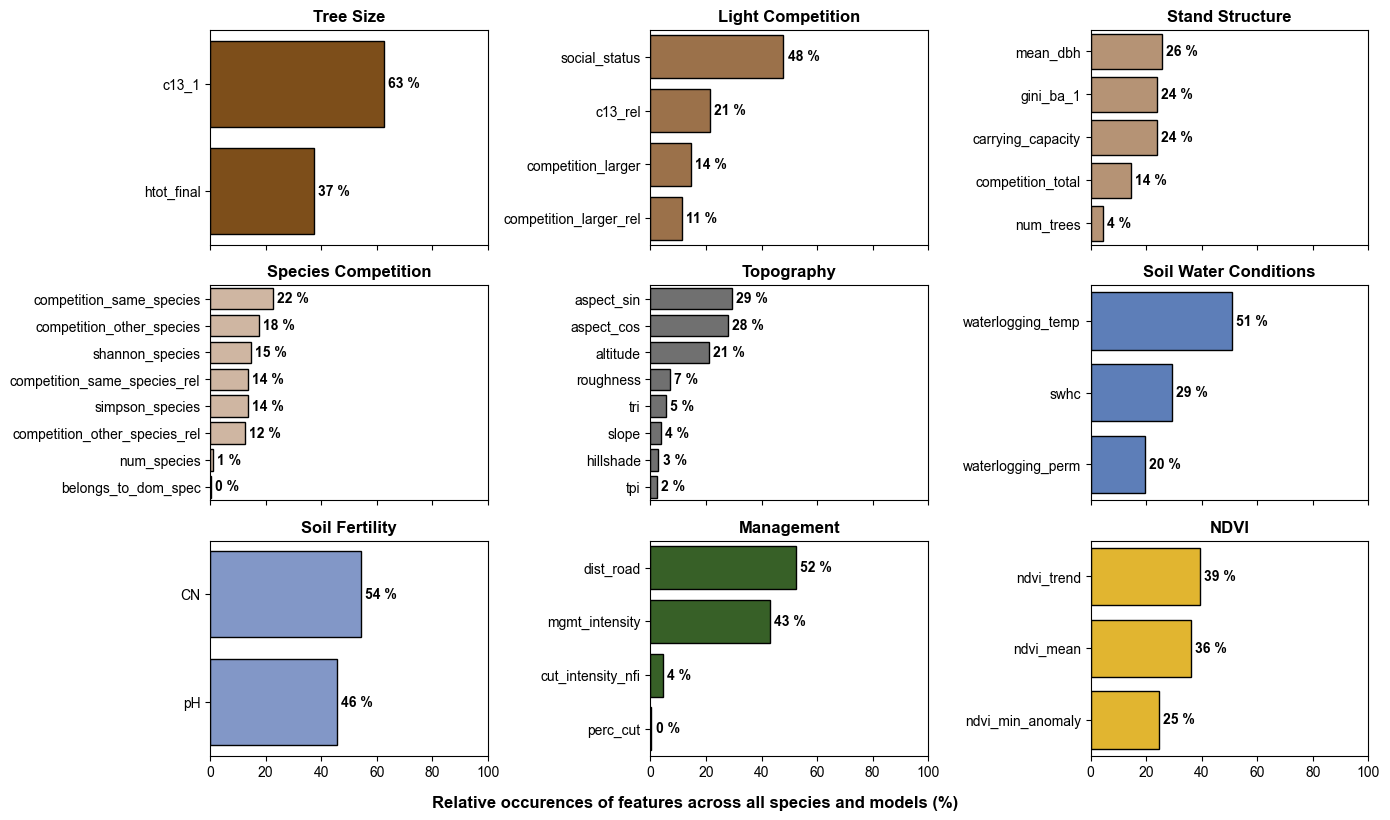

In [48]:
# Turn dictionary into dataframe
df_counts = []
for k in dic_counts.keys():
    df_counts.append(pd.DataFrame({k: dic_counts[k]}, index=[0]))
df_counts = pd.concat(df_counts, axis=1).T[0]

# Round values to 0 decimals
for i, n in enumerate(df_counts):
    n = round(n, 2)
    df_counts.iloc[i] = n

# Order dic_preds by order from above
order_l = list(colors_cat.keys())
# Remove Temperature and SPEI because too many levels
order_l.remove("SPEI")
order_l.remove("Temperature")
dic_ord = {order_l[i]: dic_preds[order_l[i]] for i in range(len(order_l))}

# ! Counts plot
# Create a 2x6 grid of subplots
fig, axs = plt.subplots(
    3,
    3,
    figsize=(14, 8),
    sharex=True,
    # sharey=True,
)

# Flatten the axs array
axs = axs.flatten()

# Loop over each axis
for i, ax in enumerate(axs):
    # Check if i is smaller than the number of datasets
    if i < len(dic_ord.keys()):
        # Get variables of that dataset
        cat = list(dic_ord.keys())[i]
        df_i = df_counts[dic_ord[cat]].sort_values(ascending=False)
        df_i = df_i / n_valid_models * 100
        df_i = df_i.round(2)
        # Create barplot
        sns.barplot(
            data=df_i, ax=ax, orient="h", edgecolor="black", color=colors_cat[cat]
        )  # Colors is from the category importance stack barchart
        # Add labels
        ax.bar_label(
            ax.containers[0],
            label_type="edge",
            fontsize=10,
            padding=3,
            fontweight="bold",
            labels=[f"{i:.0f} %" for i in df_i],
        )
        # ax.set_xlabel("Number of Occurrences (weighted by number of valid runs)")
        # Set title
        ax.set_title(list(dic_ord.keys())[i], weight="bold")
        # ax.set_xlim(0, df_counts.max().max() * 1.25)
        ax.set_xlim(0, 100)
        ax.set_xlabel("")
    else:
        # Remove axis
        ax.remove()


if method_scaling_importance == "sum":
    xlab = f"Total occurences of feature across all models and species (%) "  # (N = {supposed_n_runs})"
elif method_scaling_importance == "scaled_valid":
    xlab = f"Relative occurences of feature weighted by all runs per species (%) "  # (N = {n_runs}, %)"
elif method_scaling_importance == "scaled_all":
    xlab = f"Relative occurences of feature weighted by valid runs per species (%)"
else:
    chime.error()
    raise ValueError(
        f"🟥 method_scaling_importance not recognized: {method_scaling_importance}"
    )

xlab = "Relative occurences of features across all species and models (%)"

# Give x label
fig.text(
    0.5,
    -0.01,
    xlab,
    ha="center",
    va="center",
    rotation="horizontal",
    fontsize=12,
    weight="bold",
)
plt.tight_layout()
os.makedirs(f"{dir_patterns}/feature_counts", exist_ok=True)
plt.savefig(f"{dir_patterns}/feature_counts/feature_counts.png")
plt.show()
plt.close()

## Pie Charts


### Data


In [49]:
# Imports
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# Data
df_for_pie_charts_single_temp = df_for_pie_charts.drop(columns=["change"]).rename(
    columns={"response_temp": "change"}
)
df_for_pie_charts_single_spei = df_for_pie_charts.drop(columns=["change"]).rename(
    columns={"response_spei": "change"}
)

# Other
dir_pie = f"{dir_patterns}/pie_charts"

### Functions


In [50]:
def get_pie_heatmap_data(
    change,
    temp_or_spei,
    tempy="anom",
    verbose=False,
    df_double_change=None,
    df_single_change=None,
    method_scaling_importance="scaled_valid",
):

    if "_" in change:
        df = df_double_change.copy()
    else:
        df = df_single_change.copy()

    if temp_or_spei == "spei":
        # Get a heatmap version that holds anomaly information
        test = df.copy()
        test["spei_dur_season"] = (
            test["spei_duration"].astype(str) + "_" + test["spei_season"]
        )

        test = get_spei_table(
            df=test,
            select_change=change,
            x_var="spei_dur_season",
            x_var_order=test["spei_dur_season"].unique(),
            y_var="spei_anom",
            y_var_order=["max", "min", "mean"],
            round_decimals=False,
            method_scaling_importance=method_scaling_importance,
        ).T

        # Normalize per row
        test = test.div(test.sum(axis=1), axis=0)
        if verbose:
            display(test)

        # Get heatmap to be plotted
        df_heatmap = get_spei_table(
            df=df,
            select_change=change,
            y_var="spei_duration",
            y_var_order=[1, 3, 6, 9, 12, 15, 18, 21, 24],
            # y_var_order=[24, 21, 18, 15, 12, 9, 6, 3, 1],
            x_var="spei_season",
            x_var_order=["win", "spr", "sum", "aut"],
            # x_var_order=["aut", "sum", "spr", "win"],
            method_scaling_importance=method_scaling_importance,
        )
        if verbose:
            display(df_heatmap)

        # Merge heatmap and anomaly information
        df_heatmap_long = df_heatmap.reset_index().melt(
            id_vars="spei_duration", var_name="spei_season", value_name="value"
        )
        df_heatmap_long["spei_dur_season"] = (
            df_heatmap_long["spei_duration"].astype(str)
            + "_"
            + df_heatmap_long["spei_season"]
        )
        test = df_heatmap_long.merge(test, on="spei_dur_season")

        test["size"] = test["value"]

        test = test[
            ["spei_duration", "spei_season", "value", "size", "max", "min", "mean"]
        ]
        # test.to_clipboard(index=False)
        if verbose:
            display(test)
    elif temp_or_spei == "temp":

        if tempy == "anom":
            tempy = "temp_anom"
            tempz = "temp_metric"
        elif tempy == "metric":
            tempy = "temp_metric"
            tempz = "temp_anom"
        else:
            raise ValueError(f"🟥 tempy not recognized: {tempy}")

        # Get a heatmap version that holds anomaly information
        test = df.copy()
        test[f"{tempy}_season"] = (
            test[f"{tempy}"].astype(str) + "_" + test["temp_season"]
        )

        test = get_spei_table(
            df=test,
            select_change=change,
            x_var=f"{tempy}_season",
            x_var_order=test[f"{tempy}_season"].unique(),
            y_var=f"{tempz}",
            y_var_order=["max", "min", "mean"],
            round_decimals=False,
            method_scaling_importance=method_scaling_importance,
        ).T

        # Normalize per row
        test = test.div(test.sum(axis=1), axis=0)
        if verbose:
            display(test)

        # Get heatmap to be plotted
        df_heatmap = get_spei_table(
            df=df,
            select_change=change,
            y_var=f"{tempy}",
            y_var_order=["max", "min", "mean"],
            x_var="temp_season",
            x_var_order=["win", "spr", "sum", "aut"],
            round_decimals=False,
            method_scaling_importance=method_scaling_importance,
        )
        if verbose:
            display(df_heatmap)

        # Merge heatmap and anomaly information
        df_heatmap_long = df_heatmap.reset_index().melt(
            id_vars=f"{tempy}", var_name="temp_season", value_name="value"
        )
        df_heatmap_long[f"{tempy}_season"] = (
            df_heatmap_long[f"{tempy}"].astype(str)
            + "_"
            + df_heatmap_long["temp_season"]
        )
        test = df_heatmap_long.merge(test, on=f"{tempy}_season")

        test["size"] = test["value"]

        test = test[[f"{tempy}", "temp_season", "value", "size", "max", "min", "mean"]]
        # test.to_clipboard(index=False)
        if verbose:
            display(test)

    else:
        raise ValueError("🟥 temp_or_spei not recognized")

    test.replace(
        {
            "win": "Winter",
            "spr": "Spring",
            "sum": "Summer",
            "aut": "Autumn",
        },
        inplace=True,
    )

    return test

In [51]:
# ! --------------------------------------------------------------------------------------------
def make_pie_chart_spei_v4(
    single_or_double_change=None,
    dfchange1=None,
    dfchange2=None,
    only_top9=False,
    size_scale=1,
    base_text=1,
    fig_scale=1,
    scale_by_nmodels=False,
    scale_by100perc=False,
    min_pie_size=0,
    add_boxes=False,
    dir_pie=None,
    add_perc_to_legend=True,
    verbose=True,
):
    # ! Locals
    record_ring_sizes = []

    # ! Parameters
    x_var = "spei_season"
    y_var = "spei_duration"
    n_spaces = 1

    legend_title_drier = (
        # "Drier conditions promoting mortality"  # "Meaning of drier conditions"
        "Mortality-promoting condition"
    )
    legend_title_wetter = (
        # "Wetter conditions promoting mortality"  # "Meaning of wetter conditions"
        ""
    )

    legend_labels = (
        [
            "Less intense wet events",
            "More intense dry events",
            "Increase in average dryness",
        ]
        + np.repeat(np.array(""), n_spaces).tolist()
        + [
            "More intense wet events",
            "Less intense dry events",
            "Decrease in average dryness",
        ]
    )

    top9 = [
        "Fagus sylvatica",
        "Quercus robur",
        "Quercus petraea",
        "Carpinus betulus",
        "Castanea sativa",
        "Quercus pubescens",
        "Pinus sylvestris",
        "Abies alba",
        "Picea abies",
    ]

    labels_circles = ["40% \n\n20%", ""]
    radii = [1800, 900]
    circles_spacing = -1.45

    # ! Get data
    if dfchange1 is None or dfchange2 is None:
        raise ValueError("Both dataframes must be provided.")

    if only_top9:
        dfchange1 = dfchange1.query("species in @top9")
        dfchange2 = dfchange2.query("species in @top9")
        labels_circles = ["60% \n\n30%", ""]
        radii = [2500, 1350]
        circles_spacing = -1.4

    if single_or_double_change == "single":
        change1 = "drier"
        change2 = "wetter"
        group_prefix = ""

        colors = (
            sns.color_palette("Reds", 3)
            + np.repeat(np.array("white"), n_spaces).tolist()
            + sns.color_palette("Blues", 3)
        )

    elif single_or_double_change == "double":
        print(
            "Using default changes: warmer_drier and warmer_wetter. Implementation for cooler_xxx not done yet."
        )
        change1 = "warmer_drier"
        change2 = "warmer_wetter"
        group_prefix = "W"

        colors = (
            sns.color_palette("Reds", 3)
            + np.repeat(np.array("white"), n_spaces).tolist()
            + sns.color_palette("Blues", 3)
        )

    else:
        raise ValueError("Invalid value for single_or_double_change.")

    df1 = get_pie_heatmap_data(
        change=change1,
        temp_or_spei="spei",
        verbose=False,
        df_double_change=dfchange2,
        df_single_change=dfchange1,
    )

    df2 = get_pie_heatmap_data(
        change=change2,
        temp_or_spei="spei",
        verbose=False,
        df_double_change=dfchange2,
        df_single_change=dfchange1,
    )

    df1 = df1.replace({"Autumn": "Fall"})
    df2 = df2.replace({"Autumn": "Fall"})

    # Define all possible combinations
    spei_durations = [1, 3, 6, 9, 12, 15, 18, 21, 24]
    spei_seasons = ["Winter", "Spring", "Summer", "Fall"]

    # Create a DataFrame with all combinations using cartesian product
    combinations = pd.MultiIndex.from_product(
        [spei_durations, spei_seasons], names=["spei_duration", "spei_season"]
    ).to_frame(index=False)

    # Merge the combinations with your original DataFrame
    df1 = pd.merge(combinations, df1, on=["spei_duration", "spei_season"], how="left")
    df2 = pd.merge(combinations, df2, on=["spei_duration", "spei_season"], how="left")

    # Fill NaN values with 0
    df1 = df1.fillna(0)
    df2 = df2.fillna(0)

    # ! Get percentage models per anomaly
    # for warmer drier
    # Count values per anomaly metric
    wd_anom_perc_text = (
        dfchange2.query("change == 'warmer_drier'")[["spei_anom"]].value_counts(
            normalize=True
        )
        * 100
    )

    # Turn into integer percentages
    for val in wd_anom_perc_text.index:
        wd_anom_perc_text[val] = round_to_0_decimals(wd_anom_perc_text[val], 0)
    wd_anom_perc_text = wd_anom_perc_text.astype(int)

    for v in ["min", "mean", "max"]:
        if v not in wd_anom_perc_text.index:
            wd_anom_perc_text[v] = 0

    # for warmer wetter
    # Count values per anomaly metric
    ww_anom_perc_text = (
        dfchange2.query("change == 'warmer_wetter'")[["spei_anom"]].value_counts(
            normalize=True
        )
        * 100
    )

    # Turn into integer percentages
    for val in ww_anom_perc_text.index:
        ww_anom_perc_text[val] = round_to_0_decimals(ww_anom_perc_text[val], 0)
    ww_anom_perc_text = ww_anom_perc_text.astype(int)

    for v in ["min", "mean", "max"]:
        if v not in ww_anom_perc_text.index:
            ww_anom_perc_text[v] = 0

    # ! Get ratio for scaling pie sizes
    if scale_by_nmodels:
        if single_or_double_change == "single":
            df_tmp = dfchange1
        else:
            df_tmp = dfchange2
        change_share = df_tmp.groupby("change").agg({"group_size": "sum"})

        ratio1 = change_share.loc[change1, "group_size"] / (
            change_share.loc[change1, "group_size"]
            + change_share.loc[change2, "group_size"]
        )

        ratio2 = change_share.loc[change2, "group_size"] / (
            change_share.loc[change1, "group_size"]
            + change_share.loc[change2, "group_size"]
        )

        ratio1 = ratio1 / ratio1
        ratio2 = ratio2 / ratio1

    else:
        ratio1 = 1
        ratio2 = 1

    # ! Plot

    # Create the figure and GridSpec layout
    rows = df1[x_var].unique()
    cols = df1[y_var].unique()

    n_rows = df1[x_var].nunique()
    n_cols = df1[y_var].nunique()

    # Adjusting for horizontal layout (switch rows and columns)
    fig = plt.figure(figsize=(n_cols * fig_scale, n_rows * fig_scale))
    gs = gridspec.GridSpec(
        (n_rows * 2) + 1, n_cols, figure=fig, hspace=-0.675, wspace=-0.8
    )

    # First 4x8 grid of pie charts
    for j in range(n_cols):
        col = cols[j]

        for i in range((n_rows * 2) + 1):

            # Add subplot
            ax = fig.add_subplot(gs[i, j])

            if i == n_rows:
                # print(f"skipping: {i}, {j}")
                ax.axis("off")
                continue

            elif i <= n_rows:
                # print(f"plotting: {i}, {j}")
                # Filter data for the current pie
                row = rows[i]
                data = df1[(df1[x_var] == row) & (df1[y_var] == col)]
                data["change"] = "warmer_drier"
                record_ring_sizes.append(data)
                max_size = df1["size"].max()
                cmap = "Reds"

                # Draw pie chart
                draw_pie(
                    ax,
                    data,
                    cmap=cmap,
                    scale_by100perc=scale_by100perc,
                    max_size=max_size,
                    min_size=min_pie_size,
                    size_scale=size_scale * ratio1,
                )

                # Set labels for subplots (swap x and y label positioning)
                if i == 0:
                    ax.set_xlabel(col, fontsize=base_text * 12, labelpad=-90)
                if j == 0:
                    ax.set_ylabel(
                        row,
                        fontsize=base_text * 12,
                        labelpad=-20,
                        rotation=0,
                        ha="right",
                        va="center",
                    )

            else:
                # print(f"plotting: {i}, {j}")
                # Filter data for the current pie
                row = rows[i - 5]
                data = df2[(df2[x_var] == row) & (df2[y_var] == col)]
                data["change"] = "warmer_wetter"
                record_ring_sizes.append(data)
                max_size = df2["size"].max()
                cmap = "Blues"

                # Draw pie chart
                draw_pie(
                    ax,
                    data,
                    cmap=cmap,
                    scale_by100perc=scale_by100perc,
                    max_size=max_size,
                    min_size=min_pie_size,
                    size_scale=size_scale * ratio2,
                )

                # Set labels for subplots (swap x and y label positioning)
                if i == 0:
                    ax.set_xlabel(col, fontsize=base_text * 12, labelpad=-120)
                if j == 0:
                    ax.set_ylabel(
                        row,
                        fontsize=base_text * 12,
                        labelpad=-20,
                        rotation=0,
                        ha="right",
                        va="center",
                    )

    # Add y-axis label
    fig.text(
        0.16,
        0.5,
        "Season",
        ha="center",
        va="center",
        fontsize=base_text * 14,
        fontweight="bold",
        rotation=90,
    )

    # Add x-axis label
    fig.text(
        0.5,
        0.95,
        # "SPEI timescale (months)",
        # "Cumulative event period (Backwards in Months)",
        "Event duration (backwards in months)",
        ha="center",
        va="center",
        fontsize=base_text * 14,
        fontweight="bold",
    )

    # ! Add color legend -------------------------------------------------

    # Colors and labels for the legend
    reds = sns.color_palette("Reds", 3)
    blues = sns.color_palette("Blues", 3)

    reds_max = "Less intense wet events"
    reds_min = "More intense dry events"
    reds_mean = "Increase in average dryness"

    blues_max = "More intense wet events"
    blues_min = "Less intense dry events"
    blues_mean = "Decrease in average dryness"

    if add_perc_to_legend:
        reds_max = f"{reds_max} ({wd_anom_perc_text['max']}%)"
        reds_min = f"{reds_min} ({wd_anom_perc_text['min']}%)"
        reds_mean = f"{reds_mean} ({wd_anom_perc_text['mean']}%)"
        blues_max = f"{blues_max} ({ww_anom_perc_text['max']}%)"
        blues_min = f"{blues_min} ({ww_anom_perc_text['min']}%)"
        blues_mean = f"{blues_mean} ({ww_anom_perc_text['mean']}%)"

    reds_labels = [reds_max, reds_min, reds_mean]
    blues_labels = [blues_max, blues_min, blues_mean]

    reds_legend = [
        mpatches.Patch(color=color, label=label)
        for color, label in zip(reds, reds_labels)
    ]
    blues_legend = [
        mpatches.Patch(color=color, label=label)
        for color, label in zip(blues, blues_labels)
    ]

    # Add first legend (warmer/drier)
    legend_x = -2.6  # -3.25
    legend_y = 0
    legend_textsize = 12.5

    legend1 = ax.legend(
        handles=reds_legend,
        # loc="upper left",
        bbox_to_anchor=(legend_x, legend_y),
        fontsize=legend_textsize,
        frameon=False,
        handlelength=0.7,
    )

    legend1.set_title(
        "Mortality-promoting conditions (model frequency)",
        prop={
            "weight": "bold",
            "size": 13,
        },
    )
    legend1.get_title().set_position((60, 0))

    # Add second legend (warmer/wetter)
    legend2 = ax.legend(
        handles=blues_legend,
        bbox_to_anchor=(legend_x + 2.25, legend_y),
        fontsize=legend_textsize,
        frameon=False,
        title=" ",
        handlelength=0.7,
    )

    # Add the legends to the plot
    ax.add_artist(legend1)  # Ensure both legends appear

    # ! Add circle legend -------------------------------------------------

    fig.text(
        0.7,
        0.065,
        "Model frequency",
        ha="left",
        va="center",
        fontsize=13,
        fontweight="bold",
    )

    def create_circle_legend(ax, radii, labels):
        # Create circle artists
        handles = []
        for i, radius in enumerate(radii):
            circle = Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markeredgecolor="black",
                markersize=np.sqrt(radius),
            )  # Adjust size to match scatter size
            handles.append(circle)

        # Add the legend
        fig.legend(
            handles,
            labels,
            bbox_to_anchor=(0.8, 0.04),
            frameon=False,  # Remove the legend frame
            labelspacing=circles_spacing,  # Add spacing between markers and labels
            handletextpad=2.0,  # Add padding between marker and text
            fontsize=12,
        )

    # Add the circle legend
    create_circle_legend(ax, radii, labels_circles)

    # ! Add curly brackets -------------------------------------------------
    # Add another axis at the bottom of the chart that spans the full figure
    ax_bottom = fig.add_subplot(gs[:, -1])
    ax_bottom.set_frame_on(False)
    ax_bottom.tick_params(
        left=False,
        labelleft=False,
        right=False,
        labelright=False,
        bottom=False,
        labelbottom=False,
    )
    ax_bottom.set_xlim(0, 1)
    ax_bottom.set_ylim(0, 1)

    # Warmer Drier
    bracket_width = 0.35
    y_wd = 0.55
    y_ww = 0.125
    x_bracket = 0.6

    curlyBrace(
        fig,
        ax_bottom,
        [x_bracket, y_wd + bracket_width],
        [x_bracket, y_wd],
        # k_r=0.1,
        # bool_auto=True,
        color="black",
        str_text="Warmer & Drier Models",
        int_line_num=2,
        fontdict={
            "family": "Helvetica",
            "color": "black",
            "weight": "bold",
            "style": "normal",
            "size": 12,
        },
    )

    # Warmer Wetter
    curlyBrace(
        fig,
        ax_bottom,
        [x_bracket, y_ww + bracket_width],
        [x_bracket, y_ww],
        # k_r=0.1,
        # bool_auto=True,
        color="black",
        str_text="Warmer & Wetter Models",
        int_line_num=2,
        fontdict={
            "family": "Helvetica",
            "color": "black",
            "weight": "bold",
            "style": "normal",
            "size": 12,
        },
    )

    # ! Add boxes around groups -------------------------------------------------
    if add_boxes:

        # Group WD1
        rect = mpatches.Rectangle(
            (0.252, 0.59),  # Lower-left corner coordinates
            0.1,  # Width
            0.09,  # Height
            linewidth=1,  # Border width
            linestyle="dotted",
            edgecolor="black",  # Border color
            facecolor="none",  # No background fill
            transform=fig.transFigure,  # Coordinate system
        )
        fig.patches.append(rect)
        fig.text(
            0.252,  # x
            0.59,  # y
            f"{group_prefix}D1",
            ha="left",
            # va="center",
            fontsize=base_text * 10,
            fontweight="bold",
        )
        # Group WD2
        rect = mpatches.Rectangle(
            (0.37, 0.52),  # Lower-left corner coordinates
            0.162,  # Width
            0.158,  # Height
            linewidth=1,  # Border width
            linestyle="dotted",
            edgecolor="black",  # Border color
            facecolor="none",  # No background fill
            transform=fig.transFigure,  # Coordinate system
        )
        fig.patches.append(rect)
        fig.text(
            0.37,  # x
            0.52,  # y
            f"{group_prefix}D2",
            ha="left",
            # va="center",
            fontsize=base_text * 10,
            fontweight="bold",
        )
        # Group WW1
        rect = mpatches.Rectangle(
            (0.252, 0.31),  # Lower-left corner coordinates
            0.162,  # Width
            0.093,  # Height
            linewidth=1,  # Border width
            linestyle="dotted",
            edgecolor="black",  # Border color
            facecolor="none",  # No background fill
            transform=fig.transFigure,  # Coordinate system
        )
        fig.patches.append(rect)
        fig.text(
            0.252,  # x
            0.31,  # y
            f"{group_prefix}W1",
            ha="left",
            # va="center",
            fontsize=10,
            fontweight="bold",
        )

    if verbose:
        tmp = pd.concat(record_ring_sizes).sort_values(["change", "size"])
        tmp["value"] = tmp["value"].round(0)
        display(tmp.value.sum())
        display(tmp[tmp["change"] == "warmer_drier"].nlargest(3, "value"))
        display(tmp[tmp["change"] == "warmer_wetter"].nlargest(3, "value"))

    if dir_pie is None:
        print("No directory provided. Not saving the figure!")
    else:
        os.makedirs(dir_pie, exist_ok=True)
        plt.savefig(
            f"{dir_pie}/pie-spei-{single_or_double_change}_change-top9_{only_top9}-scaled_by_100perc_{scale_by100perc}-scale_by_nmodels_{scale_by_nmodels}-add_boxes_{add_boxes}.png",
            dpi=600,
            bbox_inches="tight",
        )
    plt.show()
    plt.close()

In [52]:
# ! --------------------------------------------------------------------------------------------
def make_pie_chart_temp_v3(
    single_or_double_change=None,
    dfchange1=None,
    dfchange2=None,
    only_top9=False,
    size_scale=1,
    fig_scale=1,
    scale_by_nmodels=False,
    scale_by100perc=False,
    min_pie_size=0,
    add_boxes=False,
    dir_pie=None,
    merge_legend=False,
    method_scaling_importance="scaled_valid",
    add_perc_to_legend=False,
    verbose=False,
):
    # ! Locals
    record_ring_sizes = []

    # ! Parameters
    x_var = "temp_season"
    y_var = "temp_metric"
    dict_temp = {
        "max": "Max.",
        "min": "Min.",
        "mean": "Mean",
    }
    n_spaces = 1

    legend_title_single = "Warmer/cooler conditions promoting mortality"  # "Meaning of warmer/cooler conditions"
    legend_title_double = (
        # "Warmer conditions promoting mortality"  # "Meaning of warmer conditions"
        "Mortality-promoting conditions (model frequency)"
    )

    legend_labels_warmer = [
        "More intense hot event",
        "Less intense cold event",
        "Increase in average temperature",
    ]

    legend_labels_cooler = [
        "Less intense hot event",
        "More intense cold event",
        "Decrease in average temperature",
    ]

    top9 = [
        "Fagus sylvatica",
        "Quercus robur",
        "Quercus petraea",
        "Carpinus betulus",
        "Castanea sativa",
        "Quercus pubescens",
        "Pinus sylvestris",
        "Abies alba",
        "Picea abies",
    ]

    # Labels for circles in the legend (if not top9, else its overwritten below)
    labels_circles = ["20% \n\n10%", ""]
    radii = [1800, 900]

    # ! Get data
    if dfchange1 is None or dfchange2 is None:
        raise ValueError("Both dataframes must be provided.")

    if only_top9:
        dfchange1 = dfchange1.query("species in @top9")
        dfchange2 = dfchange2.query("species in @top9")
        labels_circles = ["30% \n\n15%", ""]
        radii = [2500, 1350]

    if single_or_double_change == "single":
        change1 = "warmer"
        change2 = "cooler"

        merge_legend = False
        legend_title = legend_title_single

        colors = (
            sns.color_palette("Reds", 3)
            + np.repeat(np.array("white"), n_spaces).tolist()
            + sns.color_palette("Blues", 3)
        )

        legend_labels = (
            legend_labels_warmer
            + np.repeat(np.array(""), n_spaces).tolist()
            + legend_labels_cooler
        )

        legend_x = 0.78
        legend_y = 0.69

        group_prefix = ""

    elif single_or_double_change == "double":
        print("Using default changes: warmer_drier and warmer_wetter")
        change1 = "warmer_drier"
        change2 = "warmer_wetter"
        group_prefix = "W"

        legend_labels_cooler = legend_labels_warmer
        legend_title = legend_title_double

        colors = (
            [sns.color_palette("Reds", 3)[-1]]
            + [sns.color_palette("Blues", 3)[-1]]
            + np.repeat(np.array("white"), n_spaces).tolist()
            + sns.color_palette("Greys", 3)
        )

        legend_labels = (
            ["Warmer & Drier Models", "Warmer & Wetter Models"]
            + np.repeat(np.array(""), n_spaces).tolist()
            + legend_labels_warmer
        )

        legend_x = 0.82  # Original: 0.79
        legend_y = 0.66  # Seems to be overwritten below...

    else:
        raise ValueError("Invalid value for single_or_double_change.")

    df1 = get_pie_heatmap_data(
        change=change1,
        temp_or_spei="temp",
        tempy="metric",
        verbose=False,
        df_double_change=dfchange2,
        df_single_change=dfchange1,
        method_scaling_importance=method_scaling_importance,
    )

    df2 = get_pie_heatmap_data(
        change=change2,
        temp_or_spei="temp",
        tempy="metric",
        verbose=False,
        df_double_change=dfchange2,
        df_single_change=dfchange1,
        method_scaling_importance=method_scaling_importance,
    )

    df1 = df1.replace({"Autumn": "Fall"})
    df2 = df2.replace({"Autumn": "Fall"})

    # Define all possible combinations
    temp_metric = ["max", "min", "mean"]
    temp_season = ["Winter", "Spring", "Summer", "Fall"]

    # Create a DataFrame with all combinations using cartesian product
    combinations = pd.MultiIndex.from_product(
        [temp_metric, temp_season], names=["temp_metric", "temp_season"]
    ).to_frame(index=False)

    # Merge the combinations with your original DataFrame
    df1 = pd.merge(combinations, df1, on=["temp_metric", "temp_season"], how="left")
    df2 = pd.merge(combinations, df2, on=["temp_metric", "temp_season"], how="left")

    # Fill NaN values with 0
    df1 = df1.fillna(0)
    df2 = df2.fillna(0)

    #!  Get percentage models per anomaly
    # > for warmer drier
    # Count values per anomaly metric
    wd_anom_perc_text = (
        dfchange2.query("change == 'warmer_drier'")[["temp_anom"]].value_counts(
            normalize=True
        )
        * 100
    )

    # Turn into integer percentages
    for val in wd_anom_perc_text.index:
        wd_anom_perc_text[val] = round_to_0_decimals(wd_anom_perc_text[val], 0)
    wd_anom_perc_text = wd_anom_perc_text.astype(int)

    for v in ["min", "mean", "max"]:
        if v not in wd_anom_perc_text.index:
            wd_anom_perc_text[v] = 0

    # > for warmer wetter
    # Count values per anomaly metric
    ww_anom_perc_text = (
        dfchange2.query("change == 'warmer_wetter'")[["temp_anom"]].value_counts(
            normalize=True
        )
        * 100
    )

    # Turn into integer percentages
    for val in ww_anom_perc_text.index:
        ww_anom_perc_text[val] = round_to_0_decimals(ww_anom_perc_text[val], 0)
    ww_anom_perc_text = ww_anom_perc_text.astype(int)

    for v in ["min", "mean", "max"]:
        if v not in ww_anom_perc_text.index:
            ww_anom_perc_text[v] = 0

    # > for ALL models
    # Count values per anomaly metric
    all_anom_perc_text = dfchange2[["temp_anom"]].value_counts(normalize=True) * 100

    # Turn into integer percentages
    for val in all_anom_perc_text.index:
        all_anom_perc_text[val] = round_to_0_decimals(all_anom_perc_text[val], 0)
    all_anom_perc_text = all_anom_perc_text.astype(int)

    for v in ["min", "mean", "max"]:
        if v not in all_anom_perc_text.index:
            all_anom_perc_text[v] = 0

    # ! Get ratio for scaling pie sizes
    if scale_by_nmodels:
        if single_or_double_change == "single":
            df_tmp = dfchange1
        else:
            df_tmp = dfchange2
        change_share = df_tmp.groupby("change").agg({"group_size": "sum"})

        ratio1 = change_share.loc[change1, "group_size"] / (
            change_share.loc[change1, "group_size"]
            + change_share.loc[change2, "group_size"]
        )

        ratio2 = change_share.loc[change2, "group_size"] / (
            change_share.loc[change1, "group_size"]
            + change_share.loc[change2, "group_size"]
        )

        ratio1 = ratio1 / ratio1
        ratio2 = ratio2 / ratio1

    else:
        ratio1 = 1
        ratio2 = 1

    # ! Plot
    # Create the figure and GridSpec layout
    rows = df1[x_var].unique()
    cols = df1[y_var].unique()

    n_rows = df1[x_var].nunique()
    n_cols = df1[y_var].nunique()

    # Adjusting for horizontal layout (switch rows and columns)
    fig = plt.figure(figsize=(n_cols * fig_scale * 2.5, n_rows * fig_scale))
    gs = gridspec.GridSpec(
        n_rows, (n_cols * 2) + 1, figure=fig, hspace=-0.675, wspace=-0.8
    )

    # ! First 4x8 grid of pie charts for warmer_drier
    for i in range(n_rows):
        row = rows[i]
        for j in range((n_cols * 2) + 1):

            # Add subplot
            ax = fig.add_subplot(gs[i, j])

            if j == n_cols:
                # print(f"skipping: {i}, {j}")
                ax.axis("off")
                continue

            elif j <= n_cols:
                # print(f"plotting: {i}, {j}")
                # Filter data for the current pie
                col = cols[j]
                data = df1[(df1[x_var] == row) & (df1[y_var] == col)]
                data["change"] = "warmer_drier"
                record_ring_sizes.append(data)
                max_size = df1["size"].max()
                cmap = "Reds"

                # Draw pie chart
                draw_pie(
                    ax,
                    data,
                    cmap=cmap,
                    scale_by100perc=scale_by100perc,
                    max_size=max_size,
                    min_size=min_pie_size,
                    size_scale=size_scale * ratio1,
                )

                # Set labels for subplots (swap x and y label positioning)
                if i == 0:
                    ax.set_xlabel(dict_temp[col], fontsize=12, labelpad=-130)
                if j == 0:
                    ax.set_ylabel(
                        row,
                        fontsize=12,
                        labelpad=-50,
                        rotation=0,
                        ha="right",
                        va="center",
                    )

            # ! Second 4x8 grid of pie charts for warmer_wetter
            else:
                # print(f"plotting: {i}, {j}")
                # Filter data for the current pie
                col = cols[j - 4]
                data = df2[(df2[x_var] == row) & (df2[y_var] == col)]
                data["change"] = "warmer_wetter"
                record_ring_sizes.append(data)
                max_size = df2["size"].max()
                cmap = "Blues"

                # Draw pie chart
                draw_pie(
                    ax,
                    data,
                    cmap=cmap,
                    scale_by100perc=scale_by100perc,
                    max_size=max_size,
                    min_size=min_pie_size,
                    size_scale=size_scale * ratio2,
                )

                # Set labels for subplots (swap x and y label positioning)
                if i == 0:
                    ax.set_xlabel(dict_temp[col], fontsize=12, labelpad=-130)

    # Add y-axis label
    fig.text(
        0.16,
        0.5,
        "Season",
        ha="center",
        va="center",
        fontsize=14,
        fontweight="bold",
        rotation=90,
    )

    # Add x-axis label
    fig.text(
        0.525,
        0.85,
        "Monthly temperature",
        ha="center",
        va="center",
        fontsize=14,
        fontweight="bold",
    )

    # Add legend
    if merge_legend:

        # Todo: should be defined on top
        legend_handles_x = 2.25
        legend_handles_y = 1.5

        txt_max = legend_labels[-3]
        txt_min = legend_labels[-2]
        txt_mean = legend_labels[-1]

        if add_perc_to_legend:

            # > Version for ww and wd models separately:
            legend_handles_x = 2.7
            txt_max = (
                f"{txt_max} ({wd_anom_perc_text['max']}% / {ww_anom_perc_text['max']}%)"
            )
            txt_min = (
                f"{txt_min} ({wd_anom_perc_text['min']}% / {ww_anom_perc_text['min']}%)"
            )
            txt_mean = f"{txt_mean} ({wd_anom_perc_text['mean']}% / {ww_anom_perc_text['mean']}%)"

            # > Version for all ww and wd models:
            # legend_handles_x = 2.5
            # txt_max = f"{txt_max} ({all_anom_perc_text['max']}%)"
            # txt_min = f"{txt_min} ({all_anom_perc_text['min']}%)"
            # txt_mean = f"{txt_mean} ({all_anom_perc_text['mean']}%)"

        legend_patches = [
            Patch(facecolor=sns.color_palette("Reds", 3)[0], label=""),
            Patch(facecolor=sns.color_palette("Reds", 3)[1], label=""),
            Patch(facecolor=sns.color_palette("Reds", 3)[2], label=""),
            Patch(facecolor=sns.color_palette("Blues", 3)[0], label=txt_max),
            Patch(facecolor=sns.color_palette("Blues", 3)[1], label=txt_min),
            Patch(facecolor=sns.color_palette("Blues", 3)[2], label=txt_mean),
        ]

        # ww_anom_perc_text
        # display(legend_patches)
        # raise

        plt.legend(
            handles=legend_patches,
            bbox_to_anchor=(
                legend_handles_x,
                legend_handles_y,
            ),  # Original with loc = "center": (1.5, 1),
            # loc="center",  # Align in the center of the left side (y-axis)
            fontsize=12,
            frameon=False,
            # title="Meaning of warmer conditions",
            title="",
            ncol=2,  # Ensure single column layout
            columnspacing=-0.8,
            handlelength=1,
        )
        legend_y = 0.7  # Original 0.6
    else:
        legend_patches = [
            mpatches.Patch(color=color, label=label)
            for color, label in zip(colors, legend_labels)
        ]

        # Add the combined legend to the plot
        plt.legend(
            handles=legend_patches,
            bbox_to_anchor=(1.5, 1),
            loc="center",  # Align in the center of the left side (y-axis)
            fontsize=12,
            frameon=False,
            # title="Meaning of warmer conditions",
            title="",
            ncol=1,  # Ensure single column layout
        )
        # plt.setp(plt.gca().get_legend().get_title(), fontweight="bold", fontsize=12, ha="left")

    # Add text to describe the legend
    fig.text(
        legend_x,
        legend_y,
        legend_title,
        ha="left",
        va="center",
        fontsize=12,
        fontweight="bold",
    )

    # ! Add circle legend -------------------------------------------------
    fig.text(
        legend_x,
        legend_y - 0.22,
        "Model frequency",
        ha="left",
        va="center",
        fontsize=12,
        fontweight="bold",
    )

    def create_circle_legend(ax, radii, labels):
        # Create circle artists
        handles = []
        for i, radius in enumerate(radii):
            circle = Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                markeredgecolor="black",
                markersize=np.sqrt(radius),
            )  # Adjust size to match scatter size
            handles.append(circle)

        # Add the legend
        fig.legend(
            handles,
            labels,
            bbox_to_anchor=(0.935, 0.45),  # Move the legend below the plot
            # loc="upper center",  # Position above the plot
            frameon=False,  # Remove the legend frame
            # ncol=len(labels),  # Arrange legend items in a single row
            labelspacing=-1.45,  # Add spacing between markers and labels
            handletextpad=2.0,  # Add padding between marker and text
            # columnspacing=2.5,  # Increase spacing between columns
        )

    # Add the circle legend
    create_circle_legend(ax, radii, labels_circles)

    # ! Add curly brackets -------------------------------------------------
    # Add another axis at the bottom of the chart that spans the full figure
    ax_bottom = fig.add_subplot(gs[-1, :])
    ax_bottom.set_frame_on(False)
    ax_bottom.tick_params(
        left=False,
        labelleft=False,
        right=False,
        labelright=False,
        bottom=False,
        labelbottom=False,
    )
    ax_bottom.set_xlim(0, 1)
    ax_bottom.set_ylim(0, 1)

    # Warmer Drier
    bracket_width = 0.25
    x_wd = 0.2
    x_ww = 0.57

    curlyBrace(
        fig,
        ax_bottom,
        [x_wd + bracket_width, 0.4],
        [x_wd, 0.4],
        # k_r=0.1,
        # bool_auto=True,
        color="black",
        str_text="Warmer & Drier Models",
        int_line_num=2,
        fontdict={
            "family": "Helvetica",
            "color": "black",
            "weight": "bold",
            "style": "normal",
            "size": 12,
        },
    )

    # Warmer Wetter
    curlyBrace(
        fig,
        ax_bottom,
        [x_ww + bracket_width, 0.4],
        [x_ww, 0.4],
        # k_r=0.1,
        # bool_auto=True,
        color="black",
        str_text="Warmer & Wetter Models",
        int_line_num=2,
        fontdict={
            "family": "Helvetica",
            "color": "black",
            "weight": "bold",
            "style": "normal",
            "size": 12,
        },
    )

    # ! Add boxes around groups
    if add_boxes:

        # Group W1
        rect = mpatches.Rectangle(
            (0.27, 0.625),  # Lower-left corner coordinates
            0.21,  # Width
            0.119,  # Height
            linewidth=1,  # Border width
            linestyle="dotted",
            edgecolor="black",  # Border color
            facecolor="none",  # No background fill
            transform=fig.transFigure,  # Coordinate system
        )
        fig.patches.append(rect)
        fig.text(
            0.27,  # x
            0.625,  # y
            f"WD1",
            ha="left",
            # va="center",
            fontsize=10,
            fontweight="bold",
        )
        # Group W2
        rect = mpatches.Rectangle(
            (0.27, 0.5),  # Lower-left corner coordinates
            0.21,  # Width
            0.119,  # Height
            linewidth=1,  # Border width
            linestyle="dotted",
            edgecolor="black",  # Border color
            facecolor="none",  # No background fill
            transform=fig.transFigure,  # Coordinate system
        )
        fig.patches.append(rect)
        fig.text(
            0.27,  # x
            0.5,  # y
            f"WD2",
            ha="left",
            # va="center",
            fontsize=10,
            fontweight="bold",
        )

        # Group W3
        rect = mpatches.Rectangle(
            (0.555, 0.625),  # Lower-left corner coordinates
            0.21,  # Width
            0.119,  # Height
            linewidth=1,  # Border width
            linestyle="dotted",
            edgecolor="black",  # Border color
            facecolor="none",  # No background fill
            transform=fig.transFigure,  # Coordinate system
        )
        fig.patches.append(rect)
        fig.text(
            0.555,  # x
            0.625,  # y
            f"WW1",
            ha="left",
            # va="center",
            fontsize=10,
            fontweight="bold",
        )
        # Group W4
        rect = mpatches.Rectangle(
            (0.555, 0.375),  # Lower-left corner coordinates
            0.21,  # Width
            0.119,  # Height
            linewidth=1,  # Border width
            linestyle="dotted",
            edgecolor="black",  # Border color
            facecolor="none",  # No background fill
            transform=fig.transFigure,  # Coordinate system
        )
        fig.patches.append(rect)
        fig.text(
            0.555,  # x
            0.375,  # y
            f"WW2",
            ha="left",
            # va="center",
            fontsize=10,
            fontweight="bold",
        )

    if verbose:
        display("--- Ring Sizes")
        tmp = pd.concat(record_ring_sizes).sort_values(
            ["change", "temp_season", "value"]
        )[["change", "temp_season", "temp_metric", "value", "max", "min", "mean"]]
        tmp["value"] = tmp["value"].round(0)
        display(tmp.value.sum())
        display(tmp)
        # display(tmp[tmp["change"] == "warmer_drier"].nlargest(3, "value"))
        # display(tmp[tmp["change"] == "warmer_wetter"].nlargest(3, "value"))

    if dir_pie is None:
        print("No directory provided. Not saving the figure!")
    else:
        # pass
        os.makedirs(dir_pie, exist_ok=True)
        plt.savefig(
            f"{dir_pie}/pie-temp-{single_or_double_change}_change-top9_{only_top9}-scaled_by_100perc_{scale_by100perc}-scale_by_nmodels_{scale_by_nmodels}-add_boxes_{add_boxes}.png",
            dpi=600,
            bbox_inches="tight",
        )
    plt.show()
    plt.close()

### Plots


#### Figures 3 & 4


Using default changes: warmer_drier and warmer_wetter


'--- Ring Sizes'

199.0

,change,temp_season,temp_metric,value,max,min,mean
7,warmer_drier,Fall,min,0.0,0.0,0.000000,0.000000
11,warmer_drier,Fall,mean,0.0,0.0,0.000000,0.000000
3,warmer_drier,Fall,max,0.0,0.0,1.000000,0.000000
1,warmer_drier,Spring,max,7.0,0.0,1.000000,0.000000
9,warmer_drier,Spring,mean,14.0,0.0,0.883390,0.116610
5,warmer_drier,Spring,min,14.0,0.0,1.000000,0.000000
6,warmer_drier,Summer,min,1.0,0.0,1.000000,0.000000
10,warmer_drier,Summer,mean,2.0,0.0,0.000000,1.000000
2,warmer_drier,Summer,max,5.0,0.0,0.000000,1.000000
4,warmer_drier,Winter,min,6.0,0.0,0.692647,0.307353


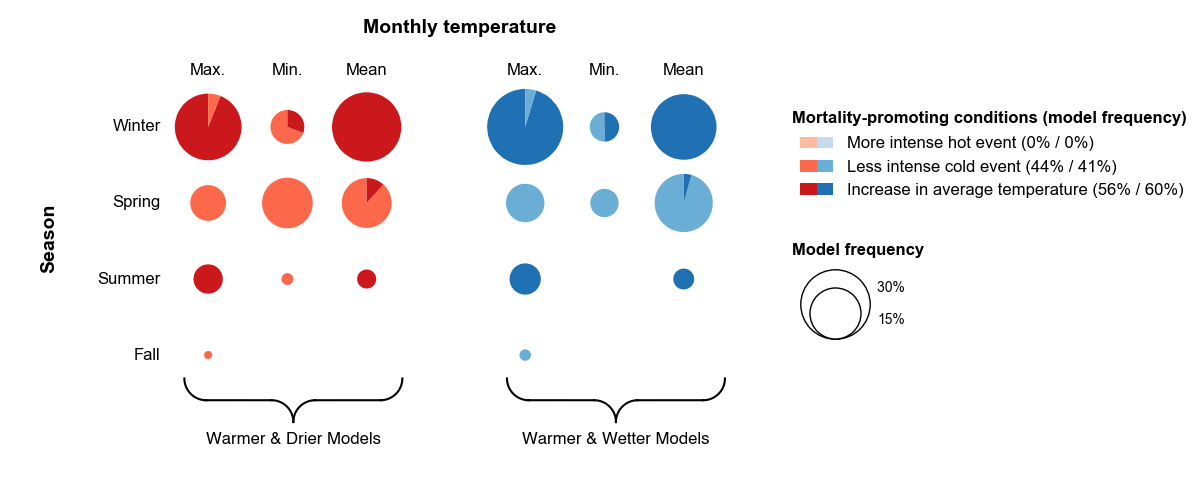

Using default changes: warmer_drier and warmer_wetter. Implementation for cooler_xxx not done yet.


198.0

,spei_duration,spei_season,value,size,max,min,mean,change
2,1,Summer,22.0,22.209968,0.169997,0.000000,0.830003,warmer_drier
11,6,Fall,15.0,14.539945,0.000000,0.705841,0.294159,warmer_drier
6,3,Summer,13.0,13.348053,0.353110,0.000000,0.646890,warmer_drier


,spei_duration,spei_season,value,size,max,min,mean,change
5,3,Spring,56.0,56.089624,0.0,1.0,0.0,warmer_wetter
1,1,Spring,35.0,35.127317,0.0,1.0,0.0,warmer_wetter
3,1,Fall,6.0,5.782167,0.0,1.0,0.0,warmer_wetter


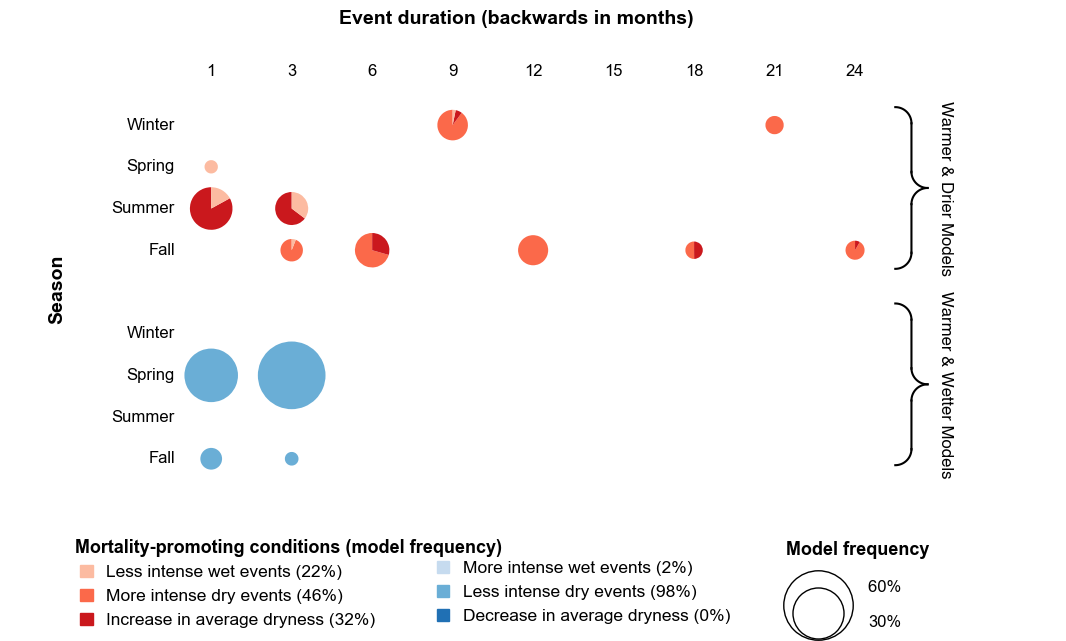

SPEI ANOMALY DISTRIBUTION -------------------------
- warmer + drier conditions:


spei_anom
max          0.22
mean         0.32
min          0.46
Name: proportion, dtype: float64

spei_season
aut            0.35
spr            0.03
sum            0.41
win            0.21
Name: proportion, dtype: float64

- warmer + wetter conditions:


spei_anom
min          0.98
max          0.02
Name: proportion, dtype: float64

spei_season
spr            0.86
aut            0.12
win            0.02
Name: proportion, dtype: float64

TEMPERATURE ANOMALY DISTRIBUTION -------------------------


temp_anom  temp_season
mean       win            0.42
min        spr            0.35
mean       sum            0.12
min        win            0.06
mean       spr            0.03
min        aut            0.01
           sum            0.01
Name: proportion, dtype: float64

temp_metric
max            0.40
mean           0.38
min            0.22
Name: proportion, dtype: float64

In [53]:
only_top9 = True
add_boxes = False
scale_by_nmodels = False
scale_by100perc = True

make_pie_chart_temp_v3(
    single_or_double_change="double",
    dfchange1=df_for_pie_charts_single_temp,
    dfchange2=df_for_pie_charts,
    only_top9=only_top9,
    size_scale=0.9,
    fig_scale=1.5,
    scale_by_nmodels=scale_by_nmodels,
    scale_by100perc=scale_by100perc,
    min_pie_size=0.0,
    add_boxes=False,
    dir_pie=dir_pie,
    add_perc_to_legend=True,
    verbose=True,
    merge_legend=True,
)

make_pie_chart_spei_v4(
    single_or_double_change="double",
    dfchange1=df_for_pie_charts_single_spei,
    dfchange2=df_for_pie_charts,
    only_top9=only_top9,
    size_scale=1.1,
    fig_scale=1.5,
    scale_by_nmodels=scale_by_nmodels,
    scale_by100perc=scale_by100perc,
    min_pie_size=0.1,
    add_boxes=False,
    dir_pie=dir_pie,
    add_perc_to_legend=True,
    verbose=True,
)

df_tmp = df_for_pie_charts.query("species in @top9")

print(f"SPEI ANOMALY DISTRIBUTION -------------------------")
print(f"- warmer + drier conditions:")
display(
    df_tmp.query("change == 'warmer_drier'")[["spei_anom"]]  # , "spei_duration"]]
    .value_counts(normalize=True)
    .sort_index()
    .round(2)
)

display(
    df_tmp.query("change == 'warmer_drier'")[["spei_season"]]  # , "spei_duration"]]
    .value_counts(normalize=True)
    .sort_index()
    .round(2)
)
print(f"- warmer + wetter conditions:")
display(
    df_tmp.query("change == 'warmer_wetter'")[["spei_anom"]]
    .value_counts(normalize=True)
    .round(2)
)

display(
    df_tmp.query("change == 'warmer_wetter'")[["spei_season"]]
    .value_counts(normalize=True)
    .round(2)
)

print(f"TEMPERATURE ANOMALY DISTRIBUTION -------------------------")
display(
    df_tmp.query("change == 'warmer_drier' or change == 'warmer_wetter'")[
        ["temp_anom", "temp_season"]
    ]
    .value_counts(normalize=True)
    .round(2)
)

display(
    df_tmp.query("change == 'warmer_drier' or change == 'warmer_wetter'")[
        ["temp_metric"]
    ]
    .value_counts(normalize=True)
    .round(2)
)

Using default changes: warmer_drier and warmer_wetter


'--- Ring Sizes'

199.0

,change,temp_season,temp_metric,value,max,min,mean
7,warmer_drier,Fall,min,3.0,0.144910,0.758912,0.096178
11,warmer_drier,Fall,mean,3.0,0.387404,0.301784,0.310813
3,warmer_drier,Fall,max,7.0,0.484705,0.321577,0.193718
1,warmer_drier,Spring,max,5.0,0.000000,0.902064,0.097936
5,warmer_drier,Spring,min,8.0,0.076400,0.806710,0.116890
9,warmer_drier,Spring,mean,10.0,0.028436,0.762448,0.209116
2,warmer_drier,Summer,max,4.0,0.000000,0.259776,0.740224
6,warmer_drier,Summer,min,5.0,0.057715,0.443923,0.498361
10,warmer_drier,Summer,mean,8.0,0.178719,0.222367,0.598914
4,warmer_drier,Winter,min,9.0,0.000000,0.502702,0.497298


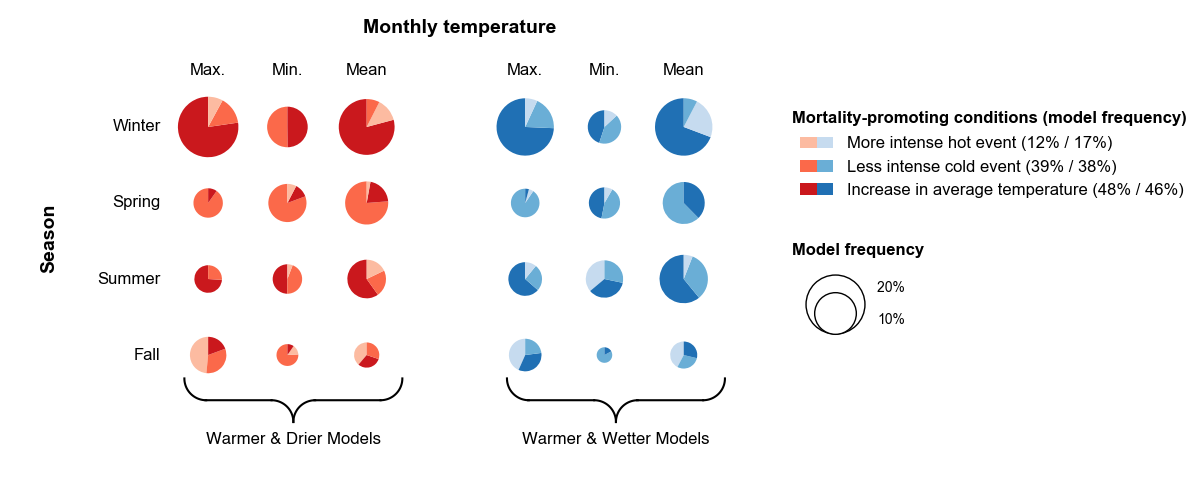

Using default changes: warmer_drier and warmer_wetter. Implementation for cooler_xxx not done yet.


201.0

,spei_duration,spei_season,value,size,max,min,mean,change
2,1,Summer,11.0,11.256823,0.293605,0.014680,0.691714,warmer_drier
11,6,Fall,11.0,11.284764,0.048676,0.613757,0.337567,warmer_drier
6,3,Summer,8.0,7.882377,0.270988,0.042087,0.686925,warmer_drier


,spei_duration,spei_season,value,size,max,min,mean,change
5,3,Spring,35.0,35.473766,0.000000,0.978814,0.021186,warmer_wetter
1,1,Spring,17.0,16.915343,0.011901,0.988099,0.000000,warmer_wetter
9,6,Spring,12.0,12.200235,0.030938,0.894812,0.074250,warmer_wetter


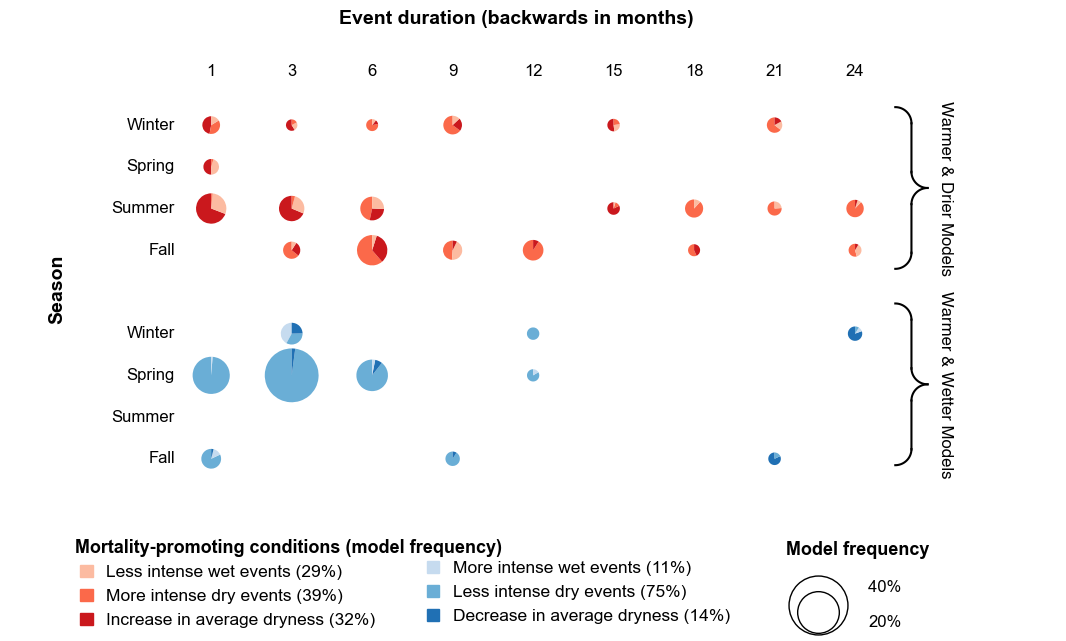

SPEI ANOMALY DISTRIBUTION -------------------------
- warmer + drier conditions:


spei_anom
max          0.29
mean         0.32
min          0.39
Name: proportion, dtype: float64

- warmer + wetter conditions:


spei_anom
min          0.75
mean         0.14
max          0.11
Name: proportion, dtype: float64

TEMPERATURE ANOMALY DISTRIBUTION -------------------------


temp_anom  temp_season
mean       win            0.26
min        spr            0.15
mean       sum            0.13
min        win            0.10
           sum            0.07
           aut            0.07
mean       spr            0.05
max        aut            0.05
           win            0.05
mean       aut            0.04
max        sum            0.03
           spr            0.01
Name: proportion, dtype: float64

temp_metric
mean           0.39
max            0.35
min            0.26
Name: proportion, dtype: float64

In [54]:
only_top9 = False
add_boxes = False
scale_by_nmodels = False
scale_by100perc = True

make_pie_chart_temp_v3(
    single_or_double_change="double",
    dfchange1=df_for_pie_charts_single_temp,
    dfchange2=df_for_pie_charts,
    only_top9=only_top9,
    size_scale=0.9,
    fig_scale=1.5,
    scale_by_nmodels=scale_by_nmodels,
    scale_by100perc=scale_by100perc,
    add_boxes=add_boxes,
    dir_pie=dir_pie,
    merge_legend=True,
    add_perc_to_legend=True,
    verbose=True,
)

make_pie_chart_spei_v4(
    single_or_double_change="double",
    dfchange1=df_for_pie_charts_single_spei,
    dfchange2=df_for_pie_charts,
    only_top9=only_top9,
    size_scale=1.1,
    fig_scale=1.5,
    scale_by_nmodels=scale_by_nmodels,
    scale_by100perc=scale_by100perc,
    add_boxes=add_boxes,
    dir_pie=dir_pie,
    add_perc_to_legend=True,
    min_pie_size=0.1,
)

# Percentages ------------------------------------------------
df_tmp = df_for_pie_charts.copy()

print(f"SPEI ANOMALY DISTRIBUTION -------------------------")
print(f"- warmer + drier conditions:")
display(
    df_tmp.query("change == 'warmer_drier'")[["spei_anom"]]  # , "spei_duration"]]
    .value_counts(normalize=True)
    .sort_index()
    .round(2)
)
print(f"- warmer + wetter conditions:")
display(
    df_tmp.query("change == 'warmer_wetter'")[["spei_anom"]]
    .value_counts(normalize=True)
    .round(2)
)

print(f"TEMPERATURE ANOMALY DISTRIBUTION -------------------------")
display(
    df_tmp.query("change == 'warmer_drier' or change == 'warmer_wetter'")[
        ["temp_anom", "temp_season"]
    ]
    .value_counts(normalize=True)
    .round(2)
)

display(
    df_tmp.query("change == 'warmer_drier' or change == 'warmer_wetter'")[
        ["temp_metric"]
    ]
    .value_counts(normalize=True)
    .round(2)
)

## Regression and Species Cluster


### Mortality Trends


In [55]:
import sys

sys.path.insert(0, "../../src")
from imports import *

init_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
def get_mort_trend_data():
    # path = "../01_process_nfi_data/specific_runs/run_to_calculate_mortality_trends_in_analysis - 2024-11-25/data_of_change/direct_bs/species_lat/centered_False-normalized_False/subset-top-None_bs-100.csv"

    # Get df extra created for this analysis
    df_mort_trends_raw = pd.read_feather(
        "../../data/final/mortality_trends/df_species52_temporal_data.feather"
    )

    # Clean df
    df_mort_trends_raw["species"] = (
        df_mort_trends_raw["group_year"].str.split("_").str[0]
    )
    df_mort_trends_raw["year"] = (
        df_mort_trends_raw["group_year"].str.split("_").str[1].astype(int)
    )
    df_mort_trends_raw = df_mort_trends_raw.drop(
        ["group_year", "region"], axis=1, errors="ignore"
    )
    df_mort_trends_raw = df_mort_trends_raw.rename({"mean": "mort"}, axis=1)

    # Remove NA in mortality
    # df_mort_trends_raw_na = df_mort_trends_raw.query("mort.isna()").copy()
    # df_mort_trends_raw = df_mort_trends_raw.dropna(subset=["mort"])
    # print(
    # f"Removed {df_mort_trends_raw_na.species.nunique()} species with NA in mortality."
    # )

    # Reorder columns
    df_mort_trends_raw = move_vars_to_front(
        df_mort_trends_raw, ["species", "year", "mort"]
    )

    return df_mort_trends_raw


def get_mort_trend(df_in):
    from sklearn.linear_model import LinearRegression

    # For every species group, calculate the trend as the slope of the linear regression
    # Initiate list
    df_mort_trends = []
    for ispecies in df_in.species.unique():
        # Get subset
        df_i = df_in.query("species == @ispecies").copy().dropna()
        # Get linear model
        lm = LinearRegression()
        lm.fit(df_i[["year"]], df_i["mort"])
        # Get slope
        slope = lm.coef_[0]
        # Get intercept
        intercept = lm.intercept_
        # Get r2
        r2 = lm.score(df_i[["year"]], df_i["mort"])
        # Get p-value
        p_value = stats.linregress(df_i["year"], df_i["mort"]).pvalue
        # Make plot
        # fig, ax = plt.subplots()
        # sns.regplot(data=df_i, x="year", y="mort", ax=ax)
        # ax.set_title(f"{ispecies} - Slope: {slope:.2f} - R2: {r2:.2f}")
        # plt.show()

        # Get MK test
        mktest = get_mk_test_raw(df_i["year"], df_i["mort"])

        # Append to list
        df_mort_trends.append(
            pd.DataFrame(
                {
                    "species": ispecies,
                    "slope": slope,
                    "intercept": intercept,
                    "r2": r2,
                    "pvalue": p_value,
                    "mk_pvalue": mktest["p"],
                    "mk_trend": mktest["trend"],
                },
                index=[0],
            )
        )

    df_mort_trends = pd.concat(df_mort_trends, axis=0).reset_index(drop=True)
    return df_mort_trends

In [57]:
# Absolute rates
df_mort_abs = get_mort_trend_data()

# Rates normalized to first year
df_mort_rel = df_mort_abs.copy()

for species in df_mort_rel.species.unique():
    # Get species
    df_species = df_mort_rel.query("species == @species").copy()
    # Remove 0 mortality (no mortality could be calculated for that year)
    df_species = df_species.query("mort > 0").copy()
    # Normalize to first year
    df_species["mort"] = df_species["mort"] / df_species["mort"].iloc[0]
    # Replace in df
    df_mort_rel.loc[df_mort_rel.species == species, "mort"] = df_species["mort"]

df_mort_rel_trends = get_mort_trend(df_mort_rel)
df_mort_abs_trends = get_mort_trend(df_mort_abs)

In [58]:
# # !Table for supplementary
df_mort_supp = df_mort_abs_trends.copy()[["species"]]

# Add absolute rates
df_mort_supp["Absolute increase [%/yr^2]"] = df_mort_abs_trends["slope"].round(2)
df_mort_supp["Relative increase [%/yr]"] = (df_mort_rel_trends["slope"] * 100).round(2)

# Attache change in rate over the years
dict_rates = {}
last_year = df_mort_rel.year.max()
for ispecies in df_mort_supp.species.unique():
    irate = (
        df_mort_rel.query("species == @ispecies and year == @last_year")
        .copy()["mort"]
        .values[0]
    )

    dict_rates[ispecies] = irate

df_mort_supp["x-fold increase"] = df_mort_supp["species"].map(dict_rates).round(2)

# Attach significance
df_mort_supp["pval"] = df_mort_rel_trends["pvalue"].round(3)

# Attach species info
df_mort_supp = df_mort_supp.merge(
    df_occ_red[
        ["species", "n_trees_total", "family_lat", "genus_lat"]
    ].drop_duplicates(),
    on="species",
    how="left",
)

# Add short names
# Shorten species name and set as index
df_mort_supp_clean = df_mort_supp.copy()
df_mort_supp_clean["species"] = df_mort_supp_clean["species"].replace(
    {"Populus": "Populus spp"}
)
df_mort_supp_clean["species"] = (
    df_mort_supp_clean["species"]
    + " ("
    + df_mort_supp_clean["species"].str.split(" ").str[0].str[:2].str.title()
    + df_mort_supp_clean["species"].str.split(" ").str[1].str[:2].str.title()
    + ")"
)


df_mort_supp_clean = move_vars_to_front(
    df_mort_supp_clean, ["species", "family_lat", "genus_lat", "n_trees_total"]
)

df_mort_supp_clean.rename(
    {
        "species": "Species (abbreviation)",
        "family_lat": "Family",
        "genus_lat": "Genus",
        "n_trees_total": "N Trees",
    },
    axis=1,
).to_csv(f"{dir_tables}/mortality_trends.csv", index=False)
df_mort_supp_clean.head(5)

,species,family_lat,genus_lat,n_trees_total,Absolute increase [%/yr^2],Relative increase [%/yr],x-fold increase,pval
0,Abies alba (AbAl),Pinaceae,Abies,29015,0.07,17.96,2.52,0.001
1,Abies grandis (AbGr),Pinaceae,Abies,377,0.29,20.92,3.12,0.142
2,Acer campestre (AcCa),Sapindaceae,Acer,8430,-0.01,-3.07,1.53,0.594
3,Acer pseudoplatanus (AcPs),Sapindaceae,Acer,6907,0.08,30.11,2.50,0.024
4,Alnus glutinosa (AlGl),Betulaceae,Alnus,6845,0.08,6.29,1.25,0.047


In [59]:
display(df_mort_rel_trends.head(3))
trends_sign = df_mort_rel_trends.query("pvalue < 0.05").species.nunique()
trends_total = df_mort_rel_trends.species.nunique()
print(
    f"Significant trends: {trends_sign} out of {trends_total} species = {trends_sign/trends_total*100:.0f}%"
)

,species,slope,intercept,r2,pvalue,mk_pvalue,mk_trend
0,Abies alba,0.179561,-360.230083,0.786246,0.001440,0.004879,increasing
1,Abies grandis,0.209152,-419.994976,0.454997,0.141653,0.132855,no trend
2,Acer campestre,-0.030659,63.231637,0.042634,0.594024,0.754454,no trend


Significant trends: 25 out of 52 species = 48%


In [60]:
# # ! Data for plotting
# Attach n_trees
df_mort_trends = df_mort_rel_trends.merge(
    df_occ_red[
        ["species", "n_trees_total", "family_lat", "genus_lat"]
    ].drop_duplicates(),
    on="species",
    how="left",
)

df_mort_trends["n_trees_rel"] = (
    df_mort_trends["n_trees_total"] / df_mort_trends["n_trees_total"].sum() * 100
)
df_mort_trends["n_trees_rel"] = df_mort_trends["n_trees_rel"].round(2)

# Attach whether significant
df_mort_trends["significant"] = df_mort_trends["pvalue"] < 0.05

# Attach columns from supplementary table
df_mort_trends = df_mort_trends.merge(
    df_mort_supp[["species", "Absolute increase [%/yr^2]", "Relative increase [%/yr]"]],
    on="species",
    how="left",
)

# Display
display(df_mort_trends.head(5))
df_mort_trends.species.unique()

,species,slope,intercept,r2,pvalue,mk_pvalue,mk_trend,n_trees_total,family_lat,genus_lat,n_trees_rel,significant,Absolute increase [%/yr^2],Relative increase [%/yr]
0,Abies alba,0.179561,-360.230083,0.786246,0.001440,0.004879,increasing,29015,Pinaceae,Abies,5.12,True,0.07,17.96
1,Abies grandis,0.209152,-419.994976,0.454997,0.141653,0.132855,no trend,377,Pinaceae,Abies,0.07,False,0.29,20.92
2,Acer campestre,-0.030659,63.231637,0.042634,0.594024,0.754454,no trend,8430,Sapindaceae,Acer,1.49,False,-0.01,-3.07
3,Acer pseudoplatanus,0.301063,-604.393877,0.539948,0.024119,0.028568,increasing,6907,Sapindaceae,Acer,1.22,True,0.08,30.11
4,Alnus glutinosa,0.062904,-125.705924,0.452159,0.047214,0.047604,increasing,6845,Betulaceae,Alnus,1.21,True,0.08,6.29


array(['Abies alba', 'Abies grandis', 'Acer campestre',
       'Acer pseudoplatanus', 'Alnus glutinosa', 'Alnus incana',
       'Arbutus unedo', 'Betula pendula', 'Betula pubescens',
       'Buxus sempervirens', 'Carpinus betulus', 'Castanea sativa',
       'Corylus avellana', 'Crataegus monogyna', 'Fagus sylvatica',
       'Frangula alnus', 'Fraxinus excelsior', 'Ilex aquifolium',
       'Juniperus communis', 'Laburnum anagyroides', 'Larix decidua',
       'Malus sylvestris', 'Picea abies', 'Picea sitchensis',
       'Pinus halepensis', 'Pinus mugo', 'Pinus nigra', 'Pinus pinaster',
       'Pinus sylvestris', 'Populus nigra', 'Populus tremula', 'Populus',
       'Prunus avium', 'Prunus mahaleb', 'Prunus spinosa',
       'Pseudotsuga menziesii', 'Quercus ilex', 'Quercus petraea',
       'Quercus pubescens', 'Quercus pyrenaica', 'Quercus robur',
       'Robinia pseudoacacia', 'Salix alba', 'Salix caprea',
       'Salix cinerea', 'Sambucus nigra', 'Sorbus aria',
       'Sorbus aucuparia'

In [61]:
# Check Buxus sempervirens because of extreme mortality increase
df_mort_trends.query("species == 'Buxus sempervirens'")

,species,slope,intercept,r2,pvalue,mk_pvalue,mk_trend,n_trees_total,family_lat,genus_lat,n_trees_rel,significant,Absolute increase [%/yr^2],Relative increase [%/yr]
9,Buxus sempervirens,3.950217,-7939.956114,0.486743,0.054367,0.063487,no trend,687,Buxaceae,Buxus,0.12,False,0.9,395.02


### Finalize for lms


In [62]:
# Attach tolerances to responses df
df_tol = pd.read_csv(
    "../../data/final/tables/species_tolerance_and_habita_data.csv"
).rename(
    columns={
        "species_lat2": "species",
        "ell_soil reaction": "ell_soil_reaction",
        "ell_soil moisture": "ell_soil_moisture",
    }
)
print(f"Tolerance indeces: {df_tol.columns.tolist()}")
# Add temp-spei patterns
df_lrs = (
    df_plot_from_mulitplot.copy()
    .drop(columns={"runs"})
    .merge(df_tol, on="species", how="left")
)
# Add single patterns
df_lrs = df_lrs.merge(species_change_single, on="species", how="left")

# Add phylogeny
df_lrs = df_lrs.merge(
    df_occ[["species", "genus_lat", "family_lat"]].drop_duplicates(),
    on="species",
    how="left",
)
# Add mortality data
df_lrs = df_lrs.merge(
    df_mort_trends,
    on=["species", "family_lat", "genus_lat", "n_trees_total"],
    how="left",
)

# Add temp/spei ratio
df_lrs["temp_spei_ratio"] = df_lrs["mean_temp"] / df_lrs["mean_spei"]

# Get dummy of mean spei duration and attach it
dmy = (
    df_both_patterns.copy()
    .query("change == 'warmer_drier'")
    .groupby("species")
    .agg({"spei_duration": "mean"})
    .rename(columns={"spei_duration": "mean_spei_duration"})
    .reset_index()
)
df_lrs = df_lrs.merge(dmy, on="species", how="left")

# Shorten species names
df_lrs = df_lrs.replace({"Populus": "Populus spp"})
df_lrs["species_long"] = df_lrs["species"].copy()
df_lrs["species"] = (
    df_lrs["species"].str.split(" ").str[0].str[:2].str.title()
    # + "_"
    + df_lrs["species"].str.split(" ").str[1].str[:2].str.title()
    # + "."
)

# Show
print(f"\nColumns: {sorted(df_lrs.columns.tolist())}")
df_lrs.head(2)

Tolerance indeces: ['species', 'tree_class', 'count', 'htot_mean', 'nii_shade', 'nii_drought', 'nii_waterlog']

Columns: ['Absolute increase [%/yr^2]', 'Relative increase [%/yr]', 'alive_alive', 'alive_dead', 'cooler', 'cooler_drier', 'cooler_wetter', 'count', 'drier', 'family_lat', 'genus_lat', 'htot_mean', 'intercept', 'mean_roc', 'mean_spei', 'mean_spei_duration', 'mean_temp', 'mk_pvalue', 'mk_trend', 'n_runs', 'n_trees_rel', 'n_trees_total', 'nii_drought', 'nii_shade', 'nii_waterlog', 'other', 'pvalue', 'r2', 'significant', 'slope', 'species', 'species_long', 'spei+temp', 'spei_unclear', 'std_roc', 'std_spei', 'std_temp', 'sum_changes_x', 'sum_changes_y', 'temp_spei_ratio', 'temp_unclear', 'tree_class', 'warmer', 'warmer_drier', 'warmer_wetter', 'wetter']


/var/folders/39/534x_msj7sl1kcxj2mg109x40000gn/T/ipykernel_13231/994959593.py:49: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_lrs = df_lrs.replace({"Populus": "Populus spp"})


,species,n_runs,mean_roc,std_roc,mean_spei,std_spei,mean_temp,std_temp,spei+temp,warmer_drier,warmer_wetter,other,cooler_drier,cooler_wetter,sum_changes_x,alive_alive,alive_dead,n_trees_total,tree_class,count,htot_mean,nii_shade,nii_drought,nii_waterlog,warmer,cooler,drier,wetter,temp_unclear,spei_unclear,sum_changes_y,genus_lat,family_lat,slope,intercept,r2,pvalue,mk_pvalue,mk_trend,n_trees_rel,significant,Absolute increase [%/yr^2],Relative increase [%/yr],temp_spei_ratio,mean_spei_duration,species_long
0,FrAl,30,0.687841,0.061484,17.053461,9.121420,13.741727,7.704637,30.795188,1.0,7.0,10.0,4.0,8.0,30.0,41,46,87,broadleaf,82.0,7.189286,2.66,1.37,3.19,8.0,15.0,6,20.0,7.0,4.0,60.0,Frangula,Rhamnaceae,0.017579,-34.503293,0.013367,0.767079,0.916965,no trend,0.02,False,0.20,1.76,0.805803,9.0,Frangula alnus
1,PrMa,42,0.715734,0.067902,13.944912,3.737898,10.473955,3.644829,24.418867,0.0,0.0,7.0,1.0,34.0,42.0,203,35,238,NaN,NaN,NaN,NaN,NaN,NaN,0.0,37.0,1,39.0,5.0,2.0,84.0,Prunus,Rosaceae,-0.052579,106.652545,0.158623,0.288383,0.348083,no trend,0.04,False,-0.19,-5.26,0.751095,NaN,Prunus mahaleb


### Color Palette


In [63]:
# Get color palettes
color_order = [
    # Purples
    "#5a4e60",
    "#907e99",
    "#cab2d7",
    # Blues
    "#485766",
    "#758ba2",
    "#a6c4e3",
    # Greens
    "#4e643b",
    "#7e9f62",
    "#b2df8b",
    # Yellows
    "#72542d",
    "#b5884c",
    "#fdbf6d",
    # Reds
    "#4f230c",
    "#7f3d1a",
    "#b35929",
    # Black
    "black",
]

family_lat_order = [
    "Aquifoliaceae",
    "Betulaceae",
    "Buxaceae",
    "Cupressaceae",
    "Ericaceae",
    "Fabaceae",
    "Fagaceae",
    "Malvaceae",
    "Oleaceae",
    "Pinaceae",
    "Rhamnaceae",
    "Rosaceae",
    "Salicaceae",
    "Sapindaceae",
    "Ulmaceae",
    "Viburnaceae",
]

family_en_order = [
    "Beech",
    "Birch",
    "Boxwood",
    "Buckthorn",
    "Cypress",
    "Elm",
    "Heath",
    "Holly",
    "Legume",
    "Mallow",
    "Olive",
    "Pine",
    "Rose",
    "Soapberry",
    "Viburnum",
    "Willow",
]

family_both_order = [
    "Aquifoliaceae (Holly)",
    "Betulaceae (Birch)",
    "Buxaceae (Boxwood)",
    "Cupressaceae (Cypress)",
    "Ericaceae (Heath)",
    "Fabaceae (Legume)",
    "Fagaceae (Beech)",
    "Malvaceae (Mallow)",
    "Oleaceae (Olive)",
    "Pinaceae (Pine)",
    "Rhamnaceae (Buckthorn)",
    "Rosaceae (Rose)",
    "Salicaceae (Willow)",
    "Sapindaceae (Soapberry)",
    "Ulmaceae (Elm)",
    "Viburnaceae (Viburnum)",
]

dict_family_en = {
    "Aquifoliaceae": "Holly",
    "Betulaceae": "Birch",
    "Buxaceae": "Boxwood",
    "Cupressaceae": "Cypress",
    "Ericaceae": "Heath",
    "Fabaceae": "Legume",
    "Fagaceae": "Beech",
    "Malvaceae": "Mallow",
    "Oleaceae": "Olive",
    "Pinaceae": "Pine",
    "Rhamnaceae": "Buckthorn",
    "Rosaceae": "Rose",
    "Salicaceae": "Willow",
    "Sapindaceae": "Soapberry",
    "Ulmaceae": "Elm",
    "Viburnaceae": "Viburnum",
}

dict_family_both = {
    "Aquifoliaceae": "Aquifoliaceae (Holly)",
    "Betulaceae": "Betulaceae (Birch)",
    "Buxaceae": "Buxaceae (Boxwood)",
    "Cupressaceae": "Cupressaceae (Cypress)",
    "Ericaceae": "Ericaceae (Heath)",
    "Fabaceae": "Fabaceae (Legume)",
    "Fagaceae": "Fagaceae (Beech)",
    "Malvaceae": "Malvaceae (Mallow)",
    "Oleaceae": "Oleaceae (Olive)",
    "Pinaceae": "Pinaceae (Pine)",
    "Rhamnaceae": "Rhamnaceae (Buckthorn)",
    "Rosaceae": "Rosaceae (Rose)",
    "Salicaceae": "Salicaceae (Willow)",
    "Sapindaceae": "Sapindaceae (Soapberry)",
    "Ulmaceae": "Ulmaceae (Elm)",
    "Viburnaceae": "Viburnaceae (Viburnum)",
}

dict_top9_lat_mixed = {
    "Abies alba": "Abies alba (Silver Fir)",
    "Carpinus betulus": "Carpinus betulus (European Hornbeam)",
    "Castanea sativa": "Castanea sativa (Sweet Chestnut)",
    "Fagus sylvatica": "Fagus sylvatica (Beech)",
    "Picea abies": "Picea abies (Norway Spruce)",
    "Pinus sylvestris": "Pinus sylvestris (Scots Pine)",
    "Quercus petraea": "Quercus petraea (Sessile Oak)",
    "Quercus pubescens": "Quercus pubescens (Downy Oak)",
    "Quercus robur": "Quercus robur (Pedunculate Oak)",
    "Quercus ilex": "Quercus ilex (Holm Oak)",
}

# For all non-relevant species, use "Other"
for ispecies in df_lrs.species_long.unique():
    if ispecies not in dict_top9_lat_mixed.keys():
        dict_top9_lat_mixed[ispecies] = "Other"


dict_top9_mixed_color = {
    # Pinetrees
    "Abies alba (Silver Fir)": "#fdbf6d",
    "Picea abies (Norway Spruce)": "#b5884c",
    "Pinus sylvestris (Scots Pine)": "#72542d",
    # Oaks
    "Quercus petraea (Sessile Oak)": "#45BF55",
    "Quercus pubescens (Downy Oak)": "#168039",
    "Quercus robur (Pedunculate Oak)": "#044D29",
    "Quercus ilex (Holm Oak)": "#00261C",
    # Others
    "Fagus sylvatica (Beech)": "#cab2d7",
    "Carpinus betulus (European Hornbeam)": "#7B52AB",
    "Castanea sativa (Sweet Chestnut)": "#553285",
    "Other": "darkgrey",
}

dict_species_short_lat = dict(zip(df_lrs.species, df_lrs.species_long))

### Functions


In [64]:
import statsmodels.formula.api as smf
from adjustText import adjust_text
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

In [65]:
def plot_patternshare_lm_ax(
    ax,
    tmp,
    x,
    y,
    color_palette,
    color_method,
    dict_family,
    long_labels=True,
    bold_top_species=[],
    dot_size=0,
    add_labels=None,
    pval_threshold=0.01,
    add_title=True,
    show_major_only=False,
    font_base=10,
    dirsave=None,
):

    # Input
    # if add_labels and not show_major_only:
    #     dot_size = 0

    if add_labels not in ["none", "top9", "top9+", "all"]:
        raise ValueError("Please select a valid option for add_labels.")

    if add_labels in ["none"]:
        adjust_labels = False
    else:
        adjust_labels = True

    # Create lists to hold the text objects for adjustment
    species_texts = []

    # Remove na values
    tmp = tmp.dropna(subset=[x, y])

    # Remove probelmatic species (BuSe has massive mortality increase, distorting the plot)
    if x in ["mort_increase_rel", "mort_increase_abs", "slope"]:
        tmp = tmp.query("species != 'BuSe'").copy()

    # Variable fixes
    if x == "count":
        tmp[x] = tmp[x] / 10000

    # Get ylabel
    if y == "warmer_drier":
        ylab = "warmer and drier"
    elif y == "warmer_wetter":
        ylab = "warmer and wetter"
    elif y == "other":
        ylab = "other"
    elif y == "cooler_drier":
        ylab = "cooler and drier"
    elif y == "cooler_wetter":
        ylab = "cooler and wetter"
    elif y == "warmer":
        ylab = "warmer"
    elif y == "cooler":
        ylab = "cooler"
    elif y == "response_temp_unclear":
        ylab = "unclear Temp. response"
    elif y == "drier":
        ylab = "drier"
    elif y == "wetter":
        ylab = "wetter"
    elif y == "response_spei_unclear":
        ylab = "unclear SPEI response"
    else:
        ylab = y

    # ylab = f"Vulnerability to {ylab} (% valid models)"
    ylab = f"Vulnerability to {ylab}\nconditions (% of models)"
    # ylab = f"Model share of {ylab} conditions (%)"
    # ylab = f"Increasing Mortality with {ylab} conditions (% of valid models)"

    # Get xlabel
    if x == "species":
        xlab = "Species"
    elif x == "tree_class":
        xlab = "Tree Class"
    elif x == "count":
        xlab = "Number of Trees (x 10'000)"
    elif x == "htot_mean":
        xlab = "Mean Height (m)"
    elif x == "succession":
        xlab = "Succession Stage"
    elif x == "ell_light":
        xlab = "Ellenberg Light Indicator"
    elif x == "ell_temperature":
        xlab = "Ellenberg Temperature Indicator"
    elif x == "ell_soil_reaction":
        xlab = "Ellenberg Soil Reaction Indicator"
    elif x == "ell_soil_moisture":
        xlab = "Ellenberg Soil Moisture Indicator"
    elif x == "ell_nitrogen":
        xlab = "Ellenberg Soil Nitrogen Indicator"
    elif x == "ell_salt":
        xlab = "Ellenberg Salt Indicator"
    elif x == "nii_shade":
        xlab = "Shade Tolerance"
    elif x == "nii_drought":
        xlab = "Drought Tolerance"
    elif x == "nii_waterlog":
        xlab = "Waterlogging Tolerance"
    elif x == "slope":
        xlab = "Relative change in mortality rate (%)"
    else:
        xlab = x

    xlab = xlab.capitalize()
    ylab = ylab.capitalize()

    # ! Run lm
    lm = smf.ols(f"{y} ~ {x}", data=tmp).fit()

    # Get coefficients
    r2 = lm.rsquared
    # Ignore warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    slope = lm.params[1]
    intercept = lm.params[0]
    pval = lm.pvalues[1]  # .round(5)
    pval_sign = f"= {pval:.2f}" if pval > pval_threshold else f"< {pval_threshold}"
    slope_linetype = "dashed" if pval > pval_threshold else "solid"
    slope_sign = "+" if slope > 0 else "-"

    line_eq = f"y = {intercept:.2f} {slope_sign} {np.abs(slope):.2f}x | R² = {r2:.2f} | p {pval_sign}"

    # ! Add color column
    if color_method == "species_mixed":
        color_var = "species_long"
    else:
        color_var = "family_lat"

    # Create a color column
    tmp["color"] = tmp[color_var].map(dict_family).map(color_palette)

    # ! Create regplot
    lm_color = "darkgrey"
    lm_plot = sns.regplot(
        data=tmp,
        x=x,
        y=y,
        fit_reg=True,
        ci=95,
        scatter=True,
        ax=ax,
        scatter_kws={"s": 0},
        # scatter_kws={"s": dot_size, "color": tmp["color"]},
        line_kws={"color": lm_color, "linestyle": slope_linetype, "alpha": 0.5},
        truncate=False,
    )

    # Add equation as text
    ax.text(
        0.98,
        0.96,
        line_eq,
        fontsize=font_base * 1,
        fontstyle="italic",
        ha="right",
        # color=lm_color,
        color="black",
        transform=ax.transAxes,
        bbox=dict(
            facecolor="white", edgecolor="white", boxstyle="round,pad=0.3", alpha=0.75
        ),
        zorder=4,
    )

    # Add scatterplot
    # sns.scatterplot(
    #     data=tmp,
    #     x=x,
    #     y=y,
    #     ax=ax,
    #     s=dot_size,
    #     marker="o",
    #     edgecolor="white",
    #     linewidth=2,
    #     color=tmp[color_var].map(color_palette),
    # )

    # ! Add scatter for each species
    for _, row in tmp.iterrows():
        ispecies = row["species"]

        # Add point if not displaying all species
        if add_labels != "all":
            ax.scatter(
                row[x],
                row[y],
                s=dot_size,
                color=row["color"],  # Fill color
                edgecolors="black",  # Black edges
                linewidths=0.5,  # Thickness of the edge lines
                marker="o",  # Circle marker (default)
            )

        # ! Add labels if needed

        if add_labels == "top9":
            bald_top_species_ = [
                "AbAl",
                "CaBe",
                "CaSa",
                "FaSy",
                "PiAb",
                "PiSy",
                "QuPe",
                "QuPu",
                "QuRo",
            ]

        if add_labels == "top9+":
            bald_top_species_ = [
                "AbAl",
                "CaBe",
                "CaSa",
                "FaSy",
                "PiAb",
                "PiSy",
                "QuPe",
                "QuPu",
                "QuRo",
                "QuIl",
            ]

        if add_labels == "all":
            bald_top_species_ = tmp.species.unique()
            ifw = "normal"
            ifs = "normal"
        else:
            ifw = "normal"
            ifs = "normal"

        if add_labels != "none":
            if ispecies in bald_top_species_:

                if long_labels:
                    ispecies = dict_species_short_lat[ispecies]

                # Create the species text label
                species_text = ax.text(
                    row[x],
                    row[y],
                    ispecies,
                    fontsize=font_base * 1.1,
                    fontweight=ifw,
                    fontstyle=ifs,
                    color=row["color"],
                    zorder=3,
                    bbox=dict(
                        facecolor="white",
                        # alpha=0.8,
                        alpha=0.85,
                        edgecolor="white",
                        boxstyle="round,pad=0.05",
                    ),
                )
                species_texts.append(species_text)

    # ! Adjust labels if needed
    if adjust_labels:
        if add_labels == "all":
            adjust_text(
                species_texts,
                expand_axes=False,
                ax=ax,
                min_arrow_len=5,
                arrowprops=dict(
                    arrowstyle="-",
                    lw=0,
                    alpha=0,
                ),
            )
        else:
            adjust_text(
                species_texts,
                expand_axes=False,
                expand=(1.5, 1.5),
                ax=ax,
                min_arrow_len=5,
                arrowprops=dict(
                    arrowstyle="-",
                    lw=0.75,
                    alpha=1,
                ),
            )

    # Axis layout
    ax.set(ylim=(-15, 115))
    ax.set_xlabel(xlab, weight="bold", fontsize=font_base * 1.1)
    ax.set_ylabel(ylab, weight="bold", fontsize=font_base * 1.1)

    # Increase tick size
    ax.tick_params(axis="both", which="major", labelsize=font_base * 1)

    # Add title if needed
    if add_title:
        ax.set_title(f"{y} ~ {x}", weight="bold")

    # Remove legend if labels are added
    if adjust_labels:
        ax.legend().remove()

    # Remove top and right axis
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Tight layout
    # plt.tight_layout()

    return ax


# Example usage
# plot_patternshare_lm(
#     tmp, "htot_mean", "warmer_wetter", dot_size=0, add_labels=True, dirsave=dir_patterns
# )

In [66]:
# PCA Plot
def plot_pca_ax(
    df_plot,
    color_palette,
    color_method,
    dict_family,
    long_labels=True,
    ax=ax,
    add_labels="none",
    dot_size=150,
    bold_top_species=[],
    my_palette="Paired",
    color_pca="black",
    pca_arr_exp=1.1,
    pca_txt_exp=2,
    font_base=14,
    figx=12,
    figy=6,
    subset=[
        "species",
        # "mean_temp",
        # "mean_spei",
        # "spei+temp",
        "warmer_drier",
        "cooler_drier",
        "other",
        "cooler_wetter",
        "warmer_wetter",
    ],
):
    # ! PCA ------------------------------------------------
    from sklearn.decomposition import PCA

    replacement_pattern = "&"

    # Get df for PCA
    df_pca = df_plot.copy()[subset].set_index("species")

    # Rename change variables
    df_pca.columns = df_pca.columns.str.replace("r_", f"r {replacement_pattern} ")

    # Get numerical columns
    numeric_cols = df_pca.columns

    # Rename "other" to "non sign."
    # numeric_cols = [c.replace("other", "non sign.") for c in numeric_cols]

    # Standardize data
    df_pca = (df_pca - df_pca.mean()) / df_pca.std()

    # Do PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_pca)
    df_pca["PC1"] = pca_result[:, 0]
    df_pca["PC2"] = pca_result[:, 1]

    # Attach genus information
    # Todo: Use local instead of global df_occ variable here!
    df_pca = df_pca.reset_index()
    df_pca = df_pca.merge(
        df_occ[["species", "genus_lat", "family_lat"]].drop_duplicates(),
        on="species",
        how="left",
    )

    # Shorten species name and set as index
    df_pca["species"] = df_pca["species"].replace({"Populus": "Populus spp"})
    df_pca["species_long"] = df_pca["species"].copy()
    df_pca["species"] = (
        df_pca["species"].str.split(" ").str[0].str[:2].str.title()
        # + "_"
        + df_pca["species"].str.split(" ").str[1].str[:2].str.title()
        # + "."
    )

    # Get explained variance
    explained_variance = pca.explained_variance_ratio_

    # ! PLOT ------------------------------------------------

    # ! Add color column
    if color_method == "species_mixed":
        color_var = "species_long"
    else:
        color_var = "family_lat"

    # Create a color column
    df_pca["color"] = df_pca[color_var].map(dict_family).map(color_palette)

    # Add 0 lines
    ax.axhline(0, color="grey", linewidth=0.5, linestyle="dotted")
    ax.axvline(0, color="grey", linewidth=0.5, linestyle="dotted")

    if add_labels == "all":
        dot_size = 0

    sns.scatterplot(
        data=df_pca,
        x="PC1",
        y="PC2",
        ax=ax,
        s=dot_size,
        marker="o",
        color=df_pca["color"],
        edgecolor="black",
        linewidth=0.5,
    )

    # ! Add species labels
    if add_labels not in ["none", "top9", "top9+", "all"]:
        raise ValueError("Please select a valid option for add_labels.")

    if add_labels == "none":
        adjust_labels = False
    else:
        adjust_labels = True

    if add_labels == "top9":
        bald_top_species_ = [
            "AbAl",
            "CaBe",
            "CaSa",
            "FaSy",
            "PiAb",
            "PiSy",
            "QuPe",
            "QuPu",
            "QuRo",
        ]

    if add_labels == "top9+":
        bald_top_species_ = [
            "AbAl",
            "CaBe",
            "CaSa",
            "FaSy",
            "PiAb",
            "PiSy",
            "QuPe",
            "QuPu",
            "QuRo",
            "QuIl",
        ]

    if add_labels == "all":
        bald_top_species_ = df_pca.species.unique()
        ifw = "normal"
        ifs = "normal"
    else:
        ifw = "normal"
        ifs = "normal"

    txt_species = []
    if add_labels != "none":
        for i, ispecies in enumerate(df_pca.species):

            if ispecies in bald_top_species_:

                # Create the species text label
                if long_labels:
                    ispecies = dict_species_short_lat[ispecies]

                species_text = ax.text(
                    df_pca["PC1"].iloc[i],
                    df_pca["PC2"].iloc[i],
                    ispecies,
                    color=df_pca["color"].iloc[i],
                    fontsize=10,
                    fontweight=ifw,
                    fontstyle=ifs,
                    zorder=3,
                    # ha="center",
                    # va="center",
                    bbox=dict(
                        facecolor="white",
                        # alpha=0.8,
                        alpha=0.85,
                        edgecolor="white",
                        boxstyle="round,pad=0.05",
                    ),
                )
                txt_species.append(species_text)

    # ! PCA ARROWS ------------------------------------------------------------------------------------
    txt_pca = []
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    for i, feature in enumerate(numeric_cols):

        arrow_x = loadings[i, 0] * pca_arr_exp
        arrow_y = loadings[i, 1] * pca_arr_exp
        text_x = loadings[i, 0] * pca_txt_exp
        text_y = loadings[i, 1] * pca_txt_exp

        if feature == f"warmer {replacement_pattern} drier":
            text_x = -1.5
            text_y = -2.2
        elif feature == f"warmer {replacement_pattern} wetter":
            text_x = -1.4
            text_y = 2.2
        elif feature == f"cooler {replacement_pattern} drier":
            text_x = 1.3
            text_y = -1.5
        elif feature == f"cooler {replacement_pattern} wetter":
            text_x = 1.2
            text_y = 1
        elif feature == "other":
            text_x = 1.3
            text_y = -0.5
        else:
            raise ValueError(f"feature not correctly matched: {feature}")

        ax.arrow(
            0,
            0,
            arrow_x,
            arrow_y,
            color=color_pca,
            alpha=1,
            linewidth=1.25,
            head_width=0.1,
            head_length=0.1,
        )

        txt_pca.append(
            ax.text(
                text_x,
                text_y,
                feature,
                color=color_pca,
                ha="center",
                # va="center",
                fontweight="bold",
                fontsize=font_base * 1,
                bbox=dict(
                    facecolor="white",
                    alpha=0.8,
                    # alpha=0,
                    edgecolor=color_pca,
                    boxstyle="round,pad=0.2",
                ),
            )
        )

    # ! Adjust text labels ---------------------------------------------------------------
    if adjust_labels:
        # Append "warmer - drier" and "warmer - wetter" to avoid overlaps
        display(txt_pca)
        if long_labels:
            # txt_species.append(txt_pca[0])
            txt_species.append(txt_pca[1])
            # txt_species.append(txt_pca[2])
            # txt_species.append(txt_pca[3])
            # txt_species.append(txt_pca[4])

        if add_labels == "all":
            adjust_text(
                txt_species,
                expand_axes=False,
                expand=(1, 1),
                ax=ax,
                arrowprops=dict(
                    arrowstyle="-",
                    lw=0,
                    alpha=0,
                ),
            )
        else:
            adjust_text(
                txt_species,
                expand_axes=False,
                expand=(1.5, 1.5),
                ax=ax,
                min_arrow_len=5,
                arrowprops=dict(
                    arrowstyle="-",
                    lw=0.75,
                    alpha=1,
                ),
            )

    # Add legend for color
    handles = [
        plt.Line2D([0], [0], marker="o", color="w", label=key, markerfacecolor=value)
        for key, value in color_palette.items()
    ]
    ax.legend(
        handles=handles,
        title=color_var,
        fontsize=font_base * 1,
        loc="center right",
        markerscale=2,
        # va="center",
        bbox_to_anchor=(1.25, 0.5),
        frameon=False,
    ).set_title("", prop={"weight": "bold", "size": font_base * 1.1})

    # Add explained variance to axis
    ax.set_xlabel(
        f"Principal component 1 ({explained_variance[0] * 100:.0f}%)",
        weight="bold",
        size=font_base * 1.1,
    )
    ax.set_ylabel(
        f"Principal component 2 ({explained_variance[1] * 100:.0f}%)",
        weight="bold",
        size=font_base * 1.1,
    )

    # Remove top and right axis
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Increase tick size
    ax.tick_params(axis="both", which="major", labelsize=font_base * 0.9)

    # Set same limits
    # Limit fix
    ymax = 2.75 if add_labels else 2.825
    ax.set_xlim(-2.6, 3.2)
    ax.set_ylim(-ymax, ymax)

    # Return ax
    return ax

In [67]:
def make_pca_lm_fig(mychange, add_labels, color_method, long_labels):

    # ! Input check
    if mychange not in ["warmer_wetter", "wetter"]:
        raise ValueError("mychange must be 'warmer_wetter' or 'wetter'.")

    # ! Select color palette
    legend_title = "Family"
    legend_nrow = 6
    if color_method == "latin":
        color_palette = dict(zip(family_lat_order, color_order))
    elif color_method == "common":
        color_palette = dict(zip(family_en_order, color_order))
        dict_family = dict_family_en
    elif color_method == "mixed":
        color_palette = dict(zip(family_both_order, color_order))
        dict_family = dict_family_both
    elif color_method == "species_mixed":
        dict_family = dict_top9_lat_mixed
        color_palette = dict_top9_mixed_color
        legend_title = "Species"
        legend_nrow = 4
    else:
        chime.error()
        raise ValueError("Please select a valid color palette (color_method).")

    # Figure settings
    add_title = False
    dot_size = 60

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(
        2,
        2,
        figsize=(18, 10),
        # figsize=(40, 7),  # For 4x1 plot
    )
    # plt.subplots_adjust(hspace=0.2, wspace=0.2)
    axs = axs.flatten()

    # ! PCA Plot
    plot_pca_ax(
        df_plot,
        color_palette=color_palette,
        color_method=color_method,
        dict_family=dict_family,
        long_labels=long_labels,
        ax=axs[0],
        font_base=10,
        dot_size=dot_size,
        add_labels=add_labels,
        # bold_top_species=bold_species_short,
    )

    # Remove legend from PCA plot
    axs[0].get_legend().remove()

    # ! LM Plots
    plot_patternshare_lm_ax(
        axs[1],
        tmp2,
        "nii_drought",
        mychange,
        color_palette=color_palette,
        color_method=color_method,
        dict_family=dict_family,
        long_labels=long_labels,
        dot_size=dot_size,
        # bold_top_species=bold_species_short,
        add_labels=add_labels,
        pval_threshold=pval_threshold,
        add_title=add_title,
        dirsave=dir_patterns,
    )

    plot_patternshare_lm_ax(
        axs[2],
        tmp2,
        "htot_mean",
        mychange,
        color_palette=color_palette,
        color_method=color_method,
        dict_family=dict_family,
        long_labels=long_labels,
        dot_size=dot_size,
        # bold_top_species=bold_species_short,
        add_labels=add_labels,
        pval_threshold=pval_threshold,
        add_title=add_title,
        dirsave=dir_patterns,
    )

    plot_patternshare_lm_ax(
        axs[3],
        tmp2,
        "nii_shade",
        mychange,
        color_palette=color_palette,
        color_method=color_method,
        dict_family=dict_family,
        long_labels=long_labels,
        dot_size=dot_size,
        # bold_top_species=bold_species_short,
        add_labels=add_labels,
        pval_threshold=pval_threshold,
        add_title=add_title,
        dirsave=dir_patterns,
    )

    # Add letters to each subplot
    letters = ["A", "B", "C", "D"]
    for i, ax in enumerate(axs):
        ax.text(
            0.02,
            0.98,
            letters[i],
            transform=ax.transAxes,
            fontsize=14,
            fontweight="bold",
            # fontstyle="italic",
        )

    # Fix axes
    axs[0].set_ylim(-3.2, 3.9)
    axs[0].set_xlim(-2.6, 3.9)
    axs[1].set_ylim(-5, 55)
    axs[2].set_ylim(-5, 55)
    axs[3].set_ylim(-5, 55)

    # Set all axes labels to same size
    for ax in axs:
        ax.set_xlabel(ax.get_xlabel(), fontsize=12)
        ax.set_ylabel(ax.get_ylabel(), fontsize=12)
        ax.tick_params(axis="both", which="major", labelsize=10)

    # Create new legend using color_palette with circular markers and black edges
    legend_patches = [
        mlines.Line2D(
            [0],
            [0],
            marker="o",  # Circle marker
            color="black",  # Edge color (black)
            markerfacecolor=color,  # Fill color from color_palette
            markeredgewidth=1,  # Edge line width
            markersize=10,  # Circle size
            linestyle="None",  # No connecting line
            label=label,  # Label for legend
        )
        for label, color in color_palette.items()
    ]

    # Plotting the legend
    plt.legend(
        handles=legend_patches,
        loc="lower center",
        ncol=legend_nrow,
        bbox_to_anchor=(-0.11, -0.5),
        # bbox_to_anchor=(-1.3, -0.3), # For 4x1 plot
        frameon=False,
        fontsize=12,
        title=legend_title,
        handlelength=0.7,
    )

    # Adjust legend title formatting
    plt.setp(
        plt.gca().get_legend().get_title(),
        fontweight="bold",
        fontsize=12,
        ha="center",
    )

    plt.tight_layout(w_pad=200, h_pad=2)
    os.makedirs(f"{dir_patterns}/pca+lms", exist_ok=True)
    plt.savefig(
        f"{dir_patterns}/pca+lms/{mychange}-labels_{add_labels}_long_{long_labels}-colored_{color_method}.png",
        bbox_inches="tight",
    )
    # plt.savefig(
    #     f"{dir_patterns}/pca+lms/{mychange}-labels_{add_labels}_long_{long_labels}-colored_{color_method}.pdf",
    # )
    clear_output()
    plt.show()

In [68]:
def plot_triangle_ax(
    ax,
    df_in,
    spei_or_temp,
    color_palette,
    bold_top_species=[],
    show_major_only=False,
    dot_size=0,
    add_labels=True,
    pval_threshold=0.01,
    add_title=True,
    font_base=10,
    dirsave=None,
):

    # Libs
    import mpltern

    # Input check
    if add_labels and dot_size != 0:
        print(f" To remove dots, set dot_size to 0.")

    # Create lists to hold the text objects for adjustment
    species_texts = []

    # Extract columns
    if spei_or_temp == "spei":
        cols = ["drier", "wetter", "spei_unclear"]
    elif spei_or_temp == "temp":
        cols = ["cooler", "warmer", "temp_unclear"]

    tmp = df_lrs[cols + ["species", "family_lat", "genus_lat"]].copy()

    # Remove "_unclear" to have clean columns names
    corner_labels = tmp.columns.str.replace(f"{spei_or_temp}_", "").str.capitalize()

    # Normalize cols for ternary plot
    tmp[cols] = tmp[cols].div(tmp[cols].sum(axis=1), axis=0)

    # Rename family column if not in latin
    if "Beech" or "Fagaceae (Beech)" in color_palette.keys():
        # todo: should not use global dict_family
        tmp[color_var] = tmp[color_var].map(dict_family)

    # Create a color column
    tmp["color"] = tmp[color_var].map(color_palette)

    # Plot species labels
    for _, row in tmp.iterrows():
        # Get coordinates
        ax.scatter(
            row[cols[0]],
            row[cols[1]],
            row[cols[2]],
            s=dot_size,
            color=color_palette[row[color_var]],
        )

        if add_labels:

            # Define fontweight
            ifw = "normal"
            ifs = "normal"
            if row["species"] in bold_top_species:
                ifw = "bold"
                ifs = "italic"
            if show_major_only and row["species"] not in bold_top_species:
                continue
            else:

                # Create the species text label
                species_text = ax.text(
                    row[cols[0]],
                    row[cols[1]],
                    row[cols[2]],
                    row["species"],
                    fontsize=font_base * 1,
                    fontweight=ifw,
                    fontstyle=ifs,
                    color=color_palette[row[color_var]],
                    zorder=3,
                )
                species_texts.append(species_text)

    if add_labels:
        # Adjust text positions to avoid overlap with arrows
        adjust_text(
            species_texts,
            expand_axes=False,
            ax=ax,
            # arrowprops=dict(
            #     arrowstyle="->",
            #     lw=1,
            #     alpha=0.75,
            # ),
        )

    # Add ticks and labels for the corners
    ax.set_tlabel(corner_labels[0], fontsize=font_base * 1.1)  # , fontweight="bold")
    ax.set_llabel(corner_labels[1], fontsize=font_base * 1.1)  # , fontweight="bold")
    ax.set_rlabel(corner_labels[2], fontsize=font_base * 1.1)  # , fontweight="bold")

    # Customize tick positions and labels
    ax.taxis.set_ticks([0.2, 0.4, 0.6, 0.8])
    ax.laxis.set_ticks([0.2, 0.4, 0.6, 0.8])
    ax.raxis.set_ticks([0.2, 0.4, 0.6, 0.8])

    return ax

### Tables


In [69]:
# Data Settings
withFrEx = True
pval_threshold = 0.05

# Figure Settings
save_fig = False
sign_only = False
add_labels = True
add_title = False
dot_size = 100

# Ignore warnings
warnings.filterwarnings("ignore")
# Suppress matplotlib warnings
# Small fix because '+' does not work in variable name
df_lrs.rename(columns={"spei+temp": "spei_temp"}, inplace=True)

# Get data
tmp2 = df_lrs.copy()
tmp_dir = f"{dir_patterns}/pattern_lms-pval_{pval_threshold}"

# Rename columns
tmp2 = tmp2.rename(
    columns={
        "Absolute increase [%/yr^2]": "mort_increase_abs",
        "Relative increase [%/yr]": "mort_increase_rel",
    }
)

# Add coloring column
# tmp2["family_col"] = tmp2["family_lat"].map(dict_family)

# Show df
display(tmp2.head(2))

# Make dir
# os.makedirs(tmp_dir, exist_ok=True)

tmp_list = []

if add_labels:
    dot_size = 0

xs = [
    "n_trees_total",
    "count",
    "htot_mean",
    "slope",
    # "ell_light",
    # "ell_temperature",
    # "ell_soil_reaction",
    # "ell_soil_moisture",
    # "ell_nitrogen",
    # "ell_salt",
    "nii_shade",
    "nii_drought",
    "nii_waterlog",
    # "mort_increase_abs",
    # "mort_increase_rel",
]

ys = [
    # "warmer",
    "warmer_drier",
    "warmer_wetter",
    # "cooler",
    # "cooler_drier",
    # "cooler_wetter",
    "drier",
    "wetter",
    # "other",
    # "response_temp_unclear",
    # "response_spei_unclear",
    # "mean_spei",
    # "mean_temp",
    # "mean_roc",
    # "spei_temp",
    # "temp_spei_ratio",
]

for y in ys:
    # display(f"🟨 {x} -------------------------")
    for x in xs:

        idf = tmp2.copy()
        idf = idf.dropna(subset=[x, y])

        # Note: Removal of species needs to be done here and in the plot_patternshare_lm function
        if x in ["mort_increase_rel", "mort_increase_abs", "slope"]:
            idf = idf.query(
                "species != 'BuSe'"
            ).copy()  # has extreme increase which distorts the regression
            # idf = idf.query("species != 'FrEx'").copy()

        # Run lm
        lm = smf.ols(f"{y} ~ {x}", data=idf).fit()

        # Get coefficients
        r2 = lm.rsquared
        slope = lm.params[1]
        intercept = lm.params[0]
        pval = lm.pvalues[1]
        pval_sign = f"= {pval:.2f}" if pval > pval_threshold else f"< {pval_threshold}"
        slope_linetype = "solid" if pval < pval_threshold else "dashed"
        slope_sign = "+" if slope > 0 else "-"
        line_eq = f"y = {intercept:.2f} {slope_sign} {np.abs(slope):.2f}x \t| R² = {r2:.2f} | p {pval_sign} ({pval:.3f})"
        exclam = "!!!" if pval < pval_threshold else ""

        # Save information in list
        tmp_list.append(
            {
                "exclam": exclam,
                "y": y,
                "x": x,
                "slope": slope,
                "intercept": intercept,
                "r2": r2.round(2),
                "pval": pval.round(4),
                "pval_sign": pval_sign,
                "slope_linetype": slope_linetype,
                "slope_sign": slope_sign,
                "line_eq": line_eq,
                "n_species": idf["species"].nunique(),
            }
        )

        print(f"{exclam}\t {y:<25} ~ {x:<25} {line_eq} {exclam}")
        if save_fig:
            plot_patternshare_lm(
                idf,
                x,
                y,
                color_palette=color_palette,
                color_var="family_col",
                dot_size=dot_size,
                add_labels=add_labels,
                pval_threshold=pval_threshold,
                add_title=add_title,
                dirsave=tmp_dir,
                save_fig=save_fig,
            )

# Save list as csv
tmp_list = pd.DataFrame(tmp_list)
tmp_list = tmp_list.sort_values(["exclam", "y", "x"])
# tmp_list.to_csv(f"{tmp_dir}/lm_results.csv", index=False)

# # Show
clear_output(wait=True)
pd.set_option("display.max_rows", 200)
display(
    # tmp_list.sort_values(["exclam", "y", "pval"])[
    tmp_list.sort_values(["y", "x"])[
        [
            "y",
            "x",
            "pval",
            "slope_sign",
            "exclam",
            "slope",
            "intercept",
            "r2",
            "n_species",
        ]
    ]
)
pd.set_option("display.max_rows", 50)

,y,x,pval,slope_sign,exclam,slope,intercept,r2,n_species
15,drier,count,0.3160,+,,0.000159,27.780521,0.02,48
16,drier,htot_mean,0.7038,-,,-0.167401,31.740692,0.00,48
14,drier,n_trees_total,0.1802,+,,0.000190,26.196396,0.04,52
19,drier,nii_drought,0.1170,+,,3.377240,20.540253,0.06,45
18,drier,nii_shade,0.9310,-,,-0.214262,30.954381,0.00,45
20,drier,nii_waterlog,0.9145,-,,-0.273210,30.888134,0.00,45
17,drier,slope,0.0281,+,!!!,30.045605,23.848734,0.09,51
1,warmer_drier,count,0.0409,+,!!!,0.000334,19.770518,0.09,48
2,warmer_drier,htot_mean,0.9063,-,,-0.054329,24.032389,0.00,48
0,warmer_drier,n_trees_total,0.0182,+,!!!,0.000340,18.408011,0.11,52


### Figures


In [70]:
# Get most important species in bold
bold_species_long = (
    df_plot.sort_values("n_trees_total", ascending=False).species.head(9).tolist()
)
bold_species_short = (
    tmp2.sort_values("n_trees_total", ascending=False).species.head(9).tolist()
)
print(bold_species_long)
print(bold_species_short)

['Fagus sylvatica', 'Quercus robur', 'Quercus petraea', 'Carpinus betulus', 'Castanea sativa', 'Quercus pubescens', 'Pinus sylvestris', 'Abies alba', 'Picea abies']
['FaSy', 'QuRo', 'QuPe', 'CaBe', 'CaSa', 'QuPu', 'PiSy', 'AbAl', 'PiAb']


#### PCA + LMs


##### Fig. 6


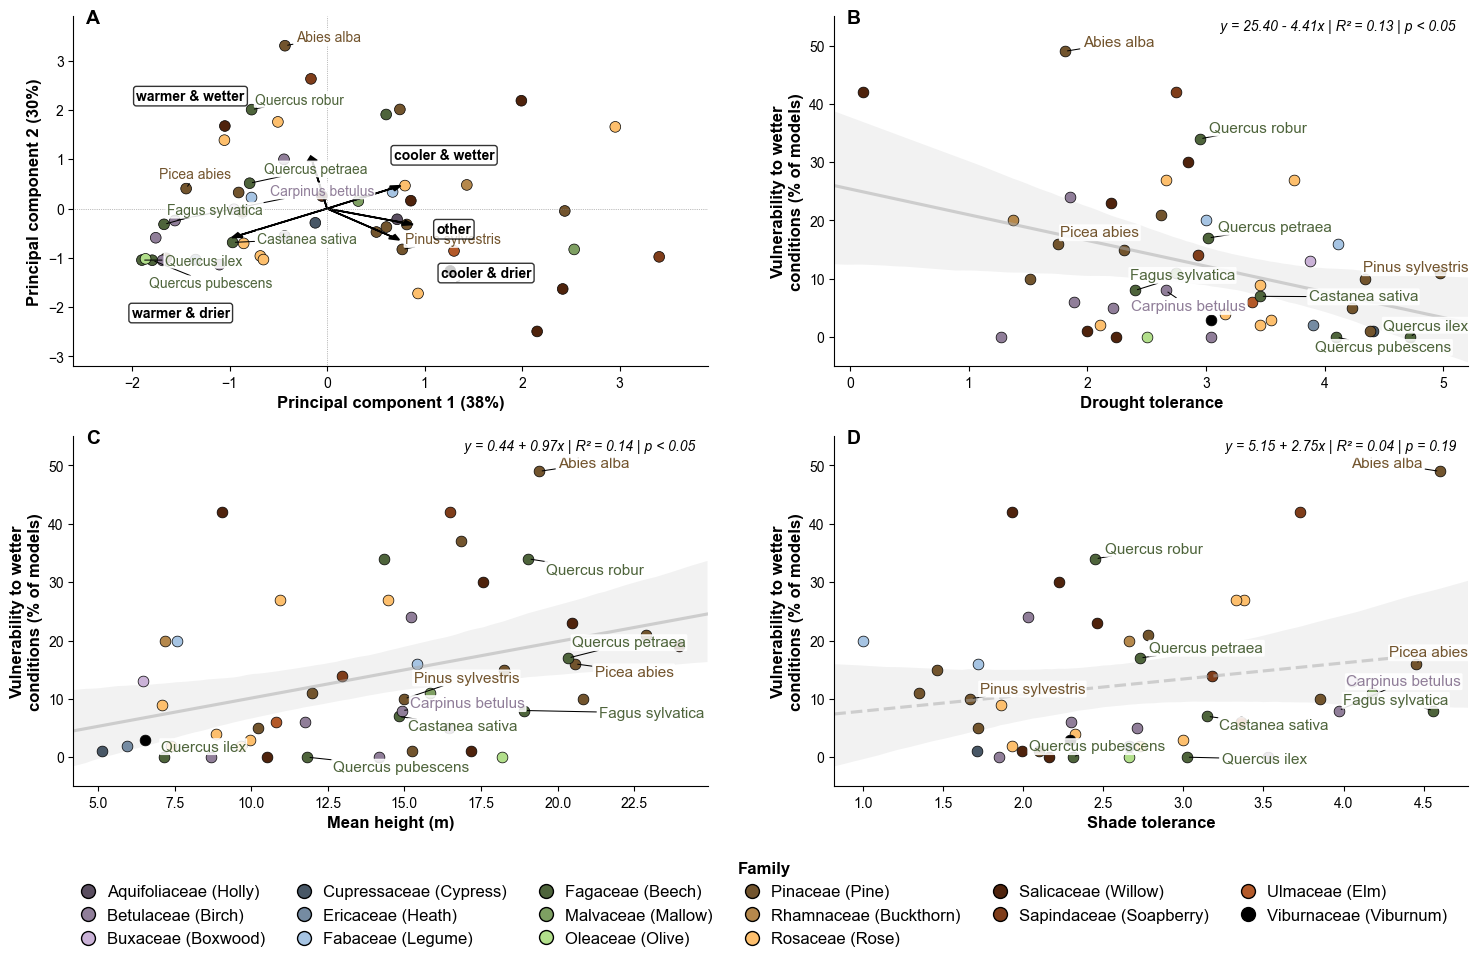

In [71]:
make_pca_lm_fig("wetter", "top9+", "mixed", long_labels=True)

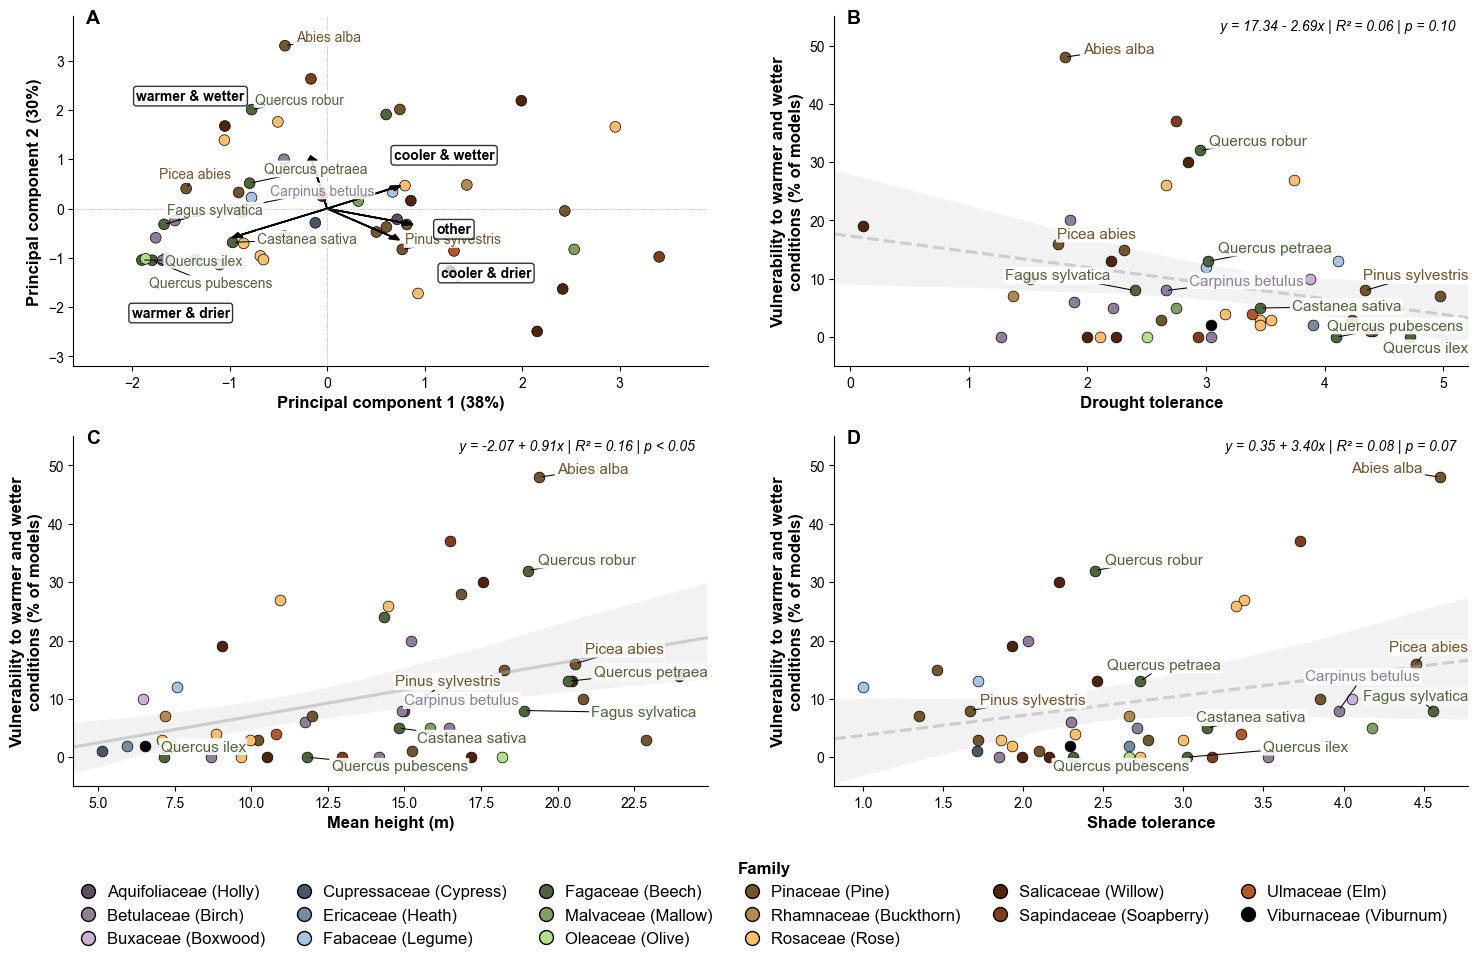

In [72]:
make_pca_lm_fig("warmer_wetter", "top9+", "mixed", long_labels=True)

## CSV Files


### General


In [73]:
# Save csv tables with different sortings of all species
list_of_sorts = {
    "1": (["species", "nruns_rel"], [True, False]),
    "2": (["n_trees_total", "nruns_rel"], [False, False]),
    "3": (["change", "species"], [False, False]),
    "4": (["change", "nruns_rel"], [False, False]),
    "5": (["change", "n_trees_total"], [False, False]),
    "6": (["species", "change"], [True, False]),
}

for subset in ["top-all", "top-5", "top-10", "top-20"]:

    # os.makedirs(f"{dir_patterns}/lookup-{subset}", exist_ok=True)
    df_subset = df_occ_red.copy()

    if subset == "top-all":
        pass
    else:
        tmp_n = subset.replace("top", "")
        tmp_n = int(tmp_n)
        tmp_species = top_species_all.head(tmp_n).species.tolist()
        df_subset = df_subset.query("species in @tmp_species")

    for key, (sort_list, tf_list) in list_of_sorts.items():
        suffix = str.join("", [f"_{c}" for c in sort_list])
        df_file = (
            move_vars_to_front(df_subset, sort_list)
            .sort_values(sort_list, ascending=tf_list)
            .reset_index(drop=True)
        )
        # df_file.to_csv(
        #     f"{dir_patterns}/lookup-{subset}/sorted_by{suffix}.csv", index=False
        # )

### Sorted by Species


In [74]:
pd.set_option("display.max_colwidth", 1000)

In [75]:
df_tmp = df_occ_red.sort_values(
    ["species", "nruns_rel"], ascending=[True, False]
).reset_index(drop=True)[
    [
        "species",
        "change",
        "nruns_val_rel",
        "nruns_val",
        # "feature_spei",
        "spei_simple",
        # "spei_simpler",
        "temp_season",
    ]
]

# Subset
df_tmp.head(50)

# Top 20
df_tmp.query("species in @top9").reset_index(drop=True).to_clipboard(index=False)
df_tmp.query("species in @top9").reset_index(drop=True).sort_values(
    ["change", "species"], ascending=[True, True]
)

,species,change,nruns_val_rel,nruns_val,spei_simple,temp_season
1,Abies alba,warmer_drier,2,50,sum-3 (100%),win (100%)
3,Carpinus betulus,warmer_drier,83,47,"sum-1 (49%), aut-6 (26%), sum-3 (13%), win-21 (10%), win-9 (3%)","spr (49%), win (41%), sum (10%)"
5,Castanea sativa,warmer_drier,76,50,"sum-1 (61%), win-9 (18%), spr-12 (11%), aut-24 (8%), sum-3 (3%)",spr (100%)
9,Fagus sylvatica,warmer_drier,84,50,"sum-1 (26%), sum-3 (24%), win-21 (17%), spr-1 (14%), aut-18 (7%), aut-9 (7%), sum-15 (2%), sum-24 (2%)","win (62%), spr (38%)"
11,Picea abies,warmer_drier,68,50,"aut-6 (71%), sum-3 (26%), sum-15 (3%)","win (91%), sum (6%), aut (3%)"
13,Pinus sylvestris,warmer_drier,40,50,"win-9 (55%), aut-3 (40%), aut-6 (5%)","win (70%), spr (25%), sum (5%)"
18,Quercus petraea,warmer_drier,60,45,"win-9 (37%), sum-1 (19%), aut-6 (11%), sum-3 (11%), sum-18 (7%), win-3 (7%), aut-18 (4%), sum-6 (4%)","sum (44%), win (44%), spr (11%)"
22,Quercus pubescens,warmer_drier,100,49,"aut-12 (51%), aut-24 (18%), aut-3 (14%), aut-18 (10%), aut-6 (2%), aut-9 (2%), sum-6 (2%)",win (100%)
24,Quercus robur,warmer_drier,32,50,"sum-3 (44%), aut-12 (31%), aut-18 (6%), aut-3 (6%), sum-1 (6%), win-12 (6%)","spr (75%), win (25%)"
0,Abies alba,warmer_wetter,96,50,"spr-3 (56%), spr-1 (44%)","win (96%), sum (4%)"


### Split View


In [76]:
# # ! Settings
species_subset = (
    top9
    + ["Quercus ilex"]
    + species_family.query("family_lat == 'Pinaceae'")["species_lat2"].tolist()
)

# Get temporary df
df_occ_tmp = df_occ_red.copy()

# Subset of columns
cols = [
    "species",
    "change_perc",
    "change",
    # ! Temp
    # "temp_metric",
    # "temp_anom",
    # "temp_season",
    # "feature_temp",
    # ! SPEI
    "best_feature_spei",
    "spei_duration_simple",
    "spei_anom",
    "spei_season",
    # "best_spei_simpler",
    # "spei_simpler",
    # "best_feature_spei",
    "feature_spei",
]

# Adjust sorting
df_occ_tmp = df_occ_tmp.sort_values("n_trees_total", ascending=False)
# df_occ_tmp = df_occ_tmp.sort_values("n_changes", ascending=True)
# df_occ_tmp = df_occ_tmp.sort_values("family_lat", ascending=True)
# df_occ_tmp = df_occ_tmp.sort_values("genus_lat", ascending=True)
# df_occ_tmp = df_occ_tmp.sort_values("nruns_rel", ascending=False)
# df_occ_tmp = df_occ_tmp.sort_values("species", ascending=False)

# Add filter
species_subset_1 = (
    df_nchanges_per_species_2patterns.query("n_changes <= 2")["species"]
    .unique()
    .tolist()
)

# Show
for ichange in change_dict.keys():
    display(ichange)

    # display(df_occ_tmp.query("change == @ichange and species in @species_subset_1"))
    display(df_occ_tmp[cols].query("change == @ichange and species in @species_subset"))
    # display(df_occ_tmp.query("change == @ichange"))

'warmer_drier'

,species,change_perc,change,best_feature_spei,spei_duration_simple,spei_anom,spei_season,feature_spei
0,Fagus sylvatica,warmer_drier (84%),warmer_drier,spei3-sum_max,"short (64%), long (29%), medium (7%)","max (57%), min (29%), mean (14%)","sum (55%), win (17%), aut (14%), spr (14%)","spei3-sum_max (24%), spei21-win_min (17%), spei1-spr_max (14%), spei1-sum_mean (14%), spei1-sum_max (12%), spei18-aut_min (7%), spei9-aut_max (7%), spei15-sum_min (2%), spei24-sum_min (2%)"
2,Quercus robur,warmer_drier (32%),warmer_drier,spei3-sum_mean,"short (56%), medium (38%), long (6%)","mean (50%), min (38%), max (12%)","sum (50%), aut (44%), win (6%)","spei3-sum_mean (44%), spei12-aut_min (31%), spei1-sum_mean (6%), spei12-win_max (6%), spei18-aut_min (6%), spei3-aut_max (6%)"
5,Quercus petraea,warmer_drier (54%),warmer_drier,spei9-win_min,"medium (52%), short (37%), long (11%)","min (56%), mean (33%), max (11%)","win (44%), sum (41%), aut (15%)","spei9-win_min (33%), spei1-sum_mean (11%), spei3-sum_mean (11%), spei1-sum_max (7%), spei18-sum_min (7%), spei3-win_min (7%), spei6-aut_mean (7%), spei18-aut_min (4%), spei6-aut_min (4%), spei6-sum_max (4%), spei9-win_mean (4%)"
9,Carpinus betulus,warmer_drier (78%),warmer_drier,spei1-sum_mean,"short (62%), medium (28%), long (10%)","mean (79%), min (13%), max (8%)","sum (62%), aut (26%), win (13%)","spei1-sum_mean (41%), spei6-aut_mean (23%), spei3-sum_mean (13%), spei21-win_min (10%), spei1-sum_max (8%), spei6-aut_min (3%), spei9-win_mean (3%)"
11,Castanea sativa,warmer_drier (76%),warmer_drier,spei1-sum_mean,"short (63%), medium (29%), long (8%)","mean (63%), min (24%), max (13%)","sum (63%), win (18%), spr (11%), aut (8%)","spei1-sum_mean (61%), spei9-win_min (16%), spei12-spr_max (11%), spei24-aut_min (8%), spei3-sum_mean (3%), spei9-win_max (3%)"
15,Quercus pubescens,warmer_drier (98%),warmer_drier,spei12-aut_min,"medium (57%), long (29%), short (14%)","min (86%), mean (12%), max (2%)","aut (98%), sum (2%)","spei12-aut_min (51%), spei24-aut_min (16%), spei3-aut_min (14%), spei18-aut_mean (10%), spei24-aut_mean (2%), spei6-aut_min (2%), spei6-sum_max (2%), spei9-aut_min (2%)"
16,Pinus sylvestris,warmer_drier (40%),warmer_drier,spei9-win_min,"medium (60%), short (40%)",min (100%),"win (55%), aut (45%)","spei9-win_min (55%), spei3-aut_min (40%), spei6-aut_min (5%)"
21,Abies alba,warmer_drier (2%),warmer_drier,spei3-sum_mean,short (100%),mean (100%),sum (100%),spei3-sum_mean (100%)
24,Picea abies,warmer_drier (68%),warmer_drier,spei6-aut_min,"medium (71%), short (26%), long (3%)","min (71%), mean (21%), max (9%)","aut (71%), sum (29%)","spei6-aut_min (71%), spei3-sum_mean (18%), spei3-sum_max (9%), spei15-sum_mean (3%)"
27,Quercus ilex,warmer_drier (100%),warmer_drier,spei12-aut_min,"medium (94%), short (4%), long (2%)","min (86%), mean (14%)",aut (100%),"spei12-aut_min (48%), spei9-aut_min (22%), spei6-aut_min (10%), spei6-aut_mean (8%), spei12-aut_mean (6%), spei3-aut_min (4%), spei18-aut_min (2%)"


'cooler_drier'

,species,change_perc,change,best_feature_spei,spei_duration_simple,spei_anom,spei_season,feature_spei
6,Quercus petraea,cooler_drier (2%),cooler_drier,spei1-sum_max,short (100%),max (100%),sum (100%),spei1-sum_max (100%)
12,Castanea sativa,cooler_drier (10%),cooler_drier,spei1-sum_mean,"short (80%), medium (20%)","mean (80%), max (20%)","sum (80%), spr (20%)","spei1-sum_mean (60%), spei12-spr_max (20%), spei3-sum_mean (20%)"
17,Pinus sylvestris,cooler_drier (26%),cooler_drier,spei9-win_min,"medium (77%), short (15%), long (8%)",min (100%),"win (62%), aut (38%)","spei9-win_min (62%), spei3-aut_min (15%), spei6-aut_min (15%), spei21-aut_min (8%)"
29,Pinus pinaster,cooler_drier (6%),cooler_drier,spei1-aut_max,"short (67%), long (33%)",max (100%),"aut (67%), win (33%)","spei1-aut_max (67%), spei18-win_max (33%)"
34,Pseudotsuga menziesii,cooler_drier (18%),cooler_drier,spei1-spr_max,short (100%),max (100%),spr (100%),spei1-spr_max (100%)
78,Pinus halepensis,cooler_drier (8%),cooler_drier,spei1-win_max,"medium (50%), short (50%)",max (100%),"spr (50%), win (50%)","spei1-win_max (50%), spei6-spr_max (50%)"
110,Pinus mugo,cooler_drier (12%),cooler_drier,spei1-win_mean,short (100%),mean (100%),win (100%),spei1-win_mean (100%)
164,Abies grandis,cooler_drier (10%),cooler_drier,spei1-win_mean,"short (50%), long (25%), medium (25%)","mean (75%), min (25%)","spr (50%), win (50%)","spei1-win_mean (25%), spei18-spr_min (25%), spei3-win_mean (25%), spei6-spr_mean (25%)"


'other'

,species,change_perc,change,best_feature_spei,spei_duration_simple,spei_anom,spei_season,feature_spei
18,Pinus sylvestris,other (14%),other,spei3-aut_min,short (100%),"min (75%), mean (25%)","aut (75%), spr (25%)","spei3-aut_min (75%), spei3-spr_mean (25%)"
22,Abies alba,other (2%),other,spei1-spr_min,short (100%),min (100%),spr (100%),spei1-spr_min (100%)
30,Pinus pinaster,other (10%),other,spei1-aut_min,"short (75%), long (25%)","min (75%), max (25%)","aut (75%), win (25%)","spei1-aut_min (50%), spei1-aut_max (25%), spei15-win_min (25%)"
35,Pseudotsuga menziesii,other (28%),other,spei3-spr_min,"short (56%), medium (39%), long (6%)","min (78%), max (22%)","spr (50%), sum (28%), aut (17%), win (6%)","spei3-spr_min (44%), spei6-sum_max (17%), spei9-sum_min (11%), spei1-aut_min (6%), spei1-spr_max (6%), spei12-aut_min (6%), spei15-win_min (6%), spei6-aut_min (6%)"
43,Pinus nigra,other (2%),other,spei21-sum_min,long (100%),min (100%),sum (100%),spei21-sum_min (100%)
79,Pinus halepensis,other (30%),other,spei6-sum_mean,"medium (67%), short (33%)","mean (67%), max (22%), min (11%)","sum (67%), aut (11%), spr (11%), win (11%)","spei6-sum_mean (67%), spei1-spr_max (11%), spei1-win_max (11%), spei3-aut_min (11%)"
83,Larix decidua,other (10%),other,spei1-spr_min,"short (75%), medium (25%)","min (50%), max (25%), mean (25%)","spr (50%), aut (25%), sum (25%)","spei1-spr_min (50%), spei3-sum_mean (25%), spei6-aut_max (25%)"
111,Pinus mugo,other (14%),other,spei1-win_mean,"short (83%), medium (17%)","mean (50%), min (50%)","sum (50%), win (50%)","spei1-win_mean (50%), spei3-sum_min (33%), spei9-sum_min (17%)"
128,Picea sitchensis,other (12%),other,spei1-spr_max,"long (43%), short (43%), medium (14%)","max (43%), mean (29%), min (29%)","spr (43%), sum (29%), aut (14%), win (14%)","spei1-spr_max (29%), spei1-spr_min (14%), spei15-sum_min (14%), spei24-aut_mean (14%), spei24-win_mean (14%), spei6-sum_max (14%)"
165,Abies grandis,other (26%),other,spei15-win_min,"long (64%), medium (36%)",min (100%),"win (64%), aut (27%), spr (9%)","spei15-win_min (64%), spei12-aut_min (27%), spei6-spr_min (9%)"


'cooler_wetter'

,species,change_perc,change,best_feature_spei,spei_duration_simple,spei_anom,spei_season,feature_spei
3,Quercus robur,cooler_wetter (4%),cooler_wetter,spei3-spr_min,short (100%),min (100%),spr (100%),spei3-spr_min (100%)
7,Quercus petraea,cooler_wetter (8%),cooler_wetter,spei3-spr_min,short (100%),min (100%),spr (100%),spei3-spr_min (100%)
13,Castanea sativa,cooler_wetter (4%),cooler_wetter,spei3-aut_min,short (100%),min (100%),aut (100%),spei3-aut_min (100%)
19,Pinus sylvestris,cooler_wetter (4%),cooler_wetter,spei3-spr_min,short (100%),min (100%),spr (100%),spei3-spr_min (100%)
31,Pinus pinaster,cooler_wetter (18%),cooler_wetter,spei3-spr_min,"medium (50%), short (50%)",min (100%),"spr (62%), aut (25%), win (12%)","spei3-spr_min (38%), spei12-spr_min (25%), spei1-aut_min (12%), spei12-aut_min (12%), spei9-win_min (12%)"
36,Pseudotsuga menziesii,cooler_wetter (32%),cooler_wetter,spei1-aut_min,"short (70%), long (20%), medium (10%)","min (80%), max (20%)","aut (50%), win (30%), sum (20%)","spei1-aut_min (40%), spei1-sum_min (20%), spei18-win_max (10%), spei21-win_max (10%), spei3-win_min (10%), spei6-aut_min (10%)"
80,Pinus halepensis,cooler_wetter (8%),cooler_wetter,spei3-aut_min,"short (75%), medium (25%)","min (75%), max (25%)","aut (75%), spr (25%)","spei3-aut_min (50%), spei3-spr_min (25%), spei9-aut_max (25%)"
112,Pinus mugo,cooler_wetter (2%),cooler_wetter,spei15-aut_min,long (100%),min (100%),aut (100%),spei15-aut_min (100%)
166,Abies grandis,cooler_wetter (2%),cooler_wetter,spei12-sum_min,medium (100%),min (100%),sum (100%),spei12-sum_min (100%)


'warmer_wetter'

,species,change_perc,change,best_feature_spei,spei_duration_simple,spei_anom,spei_season,feature_spei
1,Fagus sylvatica,warmer_wetter (16%),warmer_wetter,spei3-spr_min,short (100%),min (100%),spr (100%),"spei3-spr_min (88%), spei1-spr_min (12%)"
4,Quercus robur,warmer_wetter (64%),warmer_wetter,spei1-spr_min,short (100%),min (100%),spr (100%),"spei1-spr_min (72%), spei3-spr_min (28%)"
8,Quercus petraea,warmer_wetter (26%),warmer_wetter,spei3-spr_min,short (100%),min (100%),spr (100%),"spei3-spr_min (92%), spei1-spr_min (8%)"
10,Carpinus betulus,warmer_wetter (16%),warmer_wetter,spei3-spr_min,short (100%),min (100%),spr (100%),spei3-spr_min (100%)
14,Castanea sativa,warmer_wetter (10%),warmer_wetter,spei3-aut_min,short (100%),min (100%),"aut (50%), spr (50%)","spei3-aut_min (50%), spei1-spr_min (25%), spei3-spr_min (25%)"
20,Pinus sylvestris,warmer_wetter (16%),warmer_wetter,spei3-spr_min,short (100%),min (100%),"spr (83%), aut (17%)","spei3-spr_min (83%), spei3-aut_min (17%)"
23,Abies alba,warmer_wetter (96%),warmer_wetter,spei3-spr_min,short (100%),min (100%),spr (100%),"spei3-spr_min (56%), spei1-spr_min (44%)"
25,Picea abies,warmer_wetter (32%),warmer_wetter,spei1-aut_min,short (100%),"min (94%), max (6%)","aut (50%), spr (44%), win (6%)","spei1-aut_min (50%), spei3-spr_min (38%), spei1-spr_min (6%), spei3-win_max (6%)"
32,Pinus pinaster,warmer_wetter (56%),warmer_wetter,spei3-spr_min,"medium (50%), short (36%), long (14%)",min (100%),"spr (68%), win (18%), aut (7%), sum (7%)","spei3-spr_min (32%), spei12-spr_min (29%), spei9-win_min (14%), spei12-aut_min (7%), spei1-spr_min (4%), spei15-sum_min (4%), spei15-win_min (4%), spei21-spr_min (4%), spei21-sum_min (4%)"
37,Pseudotsuga menziesii,warmer_wetter (6%),warmer_wetter,spei24-win_max,long (100%),max (100%),win (100%),spei24-win_max (100%)


# Tree-Level Analyses


## Functions


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import clear_output  # For clearing the output of a cell

In [78]:
def get_change_variable(pattern, df_both_patterns, df_temp_patterns, df_spei_patterns):

    # Get classification variable
    if "_" in pattern:
        return ("change", "group", df_both_patterns)

    if pattern == "warmer" or pattern == "cooler":
        return ("response_temp", "group_temp", df_temp_patterns)

    if pattern == "drier" or pattern == "wetter":
        return ("response_spei", "group_spei", df_spei_patterns)

In [79]:
def get_shap_response_for_species_and_run(
    irun, ispecies, ipattern_shap, add_response=False
):
    """
    Process SHAP data and append the merged results to a given list.

    Parameters:
        irun (str): The run identifier.
        ispecies (str): The species identifier.
        ipattern_shap (str): The response pattern ('drier', 'wetter', 'warmer', 'cooler').
    """
    # Get run-species directory
    idir_species = glob.glob(f"./model_runs/all_runs/{irun}/{ispecies}/")
    if len(idir_species) > 1:
        print(f"{irun} - {ispecies}: {idir_species}")
        raise ValueError("🚨 More than one species dir found. Needs debugging...")
    idir_species = idir_species[0]

    # Load feature data
    X_shap = pd.read_csv(f"{idir_species}/final_model/X_test.csv", index_col=0)
    feature_names = pd.Series(X_shap.columns)

    # Identify the response variable
    if ipattern_shap in ["drier", "wetter"]:
        feat_response = glmm_get_spei_var(feature_names)
    elif ipattern_shap in ["warmer", "cooler"]:
        feat_response = glmm_get_temp_var(feature_names)
    else:
        raise ValueError(f"🚨 Response variable not valid: {ipattern_shap}")

    pos_response = feature_names[feature_names == feat_response].index[0]

    # Load SHAP data
    shap_values = load_shap(f"{idir_species}/shap/approximated/shap_values_test.pkl")
    shap_values = shap_values[:, pos_response, 1].values

    # Attach SHAP values to feature data
    X_shap["shap"] = shap_values
    X_shap["index"] = X_shap.index

    # Scale SHAP values
    minmax = MinMaxScaler()
    X_shap["shap"] = minmax.fit_transform(
        X_shap["shap"].values.reshape(-1, 1)
    ).flatten()

    # Load tree ID data
    X_treeid = pd.read_csv(f"{idir_species}/treeid/X_test_treeid.csv").drop(
        columns=["Unnamed: 0"]
    )
    X_treeid = X_treeid.query("index in @X_shap.index").copy()
    X_treeid["index"] = X_treeid.index.tolist()

    # Merge SHAP values and tree ID data
    X_merged = pd.merge(
        X_shap[["index", "shap"]], X_treeid[["index", "tree_id"]], on="index"
    )

    if add_response:
        X_merged[feat_response] = X_shap[feat_response].values

    return X_merged

In [80]:
def get_shap_per_tree(
    ispecies,
    ipattern,
    ipattern_shap,
    subset_of_runs,
    df_single_responses,
    df_both_patterns,
    df_temp_patterns,
    df_spei_patterns,
    nfi_sub,
    add_filter_spei_features=None,
    add_return_runs_only=False,
    verbose=True,
):
    """
    - ispecies: requested species
    - ipattern: requested pattern to filter for
    - ipattern_shap: requested SHAP values to return
    - subset_of_runs: how to filter for runs
      - all: all runs, where single classification matches pattern
      - grouped: all runs, where grouped classification matches pattern
      - grouped_subset: all runs where grouped AND single classification matches pattern

    - df_single_responses: Dataframe of responses classified at run-level
    - df_both_patterns: Dataframe of responses classified at spei-temp pair group-level
    - df_temp_patterns: Dataframe of temperature responses classified at feature group-level
    - df_spei_patterns: Dataframe of spei responses classified at feature group-level

    - nfi_sub: NFI data with tree_id, species, coordinates, tree_state_change
    """

    # ! Check inputed pattern combination --------------------------------------------------
    if "_" in ipattern and ipattern_shap is None:
        print(f"🚨 Requested SHAP values not in ipattern: {ipattern_shap} > {ipattern}")
        raise

    if "_" in ipattern and ipattern_shap not in ipattern:
        print(f"🚨 Requested SHAP values not in ipattern: {ipattern_shap} > {ipattern}")
        raise

    elif "_" not in ipattern and ipattern != ipattern_shap:
        print(f"🚨 Requested SHAP values not in ipattern: {ipattern_shap} > {ipattern}")
        raise

    valid_patterns = [
        "warmer",
        "cooler",
        "drier",
        "wetter",
        "warmer_cooler",
        "drier_wetter",
        "other",
    ]

    valid_shap_patterns = [
        "warmer",
        "cooler",
        "drier",
        "wetter",
    ]

    # ! Get change_var and grouped response df --------------------------------------------------
    # Note: Input dfs are global variables and are not passed as arguments!
    change_var, group_var, df_grouped_responses = get_change_variable(
        ipattern, df_both_patterns, df_temp_patterns, df_spei_patterns
    )

    # Filter for the species
    df_single_responses = df_single_responses.query("species == @ispecies").sort_values(
        "run"
    )
    df_grouped_responses = df_grouped_responses.query("species == @ispecies")

    # Get all runs with the pattern
    all_runs = (
        df_single_responses.query(f"{change_var} == @ipattern")["run"].unique().tolist()
    )

    # Get all groups with the pattern
    all_groups = (
        df_grouped_responses.query(f"{change_var} == @ipattern")[group_var]
        .unique()
        .tolist()
    )

    # Turn into integer
    all_groups = [int(x) for x in all_groups]

    # print(f" > Runs: {all_runs.__len__()}: {all_runs}")

    # Filter for runs
    if subset_of_runs == "all":
        df_single_responses = df_single_responses.query(f"run in @all_runs")
    elif subset_of_runs == "grouped":
        df_single_responses = df_single_responses.query(f"group in @all_groups")
    elif subset_of_runs == "grouped_subset":
        df_single_responses = df_single_responses.query(
            f"run in @all_runs and group in @all_groups"
        )
    else:
        raise ValueError(f"🚨 Subset of runs not valid: {subset_of_runs}")

    # ! NEW: FITLER FOR SPEI ANOMALIES --------------------------------------------------
    if add_filter_spei_features is not None:
        if verbose:
            print(
                f"🚨 Careful: Filtering for SPEI anomalies is activated! {add_filter_spei_features}"
            )
        valid_endings = ["_min", "_mean"]
        # if add_filter_spei_features not in valid_endings:
        #     raise ValueError(
        #         f"🚨 add_filter_spei_features not valid: {add_filter_spei_features}. Valid are: {valid_endings}"
        #     )

        # Filter for minimum anomaly
        min_spei_features = [
            f
            for f in df_single_responses.feature_spei.unique()
            if add_filter_spei_features in f
        ]

        # Filter for drought within one year
        # min_spei_features = [f for f in min_spei_features if "_min" in f]
        df_single_responses = df_single_responses.query(
            "feature_spei in @min_spei_features"
        )

    # ! Continue --------------------------------------------------
    # Get final runs to load
    all_runs = df_single_responses["run"].unique().tolist()
    if add_return_runs_only:
        return all_runs
    # print(f" > Runs: {all_runs.__len__()}: {all_runs}")

    # display(df_single_responses)
    # print(f" > Runs: {all_runs.__len__()} - Groups: {all_groups.__len__()}")
    # print(f" > Runs: {all_runs} - Groups: {all_groups}")

    # Safety check
    if all_runs.__len__() == 0:
        if verbose:
            print(
                f" 🚨 No runs found for: Species: {ispecies} - Pattern: {ipattern} - SHAP Values: {ipattern_shap} | Filtering for: {subset_of_runs} | anomaly subset: {add_filter_spei_features}"
            )
        return []

    # ! Start loop to get data --------------------------------------------------
    # Get empty list to store results
    df = []

    for irun in all_runs:

        # Get run-species directory
        idir_species = glob.glob(f"./model_runs/all_runs/{irun}/{ispecies}/")
        if idir_species.__len__() > 1:
            print(
                f"all_runs: {all_runs} \nirun: {irun} \nispecies: {ispecies} \nidir_species: {idir_species}"
            )
            raise ValueError(f"🚨 More than one species dir found. Needs debugging...")
        idir_species = idir_species[0]

        # print(f" Working on: {idir_species}")

        # ! Load feature data
        X_shap = pd.read_csv(f"{idir_species}/final_model/X_test.csv", index_col=0)
        feature_names = pd.Series(X_shap.columns)
        # print(ipattern_shap)
        if ipattern_shap == "drier" or ipattern_shap == "wetter":
            feat_response = glmm_get_spei_var(feature_names)
        elif ipattern_shap == "warmer" or ipattern_shap == "cooler":
            feat_response = glmm_get_temp_var(feature_names)
        else:
            raise ValueError(f"🚨 Response variable not valid: {ipattern_shap}")

        pos_response = feature_names[feature_names == feat_response].index[0]

        # ! Load SHAP data
        shap_values = load_shap(
            f"{idir_species}/shap/approximated/shap_values_test.pkl"
        )
        shap_values = shap_values[:, pos_response, 1].values

        # Attach shap values to X_shap
        X_shap["shap"] = shap_values
        X_shap["index"] = X_shap.index

        # Scale shap to make it the effect comparable across species
        minmax = MinMaxScaler()
        X_shap["shap"] = minmax.fit_transform(
            X_shap["shap"].values.reshape(-1, 1)
        ).flatten()

        # ! Load tree id data
        X_treeid = pd.read_csv(f"{idir_species}/treeid/X_test_treeid.csv").drop(
            columns=["Unnamed: 0"]
        )
        # Filter tree id rows for X_shap index (X_shap kept the original index)
        X_treeid = X_treeid.query("index in @X_shap.index").copy()
        X_treeid["index"] = X_treeid.index.tolist()
        # Attach treeid to shap data
        X_merged = pd.merge(
            X_shap[["index", "shap"]], X_treeid[["index", "tree_id"]], on="index"
        )

        # ! Append to list
        df.append(get_shap_response_for_species_and_run(irun, ispecies, ipattern_shap))

    # ! Finalize tree-level data --------------------------------------------------
    # Concatenate
    df = pd.concat(df)

    # Safety Check: Check if df is not empty
    if df.shape[0] == 0:
        if verbose:
            print(
                f" 🚨 No runs found for: Species: {ispecies} - Pattern: {ipattern} - SHAP Values: {ipattern_shap} | Filtering for: {subset_of_runs} | anomaly subset: {add_filter_spei_features}"
            )
        return []
    # else:
    #     print(
    #         f" ✅ Species: {ispecies} - Pattern: {ipattern} - SHAP Values: {ipattern_shap} | Filtering for: {subset_of_runs}"
    #     )

    # Take mean and std of shap per tree (if same tree occurred in test set of multiple runs)
    df = (
        df.groupby("tree_id")["shap"]
        .agg(["mean", "std"])
        .reset_index()
        .sort_values("mean")
    )

    df = df.rename(columns={"mean": "shap"})
    df_di = nfi_sub.query("species_lat2 == @ispecies")

    # Attach coordinates
    df = pd.merge(df, nfi_sub, on="tree_id", how="left")

    # Rename shap value to ipattern_shap
    df = df.rename(columns={"shap": ipattern_shap})

    # Add number of runs used
    df["n_runs"] = len(all_runs)

    return df

In [81]:
def dens_get_data(subset_of_runs, **kwargs):
    # Get data for all species
    i = 0
    df_species = []

    # Hardcoding patterns
    ipattern_x = "warmer_drier"
    ipattern_shap_x = "drier"

    ipattern_y = "warmer_wetter"
    ipattern_shap_y = "wetter"

    # for ispecies in (
    #     df_plot.sort_values("n_trees_total", ascending=False).head(20).species.tolist()
    # ):
    for ispecies in species_in_final_anlysis:

        # print(ispecies, i)
        df_1 = get_shap_per_tree(
            ispecies=ispecies,
            ipattern=ipattern_x,
            ipattern_shap=ipattern_shap_x,
            subset_of_runs=subset_of_runs,
            df_single_responses=df_responses.copy(),
            df_both_patterns=df_both_patterns.copy(),
            df_temp_patterns=df_temp_patterns.copy(),
            df_spei_patterns=df_spei_patterns.copy(),
            nfi_sub=nfi_sub.copy(),
        )

        df_2 = get_shap_per_tree(
            ispecies=ispecies,
            ipattern=ipattern_y,
            ipattern_shap=ipattern_shap_y,
            subset_of_runs=subset_of_runs,
            df_single_responses=df_responses.copy(),
            df_both_patterns=df_both_patterns.copy(),
            df_temp_patterns=df_temp_patterns.copy(),
            df_spei_patterns=df_spei_patterns.copy(),
            nfi_sub=nfi_sub.copy(),
        )

        if len(df_1) == 0:
            print(f"No data available for {ipattern_x} - {ipattern_shap_x}")
            continue
        elif len(df_2) == 0:
            print(f"No data available for {ipattern_y} - {ipattern_shap_y}")
            continue
        else:
            # Merge the two dataframes
            df_lm = pd.merge(
                df_1,
                df_2,
                on="tree_id",
                how="inner",
            )[
                ["tree_id", ichange_x, ichange_y]
            ].sort_values(ichange_x)

            df_lm["species"] = ispecies
            df_species.append(df_lm)

            # plot_kde_with_regression(df_lm["drier"], df_lm["wetter"], ax=axs[i])
            # axs[i].set_title(ispecies)
        # i += 1

    clear_output()
    return df_species

In [82]:
def dens_add_stats(df_species, nfi_sub, species_change_single):
    #
    # ! Combine all species
    df_species_all = pd.concat(df_species)

    # ! Check how many of the trees were used in both datasets - add to title or to plots?
    nfi_sub_alivedead = nfi_sub.query(
        "tree_state_change == 'alive_dead' or tree_state_change == 'alive_alive'"
    )
    nfi_sub_alivedead_grouped = (
        nfi_sub_alivedead.groupby("species_lat2")
        .agg({"tree_id": "count"})
        .reset_index()
        .rename(columns={"tree_id": "n_trees_all", "species_lat2": "species"})
    )

    df_species_all_grouped = (
        df_species_all.groupby("species")
        .agg({"tree_id": "count"})
        .reset_index()
        .rename(columns={"tree_id": "n_trees_shared"})
    )

    df_species_all_grouped = pd.merge(
        df_species_all_grouped, nfi_sub_alivedead_grouped, on="species", how="left"
    )

    df_species_all_grouped["n_trees_shared_perc"] = (
        (
            df_species_all_grouped["n_trees_shared"]
            / df_species_all_grouped["n_trees_all"]
            * 100
        )
        .round(0)
        .astype(int)
    )

    df_species_all = df_species_all.merge(
        df_species_all_grouped, on="species", how="left"
    )

    # ! Add some text vars
    df_species_all["species"] = df_species_all["species"].replace(
        {"Populus": "Populus spp."}
    )

    df_species_all["species_short"] = (
        df_species_all["species"].str.split(" ", n=1, expand=True)[0].str[0]
        + ". "
        + df_species_all["species"].str.split(" ", n=1, expand=True)[1]
    )

    df_species_all["species_short"] = df_species_all["species_short"].replace(
        {"P. spp.": "Populus"}
    )

    df_species_all["txt_perc"] = (
        " (" + df_species_all["n_trees_shared_perc"].astype(str) + "%)"
    )

    df_species_all["species_perc"] = (
        df_species_all["species"] + df_species_all["txt_perc"]
    )

    df_species_all["species_short_perc"] = (
        df_species_all["species_short"] + df_species_all["txt_perc"]
    )

    # df_species_all[
    #     ["species", "species_short", "n_trees_shared", "n_trees_all", "n_trees_shared_perc"]
    # ].drop_duplicates().sort_values("species", ascending=False).reset_index(drop=True)

    # # ! Attach model split information
    df_xxx = species_change_single.copy().reset_index()

    df_xxx["nValidModels"] = (
        df_xxx["warmer"] + df_xxx["cooler"] + df_xxx["temp_unclear"]
    )

    # Turn every numeric into a string
    for col in df_xxx.columns:
        if pd.api.types.is_numeric_dtype(df_xxx[col]) and col != "nValidModels":
            # df_xxx[col] = df_xxx[col] / df_xxx["nValidModels"] * 100
            df_xxx[col] = df_xxx[col].round(0)
            df_xxx[col] = df_xxx[col].astype(int).astype(str)

    df_xxx["split_temp_wco"] = ""
    df_xxx["split_spei_dwo"] = ""
    df_xxx["split_both_xxx"] = ""

    df_xxx["split_temp_wco"] = (
        "wa/co/ns = "
        + df_xxx["warmer"]
        + "/"
        + df_xxx["cooler"]
        + "/"
        + df_xxx["temp_unclear"]
    )
    df_xxx["split_spei_dwo"] = (
        "dr/we/ns = "
        + df_xxx["drier"]
        + "/"
        + df_xxx["wetter"]
        + "/"
        + df_xxx["spei_unclear"]
    )

    df_species_all = df_species_all.merge(
        df_xxx[["species", "split_temp_wco", "split_spei_dwo", "split_both_xxx"]],
        on="species",
        how="left",
    )

    df_xxx
    # df_species_all

    return df_species_all

In [83]:
def plot_kde_with_regression(
    x,
    y,
    ax=None,
    add_equation=True,
    corr_method="r",
    ncountours=11,
    shared_perc=None,
    sharedy=0.1,
    corr_text_y=0.2,
    text_3=None,
    ylims=None,
    xlims=None,
    force11=False,
):

    # ncontour check
    if ncountours not in [5, 6, 11]:
        raise ValueError(
            f"🚨 ncountours not valid: {ncountours}. For 10-spacing, use '11'"
        )

    # Ensure input is numpy array
    x = np.array(x).reshape(-1, 1)
    y = np.array(y)

    if corr_method == "lm":
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)

        # Calculate R-squared
        r_squared = model.score(x, y)

        # Calculate p-value
        n = len(y)
        residuals = y - y_pred
        sse = np.sum(residuals**2)
        mse = sse / (n - 2)
        se_slope = np.sqrt(mse / np.sum((x - np.mean(x)) ** 2))
        t_stat = model.coef_[0] / se_slope
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n - 2))

        # Determine line style based on significance
        linestyle = "dotted" if p_value > 0.05 else "solid"

        # Display regression equation
        coef = model.coef_[0]
        intercept = model.intercept_
        equation = (
            f"{coef:.2f}x + {intercept:.2f} | R² = {r_squared:.2f} | p = {p_value:.2f}"
        )

        # Get Regression line
        # Reduce x-range to 10% and 90% quantiles to avoid extrapolation
        x_range = np.quantile(x.flatten(), [0.05, 0.95])
        x_range = np.linspace(x_range[0], x_range[1], 100).reshape(-1, 1)
        y_pred = model.predict(x_range)

    elif corr_method == "r":
        # Calculate pearson-r
        # r = np.corrcoef(
        #     x.flatten(),
        #     y,
        # )[0, 1]
        # r = spearmanr(x.flatten(), y)[0]
        spearman_ = spearmanr(x.flatten(), y)
        r = spearman_.statistic
        p = spearman_.pvalue
        sign = "^{\\asterisk}" if p < 0.05 else ""
        # equation = f"r = {r:.2f}"
        equation = f"$r = {r:.2f}{sign}$"
        print(f"r = {r:.2f} | p = {p:.2f}")
    elif corr_method == "mk":
        # Calculate Mann-Kendall
        mk = get_mk_test_raw(x, y, pval_threshold=0.05)
        sign = "^{\\asterisk}" if mk["p"].values[0] < 0.05 else ""
        tau = mk["tau"].values[0].round(2)
        equation = f"$\\tau = {tau}{sign}$"

    else:
        raise ValueError(f"🚨 corr_method not valid: {corr_method}")

    # If no ax is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # KDE plot with colorbar normalized to 0-100%
    kde = sns.kdeplot(
        x=x.flatten(),
        y=y.flatten(),
        cmap="Purples",
        fill=True,
        alpha=0.8,
        levels=ncountours,
        ax=ax,
        cbar=True,
        cbar_kws={"label": "Density (%)"},
    )

    # Update the colorbar ticks to reflect 0-100% in a continuous way
    cbar = kde.collections[-1].colorbar
    if ncountours == 5:
        cbar.set_ticklabels(["0", "25", "50", "75", "100"])
    elif ncountours == 6:
        cbar.set_ticklabels(["0", "20", "40", "60", "80", "100"])
    elif ncountours == 11:
        cbar.set_ticklabels(["0", "", "20", "", "40", "", "60", "", "80", "", "100"])

    # LM
    if corr_method == "lm":
        ax.plot(x_range, y_pred, color="red", linewidth=2, linestyle=linestyle)

    # Add limits
    if xlims is not None:
        ax.set_xlim(xlims)

    if ylims is not None:
        ax.set_ylim(ylims)

    # Make sure the aspect ratio is 1:1
    if force11:
        y0, y1 = ax.get_ylim()
        x0, x1 = ax.get_xlim()
        ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))

    if add_equation:
        ax.text(
            0.05,
            corr_text_y,
            equation,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            color="black",
            fontweight="normal",
        )

    if shared_perc is not None:
        ax.text(
            0.05,
            sharedy,
            "shared: " + str(shared_perc) + "%",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="bottom",
            color="black",
            fontweight="normal",
        )

    if text_3 is not None:
        ax.text(
            text_3[0],
            text_3[1],
            text_3[2],
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="bottom",
            color="black",
            fontweight="normal",
        )

    # Set labels
    ax.set_xlabel("Vulnerability to Drier Cond.")
    ax.set_ylabel("Vulnerability to Wetter Cond.")
    # ax.set_title("KDE with Linear Regression")

    # Format xy ticks to 2f
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.1f}".format(x)))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "{:.1f}".format(x)))

    # If no ax was provided, show the plot
    if ax is None:
        plt.tight_layout()
        plt.show()

In [84]:
def dens_make_plot(
    df_species_all,
    top_species_all,
    xchange,
    ychange,
    corr_method,
    subset_of_runs,
    dir_treelevel,
    ncountours=6,
    species_label_size=12,
    axis_label_size=12,
):

    # ! Start loop over top9 and all species!
    # for top9_or_all in ["all"]:
    for top9_or_all in ["top9", "all"]:
        print(
            f"Working on {top9_or_all} - {subset_of_runs} - {corr_method} - {ncountours} - {xchange} - {ychange}"
        )
        if top9_or_all == "all":
            fig, axs = plt.subplots(
                4,
                10,
                figsize=(24, 10),
                sharex=True,
                sharey=True,
                constrained_layout=False,
            )
            species_list = df_species_all.species.unique().tolist()
            xylimits = (0, 1)

            corr_text_y = 0.4
            splity = 0.09

            cbar_width = 0.01

            ylabel_x = 0.1
            ylabel_y = 0.25

            xlabel_x = 0.5
            xlabel_y = 0.05

            x_text = f"Vulnerability to {xchange} conditions (normalized SHAP values)"
            y_text = f"Vulnerability to {ychange} conditions (normalized SHAP values)"

            axis_label_size = 14

        elif top9_or_all == "top9":
            fig, axs = plt.subplots(
                2,  # 3
                4,  # 3
                figsize=(10, 5),  # 9,9
                sharex=True,
                sharey=True,
                constrained_layout=False,
            )
            species_list = top_species_all.head(9).species.tolist()
            xylimits = (0, 1)

            corr_text_y = 0.3
            splity = 0.04

            cbar_width = 0.02

            ylabel_x = 0.05
            ylabel_y = 0.22  # 0.5 + va = "center", not ha

            xlabel_x = 0.5
            xlabel_y = -0.04  # 0.04

            x_text = f"Vulnerability to {xchange} conditions\n(normalized SHAP values)"
            y_text = f"Vulnerability to {ychange} conditions\n(normalized SHAP values)"

            axis_label_size = 12

        if ncountours == 5:
            cbar_labels = ["0", "25", "50", "75", "100"]
        elif ncountours == 6:
            cbar_labels = ["0", "20", "40", "60", "80", "100"]
        elif ncountours == 11:
            cbar_labels = ["0", "", "20", "", "40", "", "60", "", "80", "", "100"]

        # Remove species in species_list that are not in df_species_all (those that have both - WW and WD models)
        species_list = [x for x in species_list if x in df_species_all.species.unique()]
        # Frangula alnus causes issues, removing it
        species_list = [x for x in species_list if x != "Frangula alnus"]

        axs = axs.flatten()

        for i, ispecies in enumerate(species_list):

            print(f" - Working on {ispecies} ({i+1}/{len(species_list)})")
            # Prevent index error if there are more species than subplots
            if i >= len(axs):
                break

            df_lm = df_species_all.query("species == @ispecies")

            plot_kde_with_regression(
                df_lm[xchange].sample(frac=0.1, random_state=42),
                df_lm[ychange].sample(frac=0.1, random_state=42),
                ax=axs[i],
                corr_method=corr_method,
                ncountours=ncountours,
                shared_perc=df_lm["n_trees_shared_perc"].unique()[0],
                corr_text_y=corr_text_y,
                text_3=None,
                # text_3=(0.05, splity, df_lm["split_spei_dwo"].unique()[0]),
            )

            # Remove colorbar
            axs[i].collections[-1].colorbar.remove()

            # Give title to each subplot
            if top9_or_all == "all":
                species_name = df_lm["species_short"].unique()[0]
            else:
                species_name = df_lm["species"].unique()[0]

            axs[i].set_title(
                species_name,
                fontsize=species_label_size,
                fontweight="normal",
            )
            axs[i].set_xlabel("")
            axs[i].set_ylabel("")

            # Increase tick size
            axs[i].tick_params(axis="both", which="major", labelsize=10)

            # Show every second tick
            axs[i].xaxis.set_major_locator(plt.MultipleLocator(0.2))
            axs[i].yaxis.set_major_locator(plt.MultipleLocator(0.2))

            # Set x and y limits
            axs[i].set_xlim(xylimits)
            axs[i].set_ylim(xylimits)

        # Remove empty subplots
        for i in range(len(species_list), len(axs)):
            axs[i].axis("off")

        # Add colorbar on the right
        cbar_ax = fig.add_axes([0.92, 0.15, cbar_width, 0.7])
        cbar = plt.colorbar(axs[0].collections[0], cax=cbar_ax)
        cbar.set_label("Density (%)", fontsize=axis_label_size)
        cbar.set_ticklabels(cbar_labels)

        # Add global axis labels
        fig.text(
            xlabel_x,
            xlabel_y,
            x_text,
            ha="center",
            fontsize=axis_label_size,
            fontweight="bold",
        )
        fig.text(
            ylabel_x,
            ylabel_y,
            y_text,
            ha="center",
            rotation="vertical",
            fontsize=axis_label_size,
            fontweight="bold",
        )

        # plt.tight_layout(w_pad=1, h_pad=1)
        plt.savefig(
            f"{dir_treelevel}/{top9_or_all}-corr_{corr_method}-{ychange}_vs_{xchange}-subset_of_runs_{subset_of_runs}.png"
        )
        plt.show()

## Density Plots


In [85]:
# Get directory
dir_treelevel = f"{dir_patterns}/tree-level"
os.makedirs(dir_treelevel, exist_ok=True)

# Get NFI Data
nfi_raw = get_final_nfi_data_for_analysis(verbose=False)
nfi_sub = nfi_raw[
    ["tree_id", "lat_fr", "lon_fr", "tree_state_change", "species_lat2", "campagne_2"]
]

# Get species data
species_in_final_anlysis = get_species_with_models("list")
species_in_final_anlysis = list(sorted(species_in_final_anlysis))

 - Looking for species with models in: ../../notebooks/03_model_fitting_and_analysis/model_runs/all_runs/*/*
 - Found 52 species with models


In [86]:
# Check how many species do not have both, warmer wetter and warmer drier models
no_wd = sorted(df_plot_from_mulitplot.query("warmer_drier == 0").species.tolist())
no_ww = sorted(df_plot_from_mulitplot.query("warmer_wetter == 0").species.tolist())
unique_no_ww_wd = list(set(no_wd + no_ww))

print(f" {no_wd.__len__()} Species without warmer_drier pattern: {no_wd}")
print(f" {no_ww.__len__()} Species without warmer_wetter pattern: {no_ww}")
print(
    f" {unique_no_ww_wd.__len__()} Species without neither pattern: {unique_no_ww_wd} (N species: {species_in_final_anlysis.__len__()})"
)

 5 Species without warmer_drier pattern: ['Acer campestre', 'Ilex aquifolium', 'Prunus mahaleb', 'Prunus spinosa', 'Salix cinerea']
 11 Species without warmer_wetter pattern: ['Acer campestre', 'Betula pubescens', 'Corylus avellana', 'Fraxinus excelsior', 'Ilex aquifolium', 'Prunus mahaleb', 'Quercus ilex', 'Quercus pubescens', 'Salix alba', 'Salix caprea', 'Sorbus aucuparia']
 13 Species without neither pattern: ['Quercus ilex', 'Salix cinerea', 'Betula pubescens', 'Quercus pubescens', 'Salix caprea', 'Corylus avellana', 'Salix alba', 'Sorbus aucuparia', 'Ilex aquifolium', 'Fraxinus excelsior', 'Acer campestre', 'Prunus spinosa', 'Prunus mahaleb'] (N species: 52)


In [87]:
#
# ! Settings
plot_shap = "raw"  # raw scaled norm
sort_shap_asceding = True
scale_shap_within_model = False
dot_alpha_scaled = False
dot_color = "black"
dot_alpha_scaler = 1
jitter_amount = 0
dead_only = False
ax_in = None  # Optional axis argument

In [88]:
get_shap_per_tree(
    ispecies="Abies alba",
    # ispecies="Abies alba",
    ipattern="warmer_wetter",
    ipattern_shap="wetter",
    subset_of_runs="all",
    df_single_responses=df_responses.copy(),
    df_both_patterns=df_both_patterns.copy(),
    df_temp_patterns=df_temp_patterns.copy(),
    df_spei_patterns=df_spei_patterns.copy(),
    nfi_sub=nfi_sub.copy(),
)

,tree_id,wetter,std,lat_fr,lon_fr,tree_state_change,species_lat2,campagne_2,n_runs
0,522953_12,0.060478,0.059126,6676291.0,977711.0,alive_alive,Abies alba,2015.0,48
1,731276_10,0.082575,0.081050,6756019.0,1002383.0,alive_alive,Abies alba,2017.0,48
2,731276_18,0.096441,0.096891,6756019.0,1002383.0,alive_alive,Abies alba,2017.0,48
3,524131_4,0.097835,0.055665,6578515.0,960879.0,alive_alive,Abies alba,2015.0,48
4,731276_13,0.100371,0.086501,6756019.0,1002383.0,alive_alive,Abies alba,2017.0,48
...,...,...,...,...,...,...,...,...,...
29010,1305675_17,0.920353,0.103812,6695482.0,953894.0,alive_dead,Abies alba,2023.0,48
29011,974133_17,0.939206,0.051307,6553772.0,816788.0,alive_alive,Abies alba,2019.0,48
29012,1305675_20,0.943929,0.060819,6695482.0,953894.0,alive_dead,Abies alba,2023.0,48
29013,1305675_6,0.944188,0.055304,6695482.0,953894.0,alive_dead,Abies alba,2023.0,48


r = 0.62 | p = 0.00


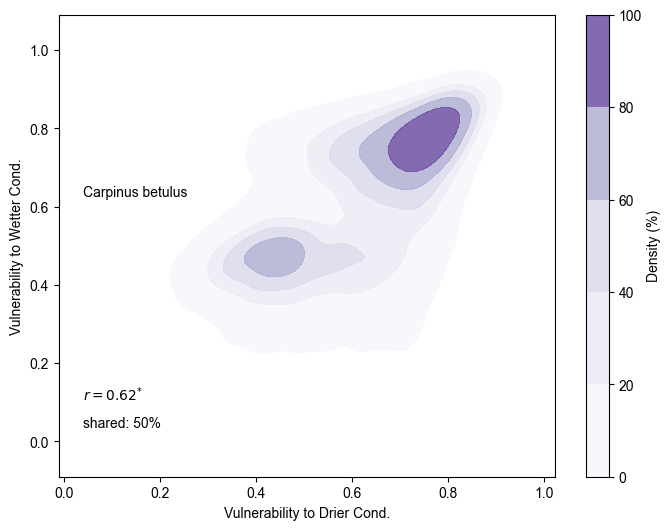

In [89]:
ispecies = "Carpinus betulus"
ichange_x = "drier"
ichange_y = "wetter"

ichange_sub_x = None  # "wetter"  # None
ichange_sub_y = None  # "drier"  # None

df_1 = get_shap_per_tree(
    ispecies=ispecies,
    ipattern="warmer_drier",
    ipattern_shap=ichange_x,
    subset_of_runs="all",
    df_single_responses=df_responses.copy(),
    df_both_patterns=df_both_patterns.copy(),
    df_temp_patterns=df_temp_patterns.copy(),
    df_spei_patterns=df_spei_patterns.copy(),
    nfi_sub=nfi_sub.copy(),
)

df_2 = get_shap_per_tree(
    ispecies=ispecies,
    ipattern="warmer_wetter",
    ipattern_shap=ichange_y,
    subset_of_runs="all",
    df_single_responses=df_responses.copy(),
    df_both_patterns=df_both_patterns.copy(),
    df_temp_patterns=df_temp_patterns.copy(),
    df_spei_patterns=df_spei_patterns.copy(),
    nfi_sub=nfi_sub.copy(),
)

# Merge the two dataframes
df_lm = pd.merge(
    df_1,
    df_2,
    on="tree_id",
    how="inner",
)[
    ["tree_id", ichange_x, ichange_y]
].sort_values(ichange_x)

# clear_output()
plot_kde_with_regression(
    df_lm[ichange_x],
    df_lm[ichange_y],
    text_3=(0.05, 0.6, ispecies),
    corr_method="r",
    ncountours=6,
    shared_perc=50,
)

#### Fig. 5


Working on top9 - all - r - 6 - drier - wetter
 - Working on Fagus sylvatica (1/8)
r = 0.29 | p = 0.00
 - Working on Quercus robur (2/8)
r = 0.26 | p = 0.00
 - Working on Quercus petraea (3/8)
r = 0.36 | p = 0.00
 - Working on Carpinus betulus (4/8)
r = 0.61 | p = 0.00
 - Working on Castanea sativa (5/8)
r = 0.19 | p = 0.00
 - Working on Pinus sylvestris (6/8)
r = 0.38 | p = 0.00
 - Working on Abies alba (7/8)
r = 0.52 | p = 0.00
 - Working on Picea abies (8/8)
r = 0.38 | p = 0.00


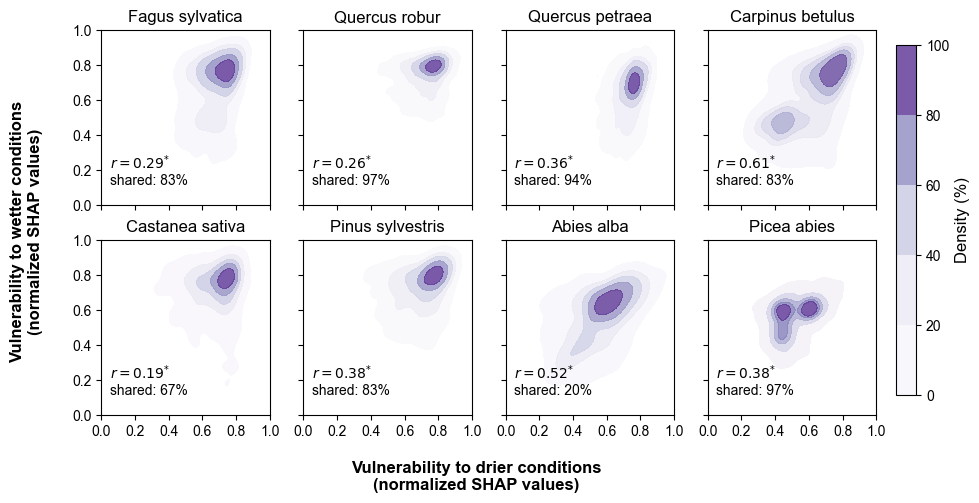

Working on all - all - r - 6 - drier - wetter
 - Working on Abies alba (1/38)
r = 0.52 | p = 0.00
 - Working on Abies grandis (2/38)
r = 0.20 | p = 0.28
 - Working on Acer pseudoplatanus (3/38)
r = 0.13 | p = 0.00
 - Working on Alnus glutinosa (4/38)
r = 0.17 | p = 0.00
 - Working on Alnus incana (5/38)
r = 0.46 | p = 0.04
 - Working on Arbutus unedo (6/38)
r = 0.40 | p = 0.00
 - Working on Betula pendula (7/38)
r = 0.43 | p = 0.00
 - Working on Buxus sempervirens (8/38)
r = 0.33 | p = 0.01
 - Working on Carpinus betulus (9/38)
r = 0.61 | p = 0.00
 - Working on Castanea sativa (10/38)
r = 0.19 | p = 0.00
 - Working on Crataegus monogyna (11/38)
r = 0.28 | p = 0.00
 - Working on Fagus sylvatica (12/38)
r = 0.29 | p = 0.00
 - Working on Juniperus communis (13/38)
r = -0.12 | p = 0.75
 - Working on Laburnum anagyroides (14/38)
r = 0.41 | p = 0.07
 - Working on Larix decidua (15/38)
r = 0.20 | p = 0.00
 - Working on Malus sylvestris (16/38)
r = 0.38 | p = 0.03
 - Working on Picea abies (17

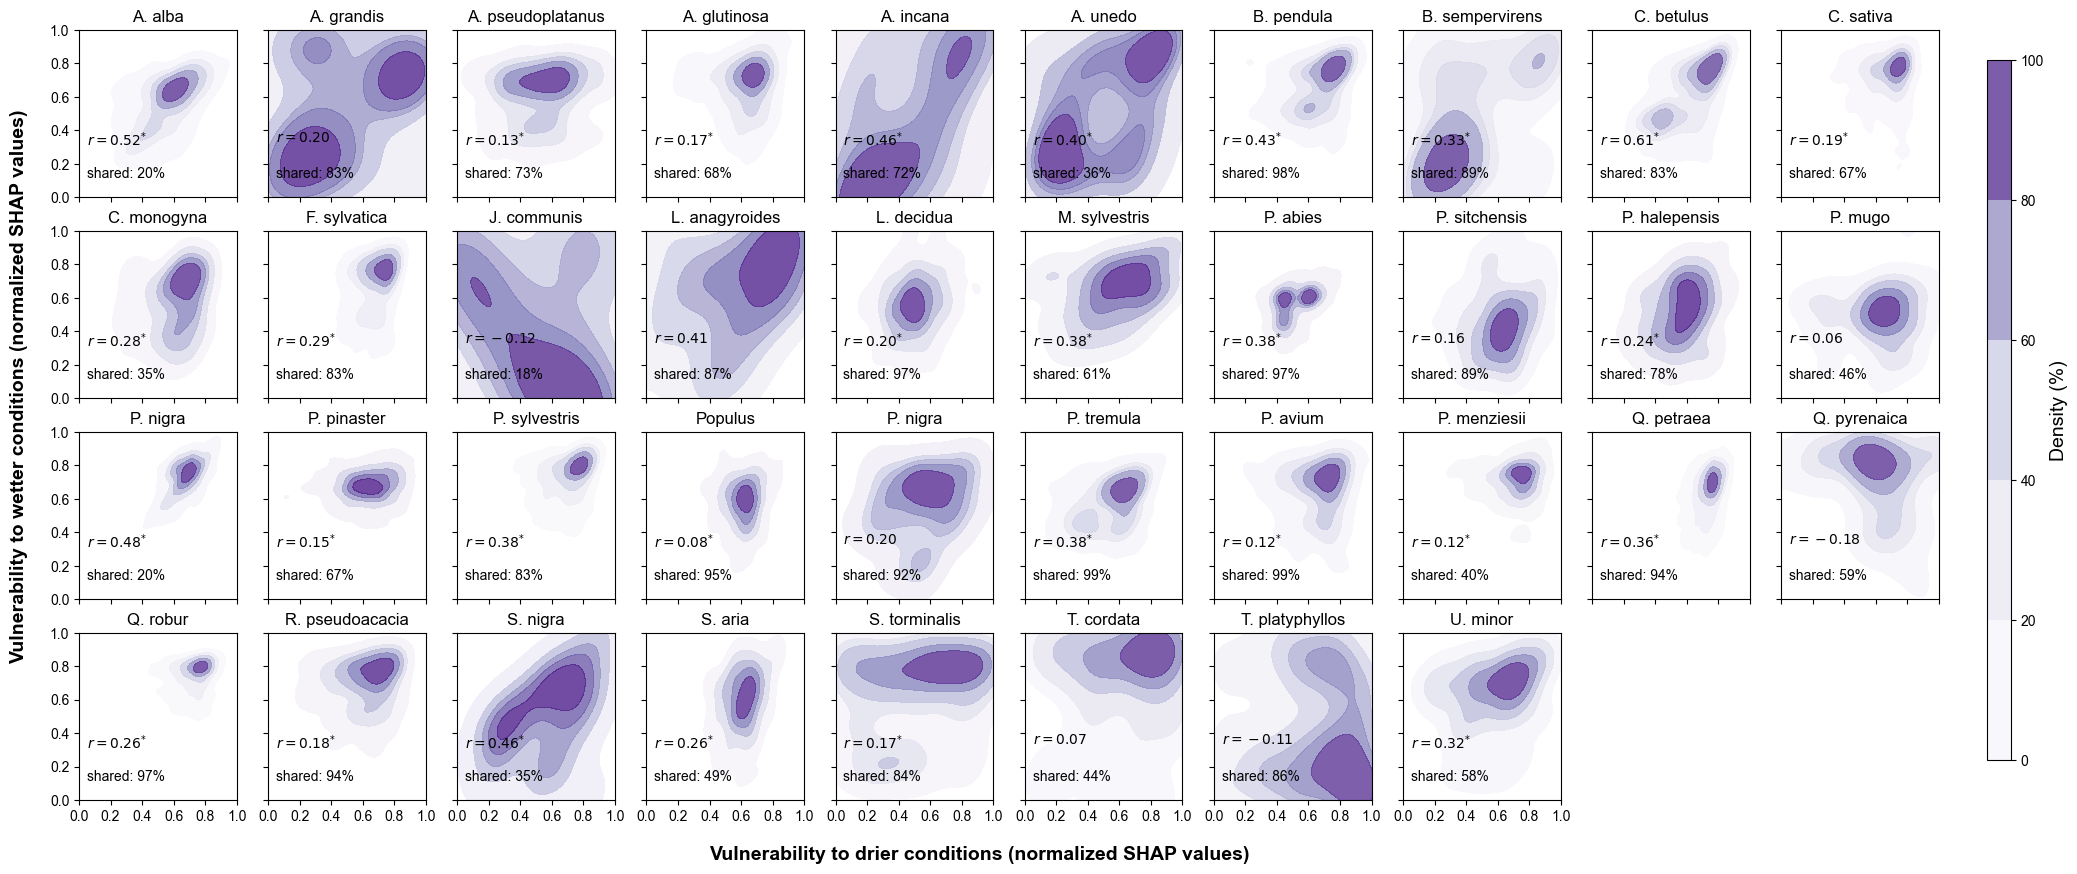

In [90]:
# subset_of_runs = "all"
# subset_of_runs = "grouped"
# subset_of_runs = "grouped_subset"

# for subset_of_runs in ["all", "grouped", "grouped_subset"]:
for subset_of_runs in ["all"]:
    data_for_density_plots = dens_get_data(
        subset_of_runs=subset_of_runs,
        df_responses=df_responses,
        df_both_patterns=df_both_patterns,
        df_temp_patterns=df_temp_patterns,
        df_spei_patterns=df_spei_patterns,
        nfi_sub=nfi_sub,
    )

    data_for_density_plots = dens_add_stats(
        data_for_density_plots,
        nfi_sub=nfi_sub,
        species_change_single=species_change_single,
    )

    # for icorr_method in ["mk", "r"]:
    for icorr_method in ["r"]:

        dens_make_plot(
            df_species_all=data_for_density_plots,
            top_species_all=top_species_all,
            subset_of_runs=subset_of_runs,
            xchange="drier",
            ychange="wetter",
            corr_method=icorr_method,
            dir_treelevel=dir_treelevel,
            ncountours=6,
            species_label_size=12,
            axis_label_size=12,
        )

In [91]:
# Taken from the figures above
# Top9:
r_mean_t9 = np.mean(
    [
        0.29,
        0.26,
        0.36,
        0.61,
        0.19,
        0.38,
        0.52,
        0.38,
    ]
)

# All:
r_mean_all = np.mean(
    [
        0.52,
        0.20,
        0.13,
        0.17,
        0.46,
        0.40,
        0.43,
        0.33,
        0.61,
        0.19,
        0.28,
        0.29,
        0.12,
        0.41,
        0.20,
        0.38,
        0.38,
        0.16,
        0.24,
        0.06,
        0.48,
        0.15,
        0.38,
        0.08,
        0.20,
        0.38,
        0.12,
        0.12,
        0.36,
        0.18,
        0.26,
        0.18,
        0.46,
        0.26,
        0.17,
        0.07,
        0.11,
        0.32,
    ]
)

print(f"Top9: {r_mean_t9:.2f}")
print(f"All: {r_mean_all:.2f}")

Top9: 0.37
All: 0.27


## Temporal SPEI importance


In [92]:
# Get directory
dir_treelevel = f"{dir_patterns}/tree-level"
os.makedirs(dir_treelevel, exist_ok=True)

# Get NFI Data
nfi_raw = get_final_nfi_data_for_analysis()
nfi_sub = nfi_raw[
    ["tree_id", "lat_fr", "lon_fr", "tree_state_change", "species_lat2", "campagne_2"]
]

# Get species data
species_in_final_anlysis = get_species_with_models("list")
species_in_final_anlysis = list(sorted(species_in_final_anlysis))


Loading final NFI data for analysis... (output of python wrangling)
- Latest file is /Users/pascal/my_work/projects active/ifn_analysis/data/final/nfi/nfi_ready_for_analysis.feather 
- Created on Monday 2024-11-25, 18:25 which is 95 days ago.
  Number of trees:  687268
  Number of sites:  50012
 - Looking for species with models in: ../../notebooks/03_model_fitting_and_analysis/model_runs/all_runs/*/*
 - Found 52 species with models


In [93]:
species_with_models = get_species_with_models("list")

 - Looking for species with models in: ../../notebooks/03_model_fitting_and_analysis/model_runs/all_runs/*/*
 - Found 52 species with models


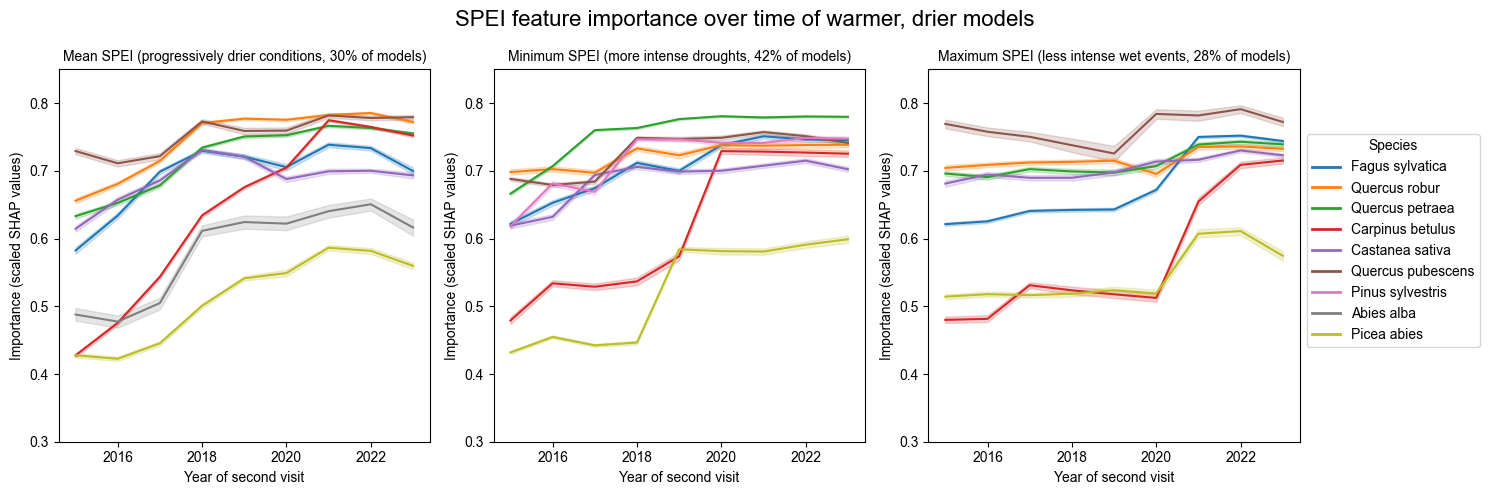

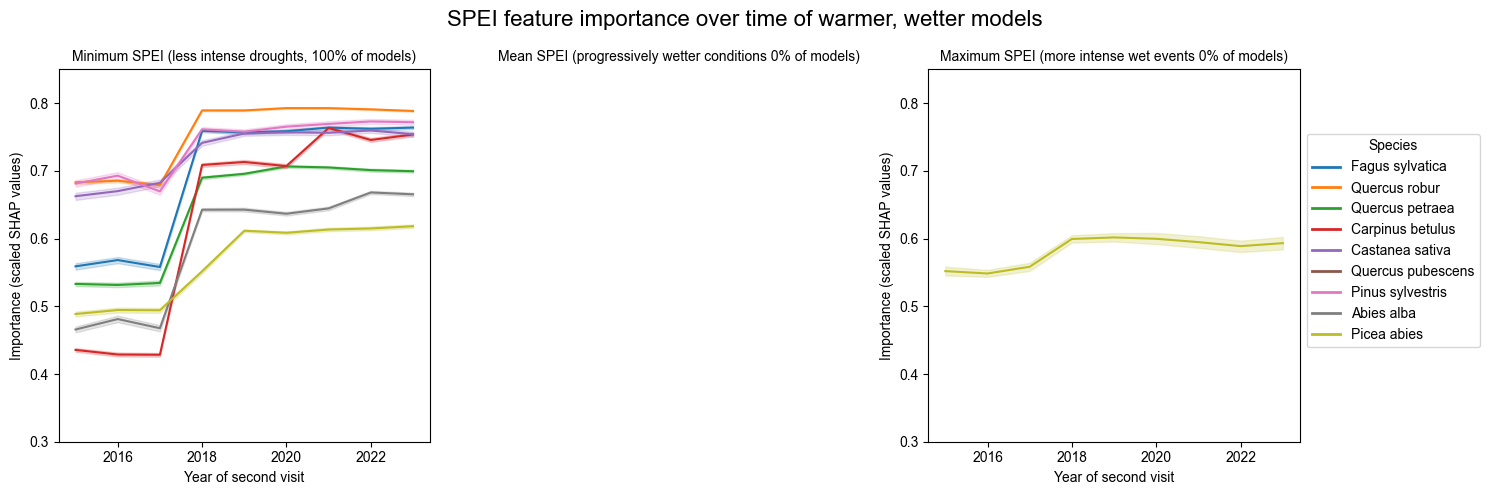

In [94]:
from matplotlib.lines import Line2D

for ipattern in ["drier", "wetter"]:

    # Start figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs = axs.flatten()

    # Get color palette for top9
    cp_top9 = sns.color_palette("tab10", n_colors=9)
    # Make to dictionary
    cp_top9 = dict(zip(top9, cp_top9))

    # Loop over all anomalies
    anomaly_order = (
        ["_mean", "_min", "_max"] if ipattern == "drier" else ["_min", "_mean", "_max"]
    )
    for i, add_filter_spei_features in enumerate(anomaly_order):

        df_list = []

        # Get data per species
        # for ispecies in species_with_models:
        for ispecies in top9:

            idf = get_shap_per_tree(
                ispecies=ispecies,
                ipattern=f"warmer_{ipattern}",
                ipattern_shap=ipattern,
                subset_of_runs="all",
                df_single_responses=df_responses.copy(),
                df_both_patterns=df_both_patterns.copy(),
                df_temp_patterns=df_temp_patterns.copy(),
                df_spei_patterns=df_spei_patterns.copy(),
                nfi_sub=nfi_sub.copy(),
                add_filter_spei_features=add_filter_spei_features,
                verbose=False,
            )

            if idf.__len__() == 0:
                continue

            df_list.append(idf)

        # Add plot layout in any case
        # Get ylab based on add_filter_spei_features
        # ! IMPORTANT: PERCENTAGE NUMBERS FROM PIE CHART PLOT, COPIED BY HAND!
        if ipattern == "drier":
            if add_filter_spei_features == "_min":
                # ylab = "Probability of tree mortality wrt. \ndecreasing SPEI minimum anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = "Minimum SPEI (more intense droughts, 42% of models)"
            elif add_filter_spei_features == "_mean":
                # ylab = "Probability of tree mortality wrt. \ndecreasing SPEI mean anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = "Mean SPEI (progressively drier conditions, 30% of models)"
            elif add_filter_spei_features == "_max":
                # ylab = "Probability of tree mortality wrt. \ndecreasing SPEI maximum anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = "Maximum SPEI (less intense wet events, 28% of models)"

        elif ipattern == "wetter":
            if add_filter_spei_features == "_min":
                # ylab = "Probability of tree mortality wrt. \nincreasing SPEI minimum anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = "Minimum SPEI (less intense droughts, 100% of models)"
            elif add_filter_spei_features == "_mean":
                # ylab = "Probability of tree mortality wrt. \nincreasing SPEI mean anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = "Mean SPEI (progressively wetter conditions 0% of models)"
            elif add_filter_spei_features == "_max":
                # ylab = "Probability of tree mortality wrt. \nincreasing SPEI maximum anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = "Maximum SPEI (more intense wet events 0% of models)"

        axs[i].set_xlabel("Year of second visit")
        axs[i].set_ylabel(ylab)
        axs[i].set_title(subtitle, fontsize=10)
        axs[i].set_ylim(0.3, 0.85)

        # If no data was extracted, skip
        if df_list.__len__() == 0:
            axs[i].axis("off")
            continue

        # Concat data
        df_list = pd.concat(df_list)

        df_top9 = df_list.query("species_lat2 in @top9")
        df_rest = df_list.query("species_lat2 not in @top9")

        # Reset species categories to what is present
        df_list["species_lat2"] = pd.Categorical(
            df_list["species_lat2"], categories=top9, ordered=True
        )

        # ! Plot
        sns.lineplot(
            data=df_list,
            x="campagne_2",
            y=ipattern,
            hue="species_lat2",
            ax=axs[i],
            # color=cp_top9[ispecies],
            # alpha=n_runs / 50,
        )

        # Remove legend
        axs[i].get_legend().remove()

    # Make custom legend
    legend_elements = [
        Line2D([0], [0], color=cp_top9[ispecies], lw=2, label=ispecies)
        for ispecies in top9
    ]

    # Add legend
    axs[2].legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1, 0.54),
        title="Species",
    )

    # Add main title
    fig.suptitle(
        f"SPEI feature importance over time of warmer, {ipattern} models",
        fontsize=16,
    )

    plt.tight_layout()
    fig.savefig(f"{dir_treelevel}/temporal-spei-warmer_{ipattern}.png")
    plt.show()

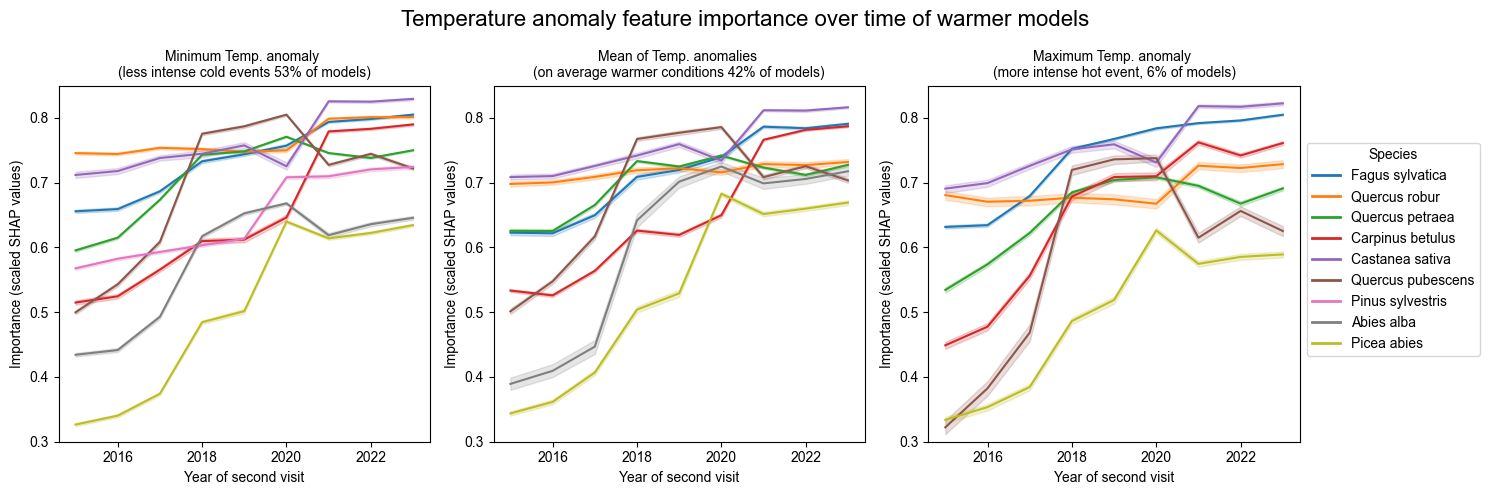

In [95]:
from matplotlib.lines import Line2D

for ipattern in ["warmer"]:

    # Start figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs = axs.flatten()

    # Get color palette for top9
    cp_top9 = sns.color_palette("tab10", n_colors=9)
    # Make to dictionary
    cp_top9 = dict(zip(top9, cp_top9))

    # Loop over all anomalies
    anomaly_order = (
        ["_mean", "_min", "_max"] if ipattern == "drier" else ["_min", "_mean", "_max"]
    )
    for i, add_filter_spei_features in enumerate(anomaly_order):

        # Get ylab based on add_filter_spei_features
        if ipattern == "warmer":
            if add_filter_spei_features == "_min":
                # ylab = "Probability of tree mortality wrt. \nincreasing temperature minimum anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = (
                    "Minimum Temp. anomaly \n(less intense cold events 53% of models)"
                )
            elif add_filter_spei_features == "_mean":
                # ylab = "Probability of tree mortality wrt. \nincreasing temperature mean anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = "Mean of Temp. anomalies \n(on average warmer conditions 42% of models)"
            elif add_filter_spei_features == "_max":
                # ylab = "Probability of tree mortality wrt. \nincreasing temperature maximum anomaly (scaled SHAP values)"
                ylab = "Importance (scaled SHAP values)"
                subtitle = (
                    "Maximum Temp. anomaly \n(more intense hot event, 6% of models)"
                )

        else:
            raise ValueError(f"Pattern '{ipattern}' not found!")

        # Get data per species
        df_list = []
        # for ispecies in species_with_models:
        for ispecies in top9:

            idf = get_shap_per_tree(
                ispecies=ispecies,
                ipattern=f"warmer",
                ipattern_shap=ipattern,
                subset_of_runs="all",
                df_single_responses=df_responses.copy(),
                df_both_patterns=df_both_patterns.copy(),
                df_temp_patterns=df_temp_patterns.copy(),
                df_spei_patterns=df_spei_patterns.copy(),
                nfi_sub=nfi_sub.copy(),
                add_filter_spei_features=add_filter_spei_features,
                verbose=False,
            )

            if idf.__len__() == 0:
                continue

            df_list.append(idf)

        # Add plot layout in any case
        axs[i].set_xlabel("Year of second visit")
        axs[i].set_ylabel(ylab)
        axs[i].set_title(subtitle, fontsize=10)
        axs[i].set_ylim(0.3, 0.85)

        # If no data was extracted, skip
        if df_list.__len__() == 0:
            axs[i].axis("off")
            continue

        # Concat data
        df_list = pd.concat(df_list)

        df_top9 = df_list.query("species_lat2 in @top9")
        df_rest = df_list.query("species_lat2 not in @top9")

        # Reset species categories to what is present
        df_list["species_lat2"] = pd.Categorical(
            df_list["species_lat2"], categories=top9, ordered=True
        )

        # ! Plot
        sns.lineplot(
            data=df_list,
            x="campagne_2",
            y=ipattern,
            hue="species_lat2",
            ax=axs[i],
            # color=cp_top9[ispecies],
            # alpha=n_runs / 50,
        )

        # Remove legend
        axs[i].get_legend().remove()

    # Make custom legend
    legend_elements = [
        Line2D([0], [0], color=cp_top9[ispecies], lw=2, label=ispecies)
        for ispecies in top9
    ]

    # Add legend
    axs[2].legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(1, 0.54),
        title="Species",
    )

    # Add main title
    fig.suptitle(
        f"Temperature anomaly feature importance over time of warmer models",
        fontsize=16,
    )
    plt.tight_layout()
    fig.savefig(f"{dir_treelevel}/temporal-temp-all.png")

    plt.show()

---
